# Assignment for Week 13 MLDS
by Eva Aßmann, Katrin Böhler, Paul Vogler<br>
Code used from: https://github.com/orico/ActiveLearningFrameworkTutorial

In [0]:
# -*- coding: utf-8 -*-
import os
import time
import json
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import scipy
from scipy import stats
from pylab import rcParams
from sklearn.utils import check_random_state
from sklearn.datasets import load_breast_cancer
# from sklearn.datasets import fetch_covtype
# from sklearn.datasets import load_iris
# from sklearn.datasets import fetch_mldata
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.datasets import fetch_openml

# Load and explore data

### Define download and test/train split functions

In [0]:
trainset_size_mnist = 60000 # ie., testset_size_mnist = 10000
trainset_size_bc = 483 # testset_size_bc=86 chosen by the train/test ratio of mnist of approx. 85%/15%
def download():
 #mnist = fetch_mldata('MNIST original')
#  mnist = load_digits()
#  X = mnist.data.astype('float64')
#  y = mnist.target
 X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
 print ('MNIST:', X.shape, y.shape)
 return (X, y)

def download_iris():
 iris = load_iris()
 X = iris.data.astype('float64')
 y = iris.target
 print ('Iris: ', X.shape, y.shape)
 return (X, y)

def download_bc():
 X, y = load_breast_cancer(return_X_y=True)
 print ('Breast Cancer : ', X.shape, y.shape)
 return (X, y)

def split(train_size, X, y):
 X_train_full = X[:train_size]
 y_train_full = y[:train_size]
 X_test = X[train_size:]
 y_test = y[train_size:]
 return (X_train_full, y_train_full, X_test, y_test)

In [0]:
(X_mnist, y_mnist) = download()
# (X_iris, y_iris) = download_iris()
(X_bc, y_bc) = download_bc()

MNIST: (70000, 784) (70000,)
Breast Cancer :  (569, 30) (569,)


### Breast Cancer data set

In [0]:
X_bc.shape, y_bc.shape

((569, 30), (569,))

In [0]:
group = pd.DataFrame(data=y_bc, columns = ['Benign_Malign'])
column = ['radius', 'texture','perimeter','area', 'smoothness', 'compactness', 'concavity', 'concave_points', 'symmetry', 'fractal_dimension']
columns = [col + '_mean' for col in column] + [col + '_se' for col in column] + [col + '_worst' for col in column]
bc_frame = pd.DataFrame(data=X_bc, columns = columns)
bc_frame.describe()

radius_mean  texture_mean  ...  symmetry_worst  fractal_dimension_worst
count   569.000000    569.000000  ...      569.000000               569.000000
mean     14.127292     19.289649  ...        0.290076                 0.083946
std       3.524049      4.301036  ...        0.061867                 0.018061
min       6.981000      9.710000  ...        0.156500                 0.055040
25%      11.700000     16.170000  ...        0.250400                 0.071460
50%      13.370000     18.840000  ...        0.282200                 0.080040
75%      15.780000     21.800000  ...        0.317900                 0.092080
max      28.110000     39.280000  ...        0.663800                 0.207500

[8 rows x 30 columns]

In [0]:
bc_frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 30 columns):
radius_mean                569 non-null float64
texture_mean               569 non-null float64
perimeter_mean             569 non-null float64
area_mean                  569 non-null float64
smoothness_mean            569 non-null float64
compactness_mean           569 non-null float64
concavity_mean             569 non-null float64
concave_points_mean        569 non-null float64
symmetry_mean              569 non-null float64
fractal_dimension_mean     569 non-null float64
radius_se                  569 non-null float64
texture_se                 569 non-null float64
perimeter_se               569 non-null float64
area_se                    569 non-null float64
smoothness_se              569 non-null float64
compactness_se             569 non-null float64
concavity_se               569 non-null float64
concave_points_se          569 non-null float64
symmetry_se                569 

In [0]:
group.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 1 columns):
Benign_Malign    569 non-null int64
dtypes: int64(1)
memory usage: 4.6 KB


In [0]:
group.Benign_Malign.unique()

array([0, 1])

### MNIST data set

In [0]:
X_mnist.shape, y_mnist.shape

((70000, 784), (70000,))

In [0]:
mnist_target = pd.DataFrame(data=y_mnist, columns=['digitlabel'])
mnist_features = pd.DataFrame(data=X_mnist)

In [0]:
mnist_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Columns: 784 entries, 0 to 783
dtypes: float64(784)
memory usage: 418.7 MB


In [0]:
mnist_features.describe()

0        1        2        3    ...      780      781      782      783
count  70000.0  70000.0  70000.0  70000.0  ...  70000.0  70000.0  70000.0  70000.0
mean       0.0      0.0      0.0      0.0  ...      0.0      0.0      0.0      0.0
std        0.0      0.0      0.0      0.0  ...      0.0      0.0      0.0      0.0
min        0.0      0.0      0.0      0.0  ...      0.0      0.0      0.0      0.0
25%        0.0      0.0      0.0      0.0  ...      0.0      0.0      0.0      0.0
50%        0.0      0.0      0.0      0.0  ...      0.0      0.0      0.0      0.0
75%        0.0      0.0      0.0      0.0  ...      0.0      0.0      0.0      0.0
max        0.0      0.0      0.0      0.0  ...      0.0      0.0      0.0      0.0

[8 rows x 784 columns]

In [0]:
np.unique(mnist_features.describe()[mnist_features.describe().index == 'min'].values)

array([0.])

In [0]:
np.unique(mnist_features.describe()[mnist_features.describe().index == 'max'].values)

array([  0.,   7.,   9.,  15.,  16.,  24.,  28.,  29.,  31.,  32.,  37.,
        38.,  39.,  40.,  42.,  47.,  51.,  52.,  59.,  60.,  62.,  63.,
        64.,  72.,  93.,  94.,  95.,  98., 101., 104., 107., 113., 114.,
       116., 121., 127., 128., 133., 134., 139., 141., 144., 150., 152.,
       153., 156., 163., 165., 184., 185., 188., 190., 191., 192., 197.,
       210., 216., 217., 220., 221., 223., 225., 226., 234., 236., 243.,
       244., 245., 246., 247., 252., 253., 254., 255.])

In [0]:
mnist_target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 1 columns):
digitlabel    70000 non-null object
dtypes: object(1)
memory usage: 547.0+ KB


In [0]:
mnist_target.digitlabel.unique()

array(['5', '0', '4', '1', '9', '2', '3', '6', '7', '8'], dtype=object)

# Fully supervised learning

## MNIST

In [0]:
(X_train_full_mnist, y_train_full_mnist, X_test_mnist, y_test_mnist) = split(trainset_size_mnist, X_mnist, y_mnist)
print ('train:', X_train_full_mnist.shape, y_train_full_mnist.shape)
print ('test :', X_test_mnist.shape, y_test_mnist.shape)
classes_mnist = len(np.unique(y_mnist))
print ('unique classes', classes_mnist)

fully_SVM = LinearSVC(C=1, verbose=1, max_iter=10000)
fully_RF = RandomForestClassifier(n_estimators=500, verbose=1)
fully_GNB = GaussianNB()
classifier_list = [fully_SVM, fully_RF, fully_GNB]
name_list = ["linear SVM", "Random Forest", "Gaussian Naive Bayes"]
scores = []
f1_scores = []
for name, classifier in zip(name_list,classifier_list):
  print("train ", name, " Classifier:...")
  classifier.fit(X_train_full_mnist, y_train_full_mnist)
  print("predict labels...")
  predicted = classifier.predict(X_test_mnist)
  f1 =  round(metrics.f1_score(y_test_mnist, predicted, average='weighted') * 100,2)
  score = round(classifier.score(X_test_mnist, y_test_mnist)* 100,2)
  print(name, " accuracy score: ", score, "%")
  print(name, " weighted f1 score: ", f1, "%")
  scores.append(score)
  f1_scores.append(f1)
svm_upper_bound, random_forest_upper_bound, gaussian_upper_bound = scores
svm_upper_bound_f1, random_forest_upper_bound_f1, gaussian_upper_bound_f1 = f1_scores

train: (60000, 784) (60000,)
test : (10000, 784) (10000,)
unique classes 10
train  linear SVM  Classifier:...
[LibLinear]

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


predict labels...
linear SVM  accuracy score:  83.63 %
linear SVM  weighted f1 score:  83.64 %
train  Random Forest  Classifier:...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:  4.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


predict labels...


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    2.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    2.1s finished


Random Forest  accuracy score:  97.14 %
Random Forest  weighted f1 score:  97.14 %
train  Gaussian Naive Bayes  Classifier:...
predict labels...
Gaussian Naive Bayes  accuracy score:  55.58 %
Gaussian Naive Bayes  weighted f1 score:  51.7 %


In [0]:
''' just to set the upper bounds without rerunning '''
# svm_upper_bound = 83.63
# svm_upper_bound_f1 = 83.64
# random_forest_upper_bound = 97.14
# random_forest_upper_bound_f1 = 97.14
# gaussian_upper_bound = 55.58
# gaussian_upper_bound_f1 = 51.7

## Breast Cancer dataset

In [0]:
(X_train_full_bc, y_train_full_bc, X_test_bc, y_test_bc) = split(trainset_size_bc, X_bc, y_bc)
print ('train:', X_train_full_bc.shape, y_train_full_bc.shape)
print ('test :', X_test_bc.shape, y_test_bc.shape)
classes_bc = len(np.unique(y_bc))
print ('unique classes', classes_bc)

fully_SVM = LinearSVC(C=1, verbose=1, max_iter=10000)
fully_RF = RandomForestClassifier(n_estimators=500)
fully_GNB = GaussianNB()
classifier_list = [fully_SVM, fully_RF, fully_GNB]
name_list = ["linear SVM", "Random Forest", "Gaussian Naive Bayes"]
scores_bc = []
f1_scores_bc = []
for name, classifier in zip(name_list,classifier_list):
  print("train ", name, " Classifier:...")
  classifier.fit(X_train_full_bc, y_train_full_bc)
  print("predict labels...")
  predicted = classifier.predict(X_test_bc)
  f1 = round(metrics.f1_score(y_test_bc, predicted,average='weighted')*100,2)
  score = round(classifier.score(X_test_bc, y_test_bc)* 100,2) 
  print(name, " accuracy score: ", score, "%")
  print(name, " weighted f1 score: ", f1, "%")
  scores_bc.append(score)
  f1_scores_bc.append(f1)
svm_upper_bound_bc, random_forest_upper_bound_bc,  gaussian_upper_bound_bc = scores_bc
svm_upper_bound_bc_f1, random_forest_upper_bound_bc_f1, gaussian_upper_bound_bc_f1 = f1_scores_bc

train: (483, 30) (483,)
test : (86, 30) (86,)
unique classes 2
train  linear SVM  Classifier:...
[LibLinear]

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


predict labels...
linear SVM  accuracy score:  96.51 %
linear SVM  weighted f1 score:  96.48 %
train  Random Forest  Classifier:...
predict labels...
Random Forest  accuracy score:  97.67 %
Random Forest  weighted f1 score:  97.71 %
train  Gaussian Naive Bayes  Classifier:...
predict labels...
Gaussian Naive Bayes  accuracy score:  95.35 %
Gaussian Naive Bayes  weighted f1 score:  95.35 %


In [0]:
''' just to set the upper bounds without rerunning '''
# svm_upper_bound_bc = 96.51
# svm_upper_bound_bc_f1 = 96.48
# random_forest_upper_bound_bc = 97.67
# random_forest_upper_bound_bc_f1 = 97.71
# gaussian_upper_bound_bc = 95.35
# gaussian_upper_bound_bc_f1 = 95.35

# Active learning

### Define training model classes

In [0]:
class BaseModel(object):

    def __init__(self):
        pass

    def fit_predict(self):
        pass


class SvmModel(BaseModel):

    model_type = 'Support Vector Machine with linear Kernel'
    def fit_predict(self, X_train, y_train, X_val, X_test, c_weight):
        print ('training svm...')
        self.classifier = SVC(C=1, kernel='linear', probability=True,
                              class_weight=c_weight)
        self.classifier.fit(X_train, y_train)
        self.test_y_predicted = self.classifier.predict(X_test)
        self.val_y_predicted = self.classifier.predict(X_val)
        return (X_train, X_val, X_test, self.val_y_predicted,
                self.test_y_predicted)


class RfModel(BaseModel):

    model_type = 'Random Forest'
    
    def fit_predict(self, X_train, y_train, X_val, X_test, c_weight):
        print ('training random forest...')
        self.classifier = RandomForestClassifier(n_estimators=500, class_weight=c_weight)
        self.classifier.fit(X_train, y_train)
        self.test_y_predicted = self.classifier.predict(X_test)
        self.val_y_predicted = self.classifier.predict(X_val)
        return (X_train, X_val, X_test, self.val_y_predicted, self.test_y_predicted)

class GaussianModel(BaseModel):

    model_type = 'Gaussian Naive Bayes'
    
    def fit_predict(self, X_train, y_train, X_val, X_test, c_weight):
        print ('training Gaussian Naive Bayes...')
        self.classifier = GaussianNB()
        self.classifier.fit(X_train, y_train)
        self.test_y_predicted = self.classifier.predict(X_test)
        self.val_y_predicted = self.classifier.predict(X_val)
        return (X_train, X_val, X_test, self.val_y_predicted, self.test_y_predicted)

### Define class to train the training classes 

In [0]:

class TrainModel:

    def __init__(self, model_object):        
        self.accuracies = []
        self.f1_scores = []
        self.model_object = model_object()        

    def print_model_type(self):
        print (self.model_object.model_type)

    # we train normally and get probabilities for the validation set. i.e., we use the probabilities to select the most uncertain samples

    def train(self, X_train, y_train, X_val, X_test, c_weight):
        print ('Train set:', X_train.shape, 'y:', y_train.shape)
        print ('Val   set:', X_val.shape)
        print ('Test  set:', X_test.shape)
        t0 = time.time()
        (X_train, X_val, X_test, self.val_y_predicted,
         self.test_y_predicted) = \
            self.model_object.fit_predict(X_train, y_train, X_val, X_test, c_weight)
        self.run_time = time.time() - t0
        return (X_train, X_val, X_test)  # we return them in case we use PCA, with all the other algorithms, this is not needed.

    # we want accuracy only for the test set

    def get_test_accuracy(self, i, y_test):
        classif_rate = np.mean(self.test_y_predicted.ravel() == y_test.ravel()) * 100
        self.accuracies.append(classif_rate)
        f1_score = metrics.f1_score(y_test.ravel(), self.test_y_predicted.ravel(),average='weighted') *100
        self.f1_scores.append(f1_score)              
        print('--------------------------------')
        print('Iteration:',i)
        print('--------------------------------')
        print('y-test set:',y_test.shape)
        print('Example run in %.3f s' % self.run_time,'\n')
        print("Accuracy rate for %f " % (classif_rate))
        print("weighted F1 score for %f " % (f1_score))    
        print("Classification report for classifier %s:\n%s\n" % (self.model_object.classifier, metrics.classification_report(y_test, self.test_y_predicted)))
        print("Confusion matrix:\n%s" % metrics.confusion_matrix(y_test, self.test_y_predicted))
        print('--------------------------------')

### Define sample selection classes

In [0]:

class BaseSelectionFunction(object):

    def __init__(self):
        pass

    def select(self):
        pass


class RandomSelection(BaseSelectionFunction):

    @staticmethod
    def select(probas_val, initial_labeled_samples):
        random_state = check_random_state(0)
        selection = np.random.choice(probas_val.shape[0], initial_labeled_samples, replace=False)

#     print('uniques chosen:',np.unique(selection).shape[0],'<= should be equal to:',initial_labeled_samples)

        return selection


class EntropySelection(BaseSelectionFunction):

    @staticmethod
    def select(probas_val, initial_labeled_samples):
        e = (-probas_val * np.log2(probas_val)).sum(axis=1)
        selection = (np.argsort(e)[::-1])[:initial_labeled_samples]
        return selection
      
      
class MarginSamplingSelection(BaseSelectionFunction):

    @staticmethod
    def select(probas_val, initial_labeled_samples):
        rev = np.sort(probas_val, axis=1)[:, ::-1]
        values = rev[:, 0] - rev[:, 1]
        selection = np.argsort(values)[:initial_labeled_samples]
        return selection

### Define a class to normalize using a MinMax Scaler in the range of [0,1]

In [0]:
class Normalize(object):
    
    def normalize(self, X_train, X_val, X_test):
        self.scaler = MinMaxScaler()
        X_train = self.scaler.fit_transform(X_train)
        X_val   = self.scaler.transform(X_val)
        X_test  = self.scaler.transform(X_test)
        return (X_train, X_val, X_test) 
    
    def inverse(self, X_train, X_val, X_test):
        X_train = self.scaler.inverse_transform(X_train)
        X_val   = self.scaler.inverse_transform(X_val)
        X_test  = self.scaler.inverse_transform(X_test)
        return (X_train, X_val, X_test) 

In [0]:
def get_k_random_samples(initial_labeled_samples, X_train_full,
                         y_train_full, trainset_size):
    random_state = check_random_state(0)
    permutation = np.random.choice(trainset_size,
                                   initial_labeled_samples,
                                   replace=False)
    print ()
    print ('initial random chosen samples', permutation.shape),
#            permutation)
    X_train = X_train_full[permutation]
    y_train = y_train_full[permutation]
    X_train = X_train.reshape((X_train.shape[0], -1))
    bin_count = np.bincount(y_train.astype('int64'))
    unique = np.unique(y_train.astype('int64'))
    print (
        'initial train set:',
        X_train.shape,
        y_train.shape,
        'unique(labels):',
        bin_count,
        unique,
        )
    return (permutation, X_train, y_train)

### Define class for the active learning process

In [0]:
class TheAlgorithm(object):

    accuracies = []

    def __init__(self, initial_labeled_samples, model_object, selection_function):
        self.initial_labeled_samples = initial_labeled_samples
        self.model_object = model_object
        self.sample_selection_function = selection_function

    def run(self, X_train_full, y_train_full, X_test, y_test, max_queried, trainset_size):

        # initialize process by applying base learner to labeled training data set to obtain Classifier

        (permutation, X_train, y_train) = \
            get_k_random_samples(self.initial_labeled_samples,
                                 X_train_full, y_train_full, trainset_size)
        self.queried = self.initial_labeled_samples
        self.samplecount = [self.initial_labeled_samples]

        # permutation, X_train, y_train = get_equally_k_random_samples(self.initial_labeled_samples,classes)

        # assign the val set the rest of the 'unlabelled' training data

        X_val = np.array([])
        y_val = np.array([])
        X_val = np.copy(X_train_full)
        X_val = np.delete(X_val, permutation, axis=0)
        y_val = np.copy(y_train_full)
        y_val = np.delete(y_val, permutation, axis=0)
        print ('val set:', X_val.shape, y_val.shape, permutation.shape)
        print ()

        # normalize data

        normalizer = Normalize()
        X_train, X_val, X_test = normalizer.normalize(X_train, X_val, X_test)   
        
        self.clf_model = TrainModel(self.model_object)
        (X_train, X_val, X_test) = self.clf_model.train(X_train, y_train, X_val, X_test, 'balanced')
        active_iteration = 1
        self.clf_model.get_test_accuracy(1, y_test)

        # fpfn = self.clf_model.test_y_predicted.ravel() != y_val.ravel()
        # print(fpfn)
        # self.fpfncount = []
        # self.fpfncount.append(fpfn.sum() / y_test.shape[0] * 100)

        while self.queried < max_queried:

            active_iteration += 1

            # get validation probabilities

            probas_val = \
                self.clf_model.model_object.classifier.predict_proba(X_val)
            print ('val predicted:',
                   self.clf_model.val_y_predicted.shape,
                   self.clf_model.val_y_predicted)
            print ('probabilities:', probas_val.shape, '\n',
                   np.argmax(probas_val, axis=1))

            # select samples using a selection function

            uncertain_samples = \
                self.sample_selection_function.select(probas_val, self.initial_labeled_samples)

            # normalization needs to be inversed and recalculated based on the new train and test set.
 
            X_train, X_val, X_test = normalizer.inverse(X_train, X_val, X_test)   

            # get the uncertain samples from the validation set

            print ('trainset before', X_train.shape, y_train.shape)
            X_train = np.concatenate((X_train, X_val[uncertain_samples]))
            y_train = np.concatenate((y_train, y_val[uncertain_samples]))
            print ('trainset after', X_train.shape, y_train.shape)
            self.samplecount.append(X_train.shape[0])

            bin_count = np.bincount(y_train.astype('int64'))
            unique = np.unique(y_train.astype('int64'))
            print (
                'updated train set:',
                X_train.shape,
                y_train.shape,
                'unique(labels):',
                bin_count,
                unique,
                )

            X_val = np.delete(X_val, uncertain_samples, axis=0)
            y_val = np.delete(y_val, uncertain_samples, axis=0)
            print ('val set:', X_val.shape, y_val.shape)
            print ()

            # normalize again after creating the 'new' train/test sets
            normalizer = Normalize()
            X_train, X_val, X_test = normalizer.normalize(X_train, X_val, X_test)               

            self.queried += self.initial_labeled_samples
            (X_train, X_val, X_test) = self.clf_model.train(X_train, y_train, X_val, X_test, 'balanced')
            self.clf_model.get_test_accuracy(active_iteration, y_test)

        print ('final active learning accuracies',
               self.clf_model.accuracies)
        print ('final active learning f1 scores',
               self.clf_model.f1_scores)

### Define experiments

In [0]:
def pickle_save(fname, data):
  filehandler = open(fname,"wb")
  pickle.dump(data,filehandler)
  filehandler.close() 
  print('saved', fname, os.getcwd(), os.listdir())

def pickle_load(fname):
  print(os.getcwd(), os.listdir())
  file = open(fname,'rb')
  data = pickle.load(file)
  file.close()
  print(data)
  return data
  
def experiment(d, models, selection_functions, Ks, repeats, contfrom, X_train_full, y_train_full, X_test, y_test,max_queried, trainset_size):
    algos_temp = []
    print ('stopping at:', max_queried)
    count = 0
    for model_object in models:
      if model_object.__name__ not in d:
          d[model_object.__name__] = {}
      
      for selection_function in selection_functions:
        if selection_function.__name__ not in d[model_object.__name__]:
            d[model_object.__name__][selection_function.__name__] = {}
        
        for k in Ks:
            d[model_object.__name__][selection_function.__name__][str(k)] = []           
            
            for i in range(0, repeats):
                count+=1
                if count >= contfrom:
                    print ('Count = %s, using model = %s, selection_function = %s, k = %s, iteration = %s.' % (count, model_object.__name__, selection_function.__name__, k, i))
                    alg = TheAlgorithm(k, 
                                       model_object, 
                                       selection_function
                                       )
                    alg.run(X_train_full, y_train_full, X_test, y_test, max_queried, trainset_size)
                    d[model_object.__name__][selection_function.__name__][str(k)].append([alg.clf_model.accuracies,alg.clf_model.f1_scores])
                    fname = 'Active-learning-experiment-' + str(count) + '.pkl'
                    pickle_save(fname, d)
                    if count % 5 == 0:
                        print(json.dumps(d, indent=2, sort_keys=True))
                    print ()
                    print ('---------------------------- FINISHED ---------------------------')
                    print ()
    return d

## Define Plot functions

Plot function for the accuracies

In [0]:
def performance_plot(fully_supervised_accuracy, dic, models, selection_functions, Ks, repeats):  
    fig, ax = plt.subplots()
    ax.plot([0,500],[fully_supervised_accuracy, fully_supervised_accuracy],label = 'algorithm-upper-bound')
    for model_object in models:
      for selection_function in selection_functions:
        for idx, k in enumerate(Ks):
            x = np.arange(float(Ks[idx]), 500 + float(Ks[idx]), float(Ks[idx]))            
            Sum = np.array(dic[model_object][selection_function][k][0][0])
            for i in range(1, repeats):
                Sum = Sum + np.array(dic[model_object][selection_function][k][i][0])
            mean = Sum / repeats
            ax.plot(x, mean ,label = model_object + '-' + selection_function + '-' + str(k))
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_xlim([50,500])
    ax.set_ylim([40,100])
    ax.grid(True)
    plt.title("Accuracies")
    plt.show()
    return None

Plot function for the F1 score

In [0]:
def performance_plot_f1(fully_supervised_accuracy, dic, models, selection_functions, Ks, repeats):  
    fig, ax = plt.subplots()
    ax.plot([0,500],[fully_supervised_accuracy, fully_supervised_accuracy],label = 'algorithm-upper-bound')
    for model_object in models:
      for selection_function in selection_functions:
        for idx, k in enumerate(Ks):
            x = np.arange(float(Ks[idx]), 500 + float(Ks[idx]), float(Ks[idx]))            
            Sum = np.array(dic[model_object][selection_function][k][0][1])
            for i in range(1, repeats):
                Sum = Sum + np.array(dic[model_object][selection_function][k][i][1])
            mean = Sum / repeats
            ax.plot(x, mean ,label = model_object + '-' + selection_function + '-' + str(k))
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_xlim([50,500])
    ax.set_ylim([40,100])
    ax.grid(True)
    plt.title("weighted F1 scores")
    plt.show()
    return None

## MNIST Experiment

In [0]:

#(X_mnist, y_mnist) = download()
(X_train_full_mnist, y_train_full_mnist, X_test_mnist, y_test_mnist) = split(trainset_size_mnist, X_mnist, y_mnist)
print ('train:', X_train_full_mnist.shape, y_train_full_mnist.shape)
print ('test :', X_test_mnist.shape, y_test_mnist.shape)
classes_mnist = len(np.unique(y_mnist))
print ('unique classes', classes_mnist)

max_queried_mnist = 500 

repeats = 1

models = [SvmModel, RfModel, GaussianModel] 

selection_functions = [RandomSelection, MarginSamplingSelection, EntropySelection] 

Ks = [250,125,50,25,10] 

mnist_exp = {}
stopped_at = -1 

# print('directory dump including pickle files:', os.getcwd(), np.sort(os.listdir()))  
# d = pickle_load('Active-learning-experiment-' + str(stopped_at) + '.pkl')  
# print(json.dumps(d, indent=2, sort_keys=True))

mnist_exp = experiment(mnist_exp, models, selection_functions, Ks, repeats, stopped_at+1, X_train_full_mnist, y_train_full_mnist, X_test_mnist, y_test_mnist, max_queried_mnist, trainset_size_mnist)
print (mnist_exp)
results = json.loads(json.dumps(mnist_exp, indent=2, sort_keys=True))
print(results)

train: (60000, 784) (60000,)
test : (10000, 784) (10000,)
unique classes 10
stopping at: 500
Count = 1, using model = SvmModel, selection_function = RandomSelection, k = 250, iteration = 0.

initial random chosen samples (250,)
initial train set: (250, 784) (250,) unique(labels): [23 29 25 24 25 20 24 32 26 22] [0 1 2 3 4 5 6 7 8 9]
val set: (59750, 784) (59750,) (250,)

Train set: (250, 784) y: (250,)
Val   set: (59750, 784)
Test  set: (10000, 784)
training svm...
--------------------------------
Iteration: 1
--------------------------------
y-test set: (10000,)
Example run in 9.498 s 

Accuracy rate for 84.410000 
weighted F1 score for 84.264807 
Classification report for classifier SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False):
              precision    recall  f1-score   support

  

val set: (59875, 784) (59875,) (125,)

Train set: (125, 784) y: (125,)
Val   set: (59875, 784)
Test  set: (10000, 784)
training svm...
--------------------------------
Iteration: 1
--------------------------------
y-test set: (10000,)
Example run in 5.374 s 

Accuracy rate for 77.640000 
weighted F1 score for 77.557138 
Classification report for classifier SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False):
              precision    recall  f1-score   support

           0       0.84      0.79      0.81       980
           1       0.83      0.99      0.90      1135
           2       0.83      0.71      0.77      1032
           3       0.78      0.71      0.74      1010
           4       0.79      0.83      0.81       982
           5       0.58      0.72      0.64       892
           6 

val set: (59950, 784) (59950,) (50,)

Train set: (50, 784) y: (50,)
Val   set: (59950, 784)
Test  set: (10000, 784)
training svm...
--------------------------------
Iteration: 1
--------------------------------
y-test set: (10000,)
Example run in 2.300 s 

Accuracy rate for 64.060000 
weighted F1 score for 62.766417 
Classification report for classifier SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False):
              precision    recall  f1-score   support

           0       0.67      0.91      0.77       980
           1       0.85      0.84      0.84      1135
           2       0.64      0.70      0.67      1032
           3       0.56      0.86      0.68      1010
           4       0.55      0.37      0.44       982
           5       0.83      0.33      0.47       892
           6    

val predicted: (59800,) ['5' '0' '4' ... '5' '6' '8']
probabilities: (59800, 10) 
 [3 0 4 ... 5 6 8]
trainset before (200, 784) (200,)
trainset after (250, 784) (250,)
updated train set: (250, 784) (250,) unique(labels): [23 26 23 27 24 16 23 28 38 22] [0 1 2 3 4 5 6 7 8 9]
val set: (59750, 784) (59750,)

Train set: (250, 784) y: (250,)
Val   set: (59750, 784)
Test  set: (10000, 784)
training svm...
--------------------------------
Iteration: 5
--------------------------------
y-test set: (10000,)
Example run in 9.418 s 

Accuracy rate for 83.480000 
weighted F1 score for 83.218082 
Classification report for classifier SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False):
              precision    recall  f1-score   support

           0       0.80      0.94      0.87       980
           1   

Confusion matrix:
[[ 898    0   31   10    3   11   26    1    0    0]
 [   3 1111    0    7    1    1    7    1    4    0]
 [  32    6  886   15   21    2   35   15   11    9]
 [  11    3   26  867    6   50    9   12   17    9]
 [   4    4    8    0  904    2   16    2    2   40]
 [  44   21    7   83   43  577   26   35   50    6]
 [  24    4   27    2    9    8  882    0    1    1]
 [   3   20   24    4   35    4    3  874    3   58]
 [  30   11   23   38   19   17   25   10  781   20]
 [  16    5   10   18   81    6    1   47   13  812]]
--------------------------------
val predicted: (59600,) ['5' '0' '4' ... '5' '6' '8']
probabilities: (59600, 10) 
 [5 0 4 ... 5 6 8]
trainset before (400, 784) (400,)
trainset after (450, 784) (450,)
updated train set: (450, 784) (450,) unique(labels): [45 41 43 47 44 31 42 51 59 47] [0 1 2 3 4 5 6 7 8 9]
val set: (59550, 784) (59550,)

Train set: (450, 784) y: (450,)
Val   set: (59550, 784)
Test  set: (10000, 784)
training svm...
---------------

val set: (59975, 784) (59975,) (25,)

Train set: (25, 784) y: (25,)
Val   set: (59975, 784)
Test  set: (10000, 784)
training svm...


D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


--------------------------------
Iteration: 1
--------------------------------
y-test set: (10000,)
Example run in 1.231 s 

Accuracy rate for 49.900000 
weighted F1 score for 45.031477 
Classification report for classifier SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False):
              precision    recall  f1-score   support

           0       0.85      0.65      0.74       980
           1       0.00      0.00      0.00      1135
           2       0.00      0.00      0.00      1032
           3       0.41      0.60      0.48      1010
           4       0.44      0.77      0.56       982
           5       0.30      0.69      0.41       892
           6       0.75      0.77      0.76       958
           7       0.64      0.65      0.64      1028
           8       0.47      0.52      0

trainset before (100, 784) (100,)
trainset after (125, 784) (125,)
updated train set: (125, 784) (125,) unique(labels): [16 10 11 14 14 13 14 13 12  8] [0 1 2 3 4 5 6 7 8 9]
val set: (59875, 784) (59875,)

Train set: (125, 784) y: (125,)
Val   set: (59875, 784)
Test  set: (10000, 784)
training svm...
--------------------------------
Iteration: 5
--------------------------------
y-test set: (10000,)
Example run in 5.355 s 

Accuracy rate for 77.630000 
weighted F1 score for 77.286723 
Classification report for classifier SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False):
              precision    recall  f1-score   support

           0       0.88      0.93      0.90       980
           1       0.81      0.98      0.89      1135
           2       0.81      0.62      0.71      1032
        

val predicted: (59800,) ['3' '0' '4' ... '5' '6' '6']
probabilities: (59800, 10) 
 [3 0 4 ... 5 6 6]
trainset before (200, 784) (200,)
trainset after (225, 784) (225,)
updated train set: (225, 784) (225,) unique(labels): [29 20 24 26 26 22 24 22 17 15] [0 1 2 3 4 5 6 7 8 9]
val set: (59775, 784) (59775,)

Train set: (225, 784) y: (225,)
Val   set: (59775, 784)
Test  set: (10000, 784)
training svm...
--------------------------------
Iteration: 9
--------------------------------
y-test set: (10000,)
Example run in 8.871 s 

Accuracy rate for 84.300000 
weighted F1 score for 84.128522 
Classification report for classifier SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False):
              precision    recall  f1-score   support

           0       0.90      0.96      0.93       980
           1   

Confusion matrix:
[[ 931    1    5    0    0   20   14    3    5    1]
 [   0 1115    2    5    1    1    7    0    4    0]
 [   7   42  876   13   14   10   33   11   18    8]
 [   4    4   62  787    0   81   15   10   33   14]
 [   5    2    4    0  853    2   21    3    1   91]
 [   6   12    6   72   10  692   22    2   51   19]
 [   5    3   12    0    8   28  889    0   13    0]
 [   5   37   47    8    7    1    4  897    2   20]
 [   8   22   23   51   12   25   28   12  783   10]
 [  14    9   10   29   65    6    2   73   19  782]]
--------------------------------
val predicted: (59700,) ['3' '0' '4' ... '5' '6' '8']
probabilities: (59700, 10) 
 [3 0 4 ... 5 6 8]
trainset before (300, 784) (300,)
trainset after (325, 784) (325,)
updated train set: (325, 784) (325,) unique(labels): [33 30 38 32 34 32 38 28 33 27] [0 1 2 3 4 5 6 7 8 9]
val set: (59675, 784) (59675,)

Train set: (325, 784) y: (325,)
Val   set: (59675, 784)
Test  set: (10000, 784)
training svm...
---------------

val predicted: (59600,) ['3' '0' '4' ... '5' '6' '5']
probabilities: (59600, 10) 
 [3 0 4 ... 5 6 8]
trainset before (400, 784) (400,)
trainset after (425, 784) (425,)
updated train set: (425, 784) (425,) unique(labels): [44 37 46 48 44 45 47 33 42 39] [0 1 2 3 4 5 6 7 8 9]
val set: (59575, 784) (59575,)

Train set: (425, 784) y: (425,)
Val   set: (59575, 784)
Test  set: (10000, 784)
training svm...
--------------------------------
Iteration: 17
--------------------------------
y-test set: (10000,)
Example run in 14.321 s 

Accuracy rate for 87.380000 
weighted F1 score for 87.309933 
Classification report for classifier SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False):
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       980
           1 

Confusion matrix:
[[ 922    1    2    0    1   17   27    4    5    1]
 [   0 1117    4    3    1    1    6    0    3    0]
 [  12   21  895   10   11    8   38   11   24    2]
 [   3    4   49  861    0   30    8    9   32   14]
 [   2    4    9    0  864    3   16    3    2   79]
 [   6   11    9   55   16  733   19    1   31   11]
 [   8    3    8    1    6   20  907    0    5    0]
 [   4   25   38   10    9    1    1  894    3   43]
 [   7   20   22   43   13   21   25   12  797   14]
 [   7   11   10   20   56    9    2   61   18  815]]
--------------------------------
final active learning accuracies [49.9, 66.71000000000001, 72.85000000000001, 75.64999999999999, 77.63, 79.42, 80.02, 81.95, 84.3, 84.53, 85.22999999999999, 86.05000000000001, 86.8, 87.07000000000001, 87.22999999999999, 87.28, 87.38, 87.42, 87.96000000000001, 88.05]
final active learning f1 scores [45.031477302832045, 66.81321141243063, 72.99318083683566, 75.74114174517126, 77.28672285554038, 79.07811568200486, 79.

D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


--------------------------------
Iteration: 1
--------------------------------
y-test set: (10000,)
Example run in 0.583 s 

Accuracy rate for 23.270000 
weighted F1 score for 20.792323 
Classification report for classifier SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False):
              precision    recall  f1-score   support

           0       0.83      0.20      0.32       980
           1       0.67      0.45      0.54      1135
           2       0.21      0.75      0.33      1032
           3       0.08      0.30      0.12      1010
           4       0.43      0.33      0.37       982
           5       0.00      0.00      0.00       892
           6       0.54      0.20      0.29       958
           7       0.00      0.00      0.00      1028
           8       0.15      0.03      0

D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


--------------------------------
Iteration: 2
--------------------------------
y-test set: (10000,)
Example run in 1.016 s 

Accuracy rate for 39.630000 
weighted F1 score for 30.217553 
Classification report for classifier SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False):
              precision    recall  f1-score   support

           0       0.86      0.06      0.11       980
           1       0.60      0.98      0.75      1135
           2       0.41      0.72      0.52      1032
           3       0.22      0.57      0.32      1010
           4       0.55      0.14      0.22       982
           5       0.00      0.00      0.00       892
           6       0.44      0.83      0.57       958
           7       0.00      0.00      0.00      1028
           8       0.13      0.01      0

D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


--------------------------------
Iteration: 3
--------------------------------
y-test set: (10000,)
Example run in 1.454 s 

Accuracy rate for 43.750000 
weighted F1 score for 37.276809 
Classification report for classifier SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False):
              precision    recall  f1-score   support

           0       0.91      0.24      0.38       980
           1       0.69      0.92      0.79      1135
           2       0.41      0.84      0.55      1032
           3       0.28      0.35      0.31      1010
           4       0.83      0.08      0.15       982
           5       0.00      0.00      0.00       892
           6       0.54      0.72      0.62       958
           7       0.76      0.04      0.08      1028
           8       0.25      0.33      0

val predicted: (59940,) ['3' '0' '3' ... '9' '6' '8']
probabilities: (59940, 10) 
 [3 0 3 ... 9 6 8]
trainset before (60, 784) (60,)
trainset after (70, 784) (70,)
updated train set: (70, 784) (70,) unique(labels): [ 6  8 10  8  3  4  6  6 11  8] [0 1 2 3 4 5 6 7 8 9]
val set: (59930, 784) (59930,)

Train set: (70, 784) y: (70,)
Val   set: (59930, 784)
Test  set: (10000, 784)
training svm...
--------------------------------
Iteration: 7
--------------------------------
y-test set: (10000,)
Example run in 3.278 s 

Accuracy rate for 67.230000 
weighted F1 score for 66.327026 
Classification report for classifier SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False):
              precision    recall  f1-score   support

           0       0.88      0.80      0.84       980
           1       0.86

val predicted: (59900,) ['7' '0' '3' ... '9' '6' '7']
probabilities: (59900, 10) 
 [7 0 7 ... 9 6 7]
trainset before (100, 784) (100,)
trainset after (110, 784) (110,)
updated train set: (110, 784) (110,) unique(labels): [12 12 17 12  9  4  8 12 12 12] [0 1 2 3 4 5 6 7 8 9]
val set: (59890, 784) (59890,)

Train set: (110, 784) y: (110,)
Val   set: (59890, 784)
Test  set: (10000, 784)
training svm...
--------------------------------
Iteration: 11
--------------------------------
y-test set: (10000,)
Example run in 4.950 s 

Accuracy rate for 71.730000 
weighted F1 score for 70.338081 
Classification report for classifier SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False):
              precision    recall  f1-score   support

           0       0.75      0.93      0.83       980
           1  

Confusion matrix:
[[ 915    1    2   14    0   21    7    8   11    1]
 [   0 1099    8    2    0    1    4    1   20    0]
 [  15   68  783   59    9    5    7   42   40    4]
 [   3   16   25  782    6    6    9   32   85   46]
 [   1    9   25    5  738   16    8   76    6   98]
 [  74   31   10  200    6  350   25   32   97   67]
 [  21    8   28   20   51    8  819    2    1    0]
 [   3   28   24    6   19    1    0  883    2   62]
 [  47   30    6  138    7   29   19   72  596   30]
 [  15    7    1   13   60    1    3  121   10  778]]
--------------------------------
val predicted: (59860,) ['3' '0' '7' ... '9' '6' '7']
probabilities: (59860, 10) 
 [3 0 7 ... 9 6 7]
trainset before (140, 784) (140,)
trainset after (150, 784) (150,)
updated train set: (150, 784) (150,) unique(labels): [13 16 21 15 13  9 14 19 14 16] [0 1 2 3 4 5 6 7 8 9]
val set: (59850, 784) (59850,)

Train set: (150, 784) y: (150,)
Val   set: (59850, 784)
Test  set: (10000, 784)
training svm...
---------------

val predicted: (59820,) ['3' '0' '4' ... '5' '6' '5']
probabilities: (59820, 10) 
 [3 0 4 ... 5 6 5]
trainset before (180, 784) (180,)
trainset after (190, 784) (190,)
updated train set: (190, 784) (190,) unique(labels): [13 20 26 18 18 14 17 25 19 20] [0 1 2 3 4 5 6 7 8 9]
val set: (59810, 784) (59810,)

Train set: (190, 784) y: (190,)
Val   set: (59810, 784)
Test  set: (10000, 784)
training svm...
--------------------------------
Iteration: 19
--------------------------------
y-test set: (10000,)
Example run in 7.987 s 

Accuracy rate for 80.510000 
weighted F1 score for 80.356289 
Classification report for classifier SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False):
              precision    recall  f1-score   support

           0       0.90      0.91      0.90       980
           1  

val predicted: (59780,) ['5' '0' '4' ... '5' '6' '5']
probabilities: (59780, 10) 
 [5 0 4 ... 5 6 5]
trainset before (220, 784) (220,)
trainset after (230, 784) (230,)
updated train set: (230, 784) (230,) unique(labels): [16 23 30 23 22 19 23 29 23 22] [0 1 2 3 4 5 6 7 8 9]
val set: (59770, 784) (59770,)

Train set: (230, 784) y: (230,)
Val   set: (59770, 784)
Test  set: (10000, 784)
training svm...
--------------------------------
Iteration: 23
--------------------------------
y-test set: (10000,)
Example run in 9.456 s 

Accuracy rate for 82.760000 
weighted F1 score for 82.656292 
Classification report for classifier SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False):
              precision    recall  f1-score   support

           0       0.92      0.93      0.92       980
           1  

val predicted: (59740,) ['5' '0' '4' ... '5' '6' '5']
probabilities: (59740, 10) 
 [5 0 4 ... 5 6 5]
trainset before (260, 784) (260,)
trainset after (270, 784) (270,)
updated train set: (270, 784) (270,) unique(labels): [17 27 39 26 28 19 27 34 24 29] [0 1 2 3 4 5 6 7 8 9]
val set: (59730, 784) (59730,)

Train set: (270, 784) y: (270,)
Val   set: (59730, 784)
Test  set: (10000, 784)
training svm...
--------------------------------
Iteration: 27
--------------------------------
y-test set: (10000,)
Example run in 10.046 s 

Accuracy rate for 83.670000 
weighted F1 score for 83.517105 
Classification report for classifier SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False):
              precision    recall  f1-score   support

           0       0.92      0.93      0.92       980
           1 

Confusion matrix:
[[ 899    0    2   14    0   35   19    5    3    3]
 [   0 1115    2    5    1    1    4    0    7    0]
 [  13   57  799   41    8    5   18   38   47    6]
 [   1    6   20  884    2   19    7   26   35   10]
 [   0    5   12    6  830    3   15    8    3  100]
 [  17   19    6  227    9  566   17   11   14    6]
 [  15    4    4   12   16   16  891    0    0    0]
 [   2   20   22    1   24    2    0  887    3   67]
 [  26   46    5   84   14   29   14   46  693   17]
 [  13    9    0   20   79    8    3   80    5  792]]
--------------------------------
val predicted: (59700,) ['3' '0' '4' ... '5' '6' '5']
probabilities: (59700, 10) 
 [3 0 4 ... 5 6 5]
trainset before (300, 784) (300,)
trainset after (310, 784) (310,)
updated train set: (310, 784) (310,) unique(labels): [20 31 40 32 32 22 31 40 27 35] [0 1 2 3 4 5 6 7 8 9]
val set: (59690, 784) (59690,)

Train set: (310, 784) y: (310,)
Val   set: (59690, 784)
Test  set: (10000, 784)
training svm...
---------------

Confusion matrix:
[[ 905    0    3    6    0   35   22    5    2    2]
 [   0 1115    1    6    1    1    4    0    7    0]
 [  16   47  804   39    8    6   19   38   48    7]
 [   4    6   21  889    1   25    4   24   29    7]
 [   0    4   12    6  841    8   13    8    3   87]
 [  14   19    6  213   11  576   18   11   16    8]
 [   9    4    7   11   18   16  893    0    0    0]
 [   2   18   23    0   23    4    0  872    4   82]
 [  21   45    6   76   13   30   17   45  703   18]
 [  13    7    0   28   75    8    3   71    3  801]]
--------------------------------
val predicted: (59660,) ['3' '0' '4' ... '5' '6' '5']
probabilities: (59660, 10) 
 [3 0 4 ... 5 6 5]
trainset before (340, 784) (340,)
trainset after (350, 784) (350,)
updated train set: (350, 784) (350,) unique(labels): [25 35 42 37 33 26 36 44 31 41] [0 1 2 3 4 5 6 7 8 9]
val set: (59650, 784) (59650,)

Train set: (350, 784) y: (350,)
Val   set: (59650, 784)
Test  set: (10000, 784)
training svm...
---------------

Confusion matrix:
[[ 900    1    5    5    0   37   21    5    4    2]
 [   0 1118    1    7    0    2    4    0    3    0]
 [  22   40  797   39   12    2   23   39   52    6]
 [   0    7   25  894    2   17    4   18   36    7]
 [   0    4   10    6  843   10   15    9    3   82]
 [  12   15    6  199   10  601   14    8   15   12]
 [   9    4    9    7   10   30  889    0    0    0]
 [   2   17   32    2   23    4    0  889    3   56]
 [  15   37    6   79   12   26   18   49  712   20]
 [  12    7    3   24   66    9    3   69    4  812]]
--------------------------------
val predicted: (59620,) ['3' '0' '4' ... '5' '6' '5']
probabilities: (59620, 10) 
 [3 0 4 ... 5 6 5]
trainset before (380, 784) (380,)
trainset after (390, 784) (390,)
updated train set: (390, 784) (390,) unique(labels): [29 41 44 39 39 28 42 48 36 44] [0 1 2 3 4 5 6 7 8 9]
val set: (59610, 784) (59610,)

Train set: (390, 784) y: (390,)
Val   set: (59610, 784)
Test  set: (10000, 784)
training svm...
---------------

Confusion matrix:
[[ 920    0    3    7    0   24   19    4    3    0]
 [   0 1117    2    5    0    2    4    0    5    0]
 [  25   38  810   36   11    2   21   35   47    7]
 [   2    5   23  881    1   34    3   16   37    8]
 [   1    4   11    6  838    9   13    9    2   89]
 [   9   12    6  164   10  648   13    8   14    8]
 [  10    3    8    9   11   27  888    0    2    0]
 [   3   17   34    1   22    5    0  887    5   54]
 [  15   35    8   65   15   34   17   45  718   22]
 [  10    7    2   27   60    8    3   68    5  819]]
--------------------------------
val predicted: (59580,) ['3' '0' '4' ... '5' '6' '5']
probabilities: (59580, 10) 
 [3 0 4 ... 5 6 5]
trainset before (420, 784) (420,)
trainset after (430, 784) (430,)
updated train set: (430, 784) (430,) unique(labels): [32 45 50 44 40 33 46 51 41 48] [0 1 2 3 4 5 6 7 8 9]
val set: (59570, 784) (59570,)

Train set: (430, 784) y: (430,)
Val   set: (59570, 784)
Test  set: (10000, 784)
training svm...
---------------

val predicted: (59540,) ['3' '0' '4' ... '5' '6' '8']
probabilities: (59540, 10) 
 [3 0 4 ... 5 6 8]
trainset before (460, 784) (460,)
trainset after (470, 784) (470,)
updated train set: (470, 784) (470,) unique(labels): [34 50 54 51 45 34 52 56 42 52] [0 1 2 3 4 5 6 7 8 9]
val set: (59530, 784) (59530,)

Train set: (470, 784) y: (470,)
Val   set: (59530, 784)
Test  set: (10000, 784)
training svm...
--------------------------------
Iteration: 47
--------------------------------
y-test set: (10000,)
Example run in 14.506 s 

Accuracy rate for 85.420000 
weighted F1 score for 85.284834 
Classification report for classifier SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False):
              precision    recall  f1-score   support

           0       0.93      0.94      0.93       980
           1 

Confusion matrix:
[[ 927    0    1    6    0   15   26    4    1    0]
 [   0 1116    2    5    1    1    4    0    6    0]
 [  24   36  824   26   10    3   21   34   46    8]
 [   2    7   30  902    1   19    3   15   27    4]
 [   1    3   13    2  876    7   12    8    3   57]
 [  10   17    5  157   10  650   18    8   10    7]
 [  16    4    4    7   11   17  898    0    1    0]
 [   3   16   32    1   20    4    0  899    4   49]
 [  19   25   10   73   16   34   27   44  708   18]
 [  13    7    4   27   73    3    3   65    5  809]]
--------------------------------
final active learning accuracies [23.27, 39.629999999999995, 43.75, 52.26, 57.38999999999999, 63.3, 67.23, 69.69999999999999, 70.71, 71.34, 71.73, 75.14999999999999, 76.66, 77.42999999999999, 76.86, 78.45, 78.88, 79.92, 80.51, 81.55, 81.94, 82.47, 82.76, 83.17, 83.02000000000001, 83.28999999999999, 83.67, 83.59, 83.77, 83.56, 83.74000000000001, 83.81, 84.04, 83.99, 84.07, 84.46000000000001, 84.55, 84.55, 84.72, 84.

val set: (59750, 784) (59750,) (250,)

Train set: (250, 784) y: (250,)
Val   set: (59750, 784)
Test  set: (10000, 784)
training svm...
--------------------------------
Iteration: 1
--------------------------------
y-test set: (10000,)
Example run in 9.740 s 

Accuracy rate for 84.030000 
weighted F1 score for 84.003928 
Classification report for classifier SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False):
              precision    recall  f1-score   support

           0       0.89      0.86      0.87       980
           1       0.87      0.99      0.93      1135
           2       0.92      0.76      0.83      1032
           3       0.86      0.83      0.84      1010
           4       0.74      0.88      0.81       982
           5       0.71      0.79      0.75       892
           6 

val set: (59875, 784) (59875,) (125,)

Train set: (125, 784) y: (125,)
Val   set: (59875, 784)
Test  set: (10000, 784)
training svm...
--------------------------------
Iteration: 1
--------------------------------
y-test set: (10000,)
Example run in 5.456 s 

Accuracy rate for 77.840000 
weighted F1 score for 77.836575 
Classification report for classifier SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False):
              precision    recall  f1-score   support

           0       0.91      0.74      0.82       980
           1       0.83      0.99      0.90      1135
           2       0.90      0.70      0.79      1032
           3       0.75      0.78      0.76      1010
           4       0.71      0.70      0.71       982
           5       0.64      0.64      0.64       892
           6 

val set: (59950, 784) (59950,) (50,)

Train set: (50, 784) y: (50,)
Val   set: (59950, 784)
Test  set: (10000, 784)
training svm...
--------------------------------
Iteration: 1
--------------------------------
y-test set: (10000,)
Example run in 2.387 s 

Accuracy rate for 64.370000 
weighted F1 score for 63.365397 
Classification report for classifier SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False):
              precision    recall  f1-score   support

           0       0.97      0.32      0.48       980
           1       0.76      0.93      0.84      1135
           2       0.63      0.70      0.67      1032
           3       0.60      0.80      0.69      1010
           4       0.77      0.43      0.55       982
           5       0.42      0.52      0.47       892
           6    

val predicted: (59800,) ['3' '0' '7' ... '5' '6' '8']
probabilities: (59800, 10) 
 [3 0 7 ... 5 6 8]
trainset before (200, 784) (200,)
trainset after (250, 784) (250,)
updated train set: (250, 784) (250,) unique(labels): [16 19 30 29 26 24 20 25 33 28] [0 1 2 3 4 5 6 7 8 9]
val set: (59750, 784) (59750,)

Train set: (250, 784) y: (250,)
Val   set: (59750, 784)
Test  set: (10000, 784)
training svm...
--------------------------------
Iteration: 5
--------------------------------
y-test set: (10000,)
Example run in 10.744 s 

Accuracy rate for 80.780000 
weighted F1 score for 80.655172 
Classification report for classifier SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False):
              precision    recall  f1-score   support

           0       0.92      0.90      0.91       980
           1  

val predicted: (59600,) ['3' '0' '3' ... '5' '5' '8']
probabilities: (59600, 10) 
 [3 0 4 ... 5 6 8]
trainset before (400, 784) (400,)
trainset after (450, 784) (450,)
updated train set: (450, 784) (450,) unique(labels): [31 25 53 48 47 51 32 46 64 53] [0 1 2 3 4 5 6 7 8 9]
val set: (59550, 784) (59550,)

Train set: (450, 784) y: (450,)
Val   set: (59550, 784)
Test  set: (10000, 784)
training svm...
--------------------------------
Iteration: 9
--------------------------------
y-test set: (10000,)
Example run in 18.946 s 

Accuracy rate for 88.320000 
weighted F1 score for 88.247917 
Classification report for classifier SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False):
              precision    recall  f1-score   support

           0       0.93      0.97      0.95       980
           1  

val set: (59975, 784) (59975,) (25,)

Train set: (25, 784) y: (25,)
Val   set: (59975, 784)
Test  set: (10000, 784)
training svm...


D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


--------------------------------
Iteration: 1
--------------------------------
y-test set: (10000,)
Example run in 1.229 s 

Accuracy rate for 43.670000 
weighted F1 score for 38.065492 
Classification report for classifier SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False):
              precision    recall  f1-score   support

           0       0.25      0.84      0.39       980
           1       0.58      0.99      0.73      1135
           2       0.92      0.42      0.58      1032
           3       0.00      0.00      0.00      1010
           4       0.74      0.50      0.59       982
           5       0.67      0.24      0.36       892
           6       0.88      0.17      0.28       958
           7       0.00      0.00      0.00      1028
           8       0.61      0.27      0

val predicted: (59900,) ['3' '0' '4' ... '5' '6' '0']
probabilities: (59900, 10) 
 [3 0 4 ... 3 6 0]
trainset before (100, 784) (100,)
trainset after (125, 784) (125,)
updated train set: (125, 784) (125,) unique(labels): [10 12 13 13  8 10 12 15 19 13] [0 1 2 3 4 5 6 7 8 9]
val set: (59875, 784) (59875,)

Train set: (125, 784) y: (125,)
Val   set: (59875, 784)
Test  set: (10000, 784)
training svm...
--------------------------------
Iteration: 5
--------------------------------
y-test set: (10000,)
Example run in 5.385 s 

Accuracy rate for 80.000000 
weighted F1 score for 79.463143 
Classification report for classifier SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False):
              precision    recall  f1-score   support

           0       0.85      0.93      0.88       980
           1   

val predicted: (59800,) ['3' '0' '4' ... '5' '6' '5']
probabilities: (59800, 10) 
 [3 0 4 ... 5 6 8]
trainset before (200, 784) (200,)
trainset after (225, 784) (225,)
updated train set: (225, 784) (225,) unique(labels): [20 17 20 23 19 29 20 27 26 24] [0 1 2 3 4 5 6 7 8 9]
val set: (59775, 784) (59775,)

Train set: (225, 784) y: (225,)
Val   set: (59775, 784)
Test  set: (10000, 784)
training svm...
--------------------------------
Iteration: 9
--------------------------------
y-test set: (10000,)
Example run in 9.967 s 

Accuracy rate for 83.510000 
weighted F1 score for 83.363142 
Classification report for classifier SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False):
              precision    recall  f1-score   support

           0       0.88      0.96      0.92       980
           1   

Confusion matrix:
[[ 930    0    2    2    0   23   21    2    0    0]
 [   0 1103    1    7    0    4    2    0   17    1]
 [  19    7  850   36   23   10   36   24   22    5]
 [   6    2   22  854    2   56    4   16   31   17]
 [   5    2    9    0  880    6    6    8    2   64]
 [  34    6    9   82    7  710   16    9    8   11]
 [  13    3   52    4   28   21  830    1    6    0]
 [   7   13   15    6    9    2    0  917    4   55]
 [  12   18   39   63   16   49   12   16  729   20]
 [  16    9    6   19   71    7    0   39    9  833]]
--------------------------------
val predicted: (59700,) ['3' '0' '4' ... '5' '6' '8']
probabilities: (59700, 10) 
 [3 0 4 ... 5 6 8]
trainset before (300, 784) (300,)
trainset after (325, 784) (325,)
updated train set: (325, 784) (325,) unique(labels): [23 19 31 33 34 43 29 36 42 35] [0 1 2 3 4 5 6 7 8 9]
val set: (59675, 784) (59675,)

Train set: (325, 784) y: (325,)
Val   set: (59675, 784)
Test  set: (10000, 784)
training svm...
---------------

val predicted: (59600,) ['3' '0' '4' ... '5' '6' '8']
probabilities: (59600, 10) 
 [3 0 4 ... 5 6 8]
trainset before (400, 784) (400,)
trainset after (425, 784) (425,)
updated train set: (425, 784) (425,) unique(labels): [30 26 40 45 42 62 36 43 58 43] [0 1 2 3 4 5 6 7 8 9]
val set: (59575, 784) (59575,)

Train set: (425, 784) y: (425,)
Val   set: (59575, 784)
Test  set: (10000, 784)
training svm...
--------------------------------
Iteration: 17
--------------------------------
y-test set: (10000,)
Example run in 18.214 s 

Accuracy rate for 88.070000 
weighted F1 score for 88.032521 
Classification report for classifier SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False):
              precision    recall  f1-score   support

           0       0.89      0.96      0.92       980
           1 

Confusion matrix:
[[ 935    0    6    7    0    8   23    1    0    0]
 [   0 1088    4    2    0    5    0    0   36    0]
 [  25   15  866   33   19    3   18   18   33    2]
 [   8    2   13  894    4   37    2    9   26   15]
 [   3    5    7    0  875    2    3    3    4   80]
 [  40    4   12   74   10  718   12    7    9    6]
 [  11    2   60    2   14   15  850    0    4    0]
 [   2    6   20    1   15    6    0  917    4   57]
 [  10    5   26   34   19   47   11    9  790   23]
 [  10   11    9   11   57    6    0   42    8  855]]
--------------------------------
final active learning accuracies [43.669999999999995, 63.970000000000006, 74.72999999999999, 77.44, 80.0, 82.1, 82.69999999999999, 83.17, 83.50999999999999, 84.02, 85.68, 86.36, 86.68, 86.63, 87.41, 87.94, 88.07000000000001, 87.91, 87.88, 87.88]
final active learning f1 scores [38.06549155742204, 62.58507729713455, 73.45017877970031, 75.05968884936173, 79.46314318124189, 81.79234995622926, 82.39030375356505, 82.928

D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


--------------------------------
Iteration: 1
--------------------------------
y-test set: (10000,)
Example run in 0.588 s 

Accuracy rate for 34.960000 
weighted F1 score for 26.426211 
Classification report for classifier SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       980
           1       0.53      0.92      0.68      1135
           2       0.46      0.35      0.40      1032
           3       0.00      0.00      0.00      1010
           4       0.29      0.80      0.42       982
           5       0.08      0.03      0.05       892
           6       0.51      0.76      0.61       958
           7       0.00      0.00      0.00      1028
           8       0.35      0.12      0

D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


--------------------------------
Iteration: 2
--------------------------------
y-test set: (10000,)
Example run in 1.019 s 

Accuracy rate for 38.900000 
weighted F1 score for 31.566517 
Classification report for classifier SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       980
           1       0.58      0.94      0.72      1135
           2       0.63      0.10      0.17      1032
           3       0.00      0.00      0.00      1010
           4       0.39      0.65      0.49       982
           5       0.11      0.18      0.13       892
           6       0.69      0.78      0.73       958
           7       0.80      0.04      0.07      1028
           8       0.28      0.67      0

val predicted: (59950,) ['2' '0' '7' ... '5' '5' '5']
probabilities: (59950, 10) 
 [2 0 7 ... 9 5 9]
trainset before (50, 784) (50,)
trainset after (60, 784) (60,)
updated train set: (60, 784) (60,) unique(labels): [ 5  5  7  4  3  8  3 10  8  7] [0 1 2 3 4 5 6 7 8 9]
val set: (59940, 784) (59940,)

Train set: (60, 784) y: (60,)
Val   set: (59940, 784)
Test  set: (10000, 784)
training svm...
--------------------------------
Iteration: 6
--------------------------------
y-test set: (10000,)
Example run in 2.789 s 

Accuracy rate for 70.830000 
weighted F1 score for 70.699289 
Classification report for classifier SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False):
              precision    recall  f1-score   support

           0       0.89      0.89      0.89       980
           1       0.78

val predicted: (59910,) ['5' '0' '5' ... '9' '6' '5']
probabilities: (59910, 10) 
 [5 0 5 ... 9 6 5]
trainset before (90, 784) (90,)
trainset after (100, 784) (100,)
updated train set: (100, 784) (100,) unique(labels): [ 6  5 10  9 10 12 10 13 14 11] [0 1 2 3 4 5 6 7 8 9]
val set: (59900, 784) (59900,)

Train set: (100, 784) y: (100,)
Val   set: (59900, 784)
Test  set: (10000, 784)
training svm...
--------------------------------
Iteration: 10
--------------------------------
y-test set: (10000,)
Example run in 4.492 s 

Accuracy rate for 75.650000 
weighted F1 score for 75.919112 
Classification report for classifier SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False):
              precision    recall  f1-score   support

           0       0.88      0.77      0.82       980
           1    

val predicted: (59870,) ['5' '0' '4' ... '5' '6' '0']
probabilities: (59870, 10) 
 [5 0 4 ... 5 6 0]
trainset before (130, 784) (130,)
trainset after (140, 784) (140,)
updated train set: (140, 784) (140,) unique(labels): [10 12 13 12 11 16 15 16 19 16] [0 1 2 3 4 5 6 7 8 9]
val set: (59860, 784) (59860,)

Train set: (140, 784) y: (140,)
Val   set: (59860, 784)
Test  set: (10000, 784)
training svm...
--------------------------------
Iteration: 14
--------------------------------
y-test set: (10000,)
Example run in 6.384 s 

Accuracy rate for 81.240000 
weighted F1 score for 81.283196 
Classification report for classifier SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False):
              precision    recall  f1-score   support

           0       0.85      0.91      0.88       980
           1  

val predicted: (59830,) ['5' '0' '4' ... '5' '6' '9']
probabilities: (59830, 10) 
 [5 0 4 ... 5 6 9]
trainset before (170, 784) (170,)
trainset after (180, 784) (180,)
updated train set: (180, 784) (180,) unique(labels): [15 13 15 14 16 19 17 22 25 24] [0 1 2 3 4 5 6 7 8 9]
val set: (59820, 784) (59820,)

Train set: (180, 784) y: (180,)
Val   set: (59820, 784)
Test  set: (10000, 784)
training svm...
--------------------------------
Iteration: 18
--------------------------------
y-test set: (10000,)
Example run in 8.042 s 

Accuracy rate for 83.630000 
weighted F1 score for 83.634986 
Classification report for classifier SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False):
              precision    recall  f1-score   support

           0       0.85      0.95      0.90       980
           1  

val predicted: (59790,) ['5' '0' '4' ... '5' '6' '0']
probabilities: (59790, 10) 
 [5 0 4 ... 5 6 9]
trainset before (210, 784) (210,)
trainset after (220, 784) (220,)
updated train set: (220, 784) (220,) unique(labels): [18 17 19 17 21 25 19 25 30 29] [0 1 2 3 4 5 6 7 8 9]
val set: (59780, 784) (59780,)

Train set: (220, 784) y: (220,)
Val   set: (59780, 784)
Test  set: (10000, 784)
training svm...
--------------------------------
Iteration: 22
--------------------------------
y-test set: (10000,)
Example run in 9.991 s 

Accuracy rate for 84.640000 
weighted F1 score for 84.564279 
Classification report for classifier SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False):
              precision    recall  f1-score   support

           0       0.87      0.96      0.91       980
           1  

val predicted: (59750,) ['5' '0' '4' ... '5' '0' '9']
probabilities: (59750, 10) 
 [5 0 4 ... 5 6 9]
trainset before (250, 784) (250,)
trainset after (260, 784) (260,)
updated train set: (260, 784) (260,) unique(labels): [19 17 26 24 25 29 21 33 32 34] [0 1 2 3 4 5 6 7 8 9]
val set: (59740, 784) (59740,)

Train set: (260, 784) y: (260,)
Val   set: (59740, 784)
Test  set: (10000, 784)
training svm...
--------------------------------
Iteration: 26
--------------------------------
y-test set: (10000,)
Example run in 11.717 s 

Accuracy rate for 86.730000 
weighted F1 score for 86.682848 
Classification report for classifier SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False):
              precision    recall  f1-score   support

           0       0.90      0.95      0.92       980
           1 

val predicted: (59710,) ['5' '0' '4' ... '5' '6' '5']
probabilities: (59710, 10) 
 [5 0 4 ... 5 6 9]
trainset before (290, 784) (290,)
trainset after (300, 784) (300,)
updated train set: (300, 784) (300,) unique(labels): [22 18 28 29 30 33 28 34 40 38] [0 1 2 3 4 5 6 7 8 9]
val set: (59700, 784) (59700,)

Train set: (300, 784) y: (300,)
Val   set: (59700, 784)
Test  set: (10000, 784)
training svm...
--------------------------------
Iteration: 30
--------------------------------
y-test set: (10000,)
Example run in 13.614 s 

Accuracy rate for 87.880000 
weighted F1 score for 87.829891 
Classification report for classifier SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False):
              precision    recall  f1-score   support

           0       0.89      0.96      0.92       980
           1 

val predicted: (59670,) ['5' '0' '4' ... '5' '6' '5']
probabilities: (59670, 10) 
 [5 0 4 ... 5 6 8]
trainset before (330, 784) (330,)
trainset after (340, 784) (340,)
updated train set: (340, 784) (340,) unique(labels): [24 19 35 34 37 35 32 37 44 43] [0 1 2 3 4 5 6 7 8 9]
val set: (59660, 784) (59660,)

Train set: (340, 784) y: (340,)
Val   set: (59660, 784)
Test  set: (10000, 784)
training svm...
--------------------------------
Iteration: 34
--------------------------------
y-test set: (10000,)
Example run in 14.506 s 

Accuracy rate for 88.220000 
weighted F1 score for 88.169463 
Classification report for classifier SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False):
              precision    recall  f1-score   support

           0       0.90      0.95      0.93       980
           1 

Confusion matrix:
[[ 930    0    4    0    1   17   24    1    3    0]
 [   0 1111    2    4    0    4    5    1    8    0]
 [  18   16  888   22   15    1   25   17   26    4]
 [  11    3   31  844    0   68    4   14   29    6]
 [   5    5    7    2  902    1    7    5    9   39]
 [  21    9    5   33   18  746   20    2   27   11]
 [  18    2   10    0   29   23  873    0    3    0]
 [   8   12   33    5   18    9    0  905    6   32]
 [   7   14   13   32   21   39   11    8  812   17]
 [  13    5   16   13   76   10    0   32   11  833]]
--------------------------------
val predicted: (59630,) ['5' '0' '4' ... '5' '6' '5']
probabilities: (59630, 10) 
 [5 0 4 ... 5 6 9]
trainset before (370, 784) (370,)
trainset after (380, 784) (380,)
updated train set: (380, 784) (380,) unique(labels): [26 20 41 41 40 40 33 43 47 49] [0 1 2 3 4 5 6 7 8 9]
val set: (59620, 784) (59620,)

Train set: (380, 784) y: (380,)
Val   set: (59620, 784)
Test  set: (10000, 784)
training svm...
---------------

val predicted: (59590,) ['5' '0' '4' ... '5' '6' '8']
probabilities: (59590, 10) 
 [5 0 4 ... 5 6 9]
trainset before (410, 784) (410,)
trainset after (420, 784) (420,)
updated train set: (420, 784) (420,) unique(labels): [31 22 44 46 44 47 36 47 51 52] [0 1 2 3 4 5 6 7 8 9]
val set: (59580, 784) (59580,)

Train set: (420, 784) y: (420,)
Val   set: (59580, 784)
Test  set: (10000, 784)
training svm...
--------------------------------
Iteration: 42
--------------------------------
y-test set: (10000,)
Example run in 17.725 s 

Accuracy rate for 89.220000 
weighted F1 score for 89.171888 
Classification report for classifier SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False):
              precision    recall  f1-score   support

           0       0.89      0.96      0.92       980
           1 

Confusion matrix:
[[ 939    0    6    2    0   15   14    1    3    0]
 [   0 1119    2    5    0    2    4    0    3    0]
 [  26   13  894   21   11    5   20   17   22    3]
 [   5    2   36  851    0   64    2    8   31   11]
 [   2    1    6    0  919    2   10    5    4   33]
 [  18    9    6   40   17  752   22    1   23    4]
 [  12    3   18    0   30   20  871    0    4    0]
 [   6   11   38   12   11    4    0  915    5   26]
 [  15   16   13   25   19   39   11    7  811   18]
 [  12    4   14   16   80    7    0   28    8  840]]
--------------------------------
val predicted: (59550,) ['5' '0' '4' ... '5' '6' '9']
probabilities: (59550, 10) 
 [5 0 4 ... 5 6 9]
trainset before (450, 784) (450,)
trainset after (460, 784) (460,)
updated train set: (460, 784) (460,) unique(labels): [32 24 51 53 45 50 37 53 56 59] [0 1 2 3 4 5 6 7 8 9]
val set: (59540, 784) (59540,)

Train set: (460, 784) y: (460,)
Val   set: (59540, 784)
Test  set: (10000, 784)
training svm...
---------------

val predicted: (59510,) ['5' '0' '4' ... '5' '6' '9']
probabilities: (59510, 10) 
 [5 0 4 ... 5 6 9]
trainset before (490, 784) (490,)
trainset after (500, 784) (500,)
updated train set: (500, 784) (500,) unique(labels): [35 26 55 58 47 54 42 57 63 63] [0 1 2 3 4 5 6 7 8 9]
val set: (59500, 784) (59500,)

Train set: (500, 784) y: (500,)
Val   set: (59500, 784)
Test  set: (10000, 784)
training svm...
--------------------------------
Iteration: 50
--------------------------------
y-test set: (10000,)
Example run in 20.518 s 

Accuracy rate for 89.290000 
weighted F1 score for 89.253699 
Classification report for classifier SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False):
              precision    recall  f1-score   support

           0       0.91      0.96      0.93       980
           1 

val set: (59750, 784) (59750,) (250,)

Train set: (250, 784) y: (250,)
Val   set: (59750, 784)
Test  set: (10000, 784)
training svm...
--------------------------------
Iteration: 1
--------------------------------
y-test set: (10000,)
Example run in 9.957 s 

Accuracy rate for 83.050000 
weighted F1 score for 83.087399 
Classification report for classifier SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False):
              precision    recall  f1-score   support

           0       0.91      0.86      0.89       980
           1       0.89      0.97      0.93      1135
           2       0.91      0.80      0.85      1032
           3       0.76      0.83      0.80      1010
           4       0.89      0.70      0.79       982
           5       0.68      0.81      0.74       892
           6 

val set: (59875, 784) (59875,) (125,)

Train set: (125, 784) y: (125,)
Val   set: (59875, 784)
Test  set: (10000, 784)
training svm...
--------------------------------
Iteration: 1
--------------------------------
y-test set: (10000,)
Example run in 4.979 s 

Accuracy rate for 74.190000 
weighted F1 score for 74.193826 
Classification report for classifier SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False):
              precision    recall  f1-score   support

           0       0.90      0.84      0.87       980
           1       0.85      0.95      0.90      1135
           2       0.64      0.78      0.71      1032
           3       0.74      0.81      0.77      1010
           4       0.62      0.64      0.63       982
           5       0.71      0.66      0.69       892
           6 

val set: (59950, 784) (59950,) (50,)

Train set: (50, 784) y: (50,)
Val   set: (59950, 784)
Test  set: (10000, 784)
training svm...
--------------------------------
Iteration: 1
--------------------------------
y-test set: (10000,)
Example run in 2.261 s 

Accuracy rate for 68.080000 
weighted F1 score for 67.784680 
Classification report for classifier SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False):
              precision    recall  f1-score   support

           0       0.94      0.67      0.78       980
           1       0.87      0.96      0.91      1135
           2       0.57      0.77      0.65      1032
           3       0.68      0.73      0.70      1010
           4       0.70      0.68      0.69       982
           5       0.50      0.59      0.54       892
           6    

val predicted: (59800,) ['5' '0' '4' ... '5' '5' '5']
probabilities: (59800, 10) 
 [5 0 4 ... 5 2 5]
trainset before (200, 784) (200,)
trainset after (250, 784) (250,)
updated train set: (250, 784) (250,) unique(labels): [ 9 38 32 22 33 45  6 19 24 22] [0 1 2 3 4 5 6 7 8 9]
val set: (59750, 784) (59750,)

Train set: (250, 784) y: (250,)
Val   set: (59750, 784)
Test  set: (10000, 784)
training svm...
--------------------------------
Iteration: 5
--------------------------------
y-test set: (10000,)
Example run in 9.050 s 

Accuracy rate for 72.640000 
weighted F1 score for 72.599763 
Classification report for classifier SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False):
              precision    recall  f1-score   support

           0       0.90      0.69      0.78       980
           1   

val predicted: (59600,) ['5' '0' '4' ... '5' '5' '8']
probabilities: (59600, 10) 
 [5 0 4 ... 5 5 8]
trainset before (400, 784) (400,)
trainset after (450, 784) (450,)
updated train set: (450, 784) (450,) unique(labels): [25 48 50 47 53 61 26 39 54 47] [0 1 2 3 4 5 6 7 8 9]
val set: (59550, 784) (59550,)

Train set: (450, 784) y: (450,)
Val   set: (59550, 784)
Test  set: (10000, 784)
training svm...
--------------------------------
Iteration: 9
--------------------------------
y-test set: (10000,)
Example run in 17.243 s 

Accuracy rate for 79.440000 
weighted F1 score for 79.714046 
Classification report for classifier SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False):
              precision    recall  f1-score   support

           0       0.79      0.77      0.78       980
           1  

val set: (59975, 784) (59975,) (25,)

Train set: (25, 784) y: (25,)
Val   set: (59975, 784)
Test  set: (10000, 784)
training svm...


D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


--------------------------------
Iteration: 1
--------------------------------
y-test set: (10000,)
Example run in 1.193 s 

Accuracy rate for 46.000000 
weighted F1 score for 41.407541 
Classification report for classifier SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False):
              precision    recall  f1-score   support

           0       0.49      0.43      0.46       980
           1       0.53      0.96      0.68      1135
           2       0.57      0.34      0.43      1032
           3       0.82      0.14      0.23      1010
           4       0.00      0.00      0.00       982
           5       0.50      0.37      0.42       892
           6       0.57      0.32      0.41       958
           7       0.49      0.69      0.57      1028
           8       0.36      0.64      0

D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


--------------------------------
Iteration: 2
--------------------------------
y-test set: (10000,)
Example run in 1.965 s 

Accuracy rate for 48.440000 
weighted F1 score for 44.379459 
Classification report for classifier SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False):
              precision    recall  f1-score   support

           0       0.55      0.45      0.50       980
           1       0.55      0.98      0.70      1135
           2       0.68      0.23      0.34      1032
           3       0.55      0.48      0.51      1010
           4       0.00      0.00      0.00       982
           5       0.47      0.35      0.40       892
           6       0.56      0.32      0.41       958
           7       0.51      0.68      0.58      1028
           8       0.44      0.64      0

D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


--------------------------------
Iteration: 3
--------------------------------
y-test set: (10000,)
Example run in 2.593 s 

Accuracy rate for 47.900000 
weighted F1 score for 43.758192 
Classification report for classifier SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False):
              precision    recall  f1-score   support

           0       0.55      0.44      0.49       980
           1       0.55      0.98      0.71      1135
           2       0.69      0.22      0.34      1032
           3       0.56      0.48      0.52      1010
           4       0.00      0.00      0.00       982
           5       0.45      0.35      0.39       892
           6       0.56      0.32      0.41       958
           7       0.45      0.75      0.56      1028
           8       0.44      0.64      0

D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


--------------------------------
Iteration: 4
--------------------------------
y-test set: (10000,)
Example run in 3.302 s 

Accuracy rate for 55.850000 
weighted F1 score for 52.139712 
Classification report for classifier SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False):
              precision    recall  f1-score   support

           0       0.76      0.85      0.80       980
           1       0.73      0.97      0.83      1135
           2       0.55      0.28      0.37      1032
           3       0.52      0.42      0.47      1010
           4       0.00      0.00      0.00       982
           5       0.37      0.68      0.48       892
           6       0.58      0.61      0.59       958
           7       0.51      0.70      0.59      1028
           8       0.58      0.57      0

D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


--------------------------------
Iteration: 5
--------------------------------
y-test set: (10000,)
Example run in 4.451 s 

Accuracy rate for 61.860000 
weighted F1 score for 58.728947 
Classification report for classifier SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False):
              precision    recall  f1-score   support

           0       0.81      0.79      0.80       980
           1       0.83      0.95      0.88      1135
           2       0.60      0.63      0.61      1032
           3       0.63      0.60      0.61      1010
           4       0.00      0.00      0.00       982
           5       0.49      0.70      0.58       892
           6       0.77      0.61      0.68       958
           7       0.43      0.83      0.57      1028
           8       0.70      0.67      0

val predicted: (59800,) ['3' '0' '4' ... '5' '6' '8']
probabilities: (59800, 10) 
 [3 0 4 ... 5 6 8]
trainset before (200, 784) (200,)
trainset after (225, 784) (225,)
updated train set: (225, 784) (225,) unique(labels): [ 7 16 21 12 14 38 22 31 29 35] [0 1 2 3 4 5 6 7 8 9]
val set: (59775, 784) (59775,)

Train set: (225, 784) y: (225,)
Val   set: (59775, 784)
Test  set: (10000, 784)
training svm...
--------------------------------
Iteration: 9
--------------------------------
y-test set: (10000,)
Example run in 8.252 s 

Accuracy rate for 72.400000 
weighted F1 score for 71.791397 
Classification report for classifier SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False):
              precision    recall  f1-score   support

           0       0.81      0.84      0.83       980
           1   

Confusion matrix:
[[ 888    0    5    2    3   64   12    2    2    2]
 [   0 1067   14   18    1    2    2    6   25    0]
 [  27   14  806  101   11    6   14   21   32    0]
 [ 103    1   37  801    0   31    2   25    9    1]
 [   3    0   20    0  515   21    8  163   21  231]
 [  47   16   13  101    7  623   15    5   59    6]
 [  39    2   33    2   15   45  812    1    9    0]
 [  15   16   21   13    2   12    0  918    3   28]
 [  46   13   27   98    6   38   15   36  683   12]
 [  11    5    2   13   52   18    0  395   32  481]]
--------------------------------
val predicted: (59700,) ['3' '0' '4' ... '5' '5' '5']
probabilities: (59700, 10) 
 [3 0 4 ... 5 5 8]
trainset before (300, 784) (300,)
trainset after (325, 784) (325,)
updated train set: (325, 784) (325,) unique(labels): [18 19 35 22 21 56 39 31 43 41] [0 1 2 3 4 5 6 7 8 9]
val set: (59675, 784) (59675,)

Train set: (325, 784) y: (325,)
Val   set: (59675, 784)
Test  set: (10000, 784)
training svm...
---------------

Confusion matrix:
[[ 877    0    1    3    2   84   11    2    0    0]
 [   0 1084    2   18    2    2    1    0   26    0]
 [  42   16  798   50   11    6   14   10   81    4]
 [  59    4   25  800    0   61    1   24   35    1]
 [   2    1   14    2  619    5    2   40   16  281]
 [  32   12    3  107    7  681   11    4   34    1]
 [  39    1   33    1   25   50  792    0   17    0]
 [   6   16   20   10    5    5    0  886   14   66]
 [  16    7   13   59    8   30    5   11  813   12]
 [  10    6    2   27   59   13    0  209   45  638]]
--------------------------------
val predicted: (59600,) ['3' '0' '4' ... '5' '6' '8']
probabilities: (59600, 10) 
 [5 0 4 ... 5 6 8]
trainset before (400, 784) (400,)
trainset after (425, 784) (425,)
updated train set: (425, 784) (425,) unique(labels): [26 21 49 31 34 66 45 41 56 56] [0 1 2 3 4 5 6 7 8 9]
val set: (59575, 784) (59575,)

Train set: (425, 784) y: (425,)
Val   set: (59575, 784)
Test  set: (10000, 784)
training svm...
---------------

val set: (59990, 784) (59990,) (10,)

Train set: (10, 784) y: (10,)
Val   set: (59990, 784)
Test  set: (10000, 784)
training svm...


D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


--------------------------------
Iteration: 1
--------------------------------
y-test set: (10000,)
Example run in 0.598 s 

Accuracy rate for 24.600000 
weighted F1 score for 22.071307 
Classification report for classifier SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       980
           1       0.45      0.23      0.31      1135
           2       0.20      0.22      0.21      1032
           3       0.07      0.06      0.06      1010
           4       0.22      0.24      0.23       982
           5       0.00      0.00      0.00       892
           6       0.22      0.40      0.28       958
           7       0.28      0.39      0.32      1028
           8       0.18      0.41      0

val set: (59950, 784) (59950,)

Train set: (50, 784) y: (50,)
Val   set: (59950, 784)
Test  set: (10000, 784)
training svm...
--------------------------------
Iteration: 5
--------------------------------
y-test set: (10000,)
Example run in 1.860 s 

Accuracy rate for 35.330000 
weighted F1 score for 37.269466 
Classification report for classifier SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False):
              precision    recall  f1-score   support

           0       0.80      0.60      0.68       980
           1       0.76      0.26      0.39      1135
           2       0.28      0.14      0.19      1032
           3       0.11      0.34      0.16      1010
           4       0.48      0.51      0.49       982
           5       0.29      0.55      0.38       892
           6       0.3

trainset before (80, 784) (80,)
trainset after (90, 784) (90,)
updated train set: (90, 784) (90,) unique(labels): [20  1  6  5 10  8 13 15 11  1] [0 1 2 3 4 5 6 7 8 9]
val set: (59910, 784) (59910,)

Train set: (90, 784) y: (90,)
Val   set: (59910, 784)
Test  set: (10000, 784)
training svm...
--------------------------------
Iteration: 9
--------------------------------
y-test set: (10000,)
Example run in 3.636 s 

Accuracy rate for 49.440000 
weighted F1 score for 49.593244 
Classification report for classifier SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False):
              precision    recall  f1-score   support

           0       0.74      0.89      0.81       980
           1       0.90      0.26      0.40      1135
           2       0.45      0.43      0.44      1032
           3    

val predicted: (59880,) ['2' '0' '4' ... '5' '6' '8']
probabilities: (59880, 10) 
 [2 0 4 ... 5 6 8]
trainset before (120, 784) (120,)
trainset after (130, 784) (130,)
updated train set: (130, 784) (130,) unique(labels): [25  1 11  7 12 11 15 16 21 11] [0 1 2 3 4 5 6 7 8 9]
val set: (59870, 784) (59870,)

Train set: (130, 784) y: (130,)
Val   set: (59870, 784)
Test  set: (10000, 784)
training svm...
--------------------------------
Iteration: 13
--------------------------------
y-test set: (10000,)
Example run in 5.450 s 

Accuracy rate for 57.460000 
weighted F1 score for 57.486756 
Classification report for classifier SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False):
              precision    recall  f1-score   support

           0       0.56      0.86      0.68       980
           1  

val predicted: (59840,) ['3' '0' '4' ... '3' '6' '8']
probabilities: (59840, 10) 
 [2 0 4 ... 5 6 8]
trainset before (160, 784) (160,)
trainset after (170, 784) (170,)
updated train set: (170, 784) (170,) unique(labels): [25  1 14  8 18 18 18 20 26 22] [0 1 2 3 4 5 6 7 8 9]
val set: (59830, 784) (59830,)

Train set: (170, 784) y: (170,)
Val   set: (59830, 784)
Test  set: (10000, 784)
training svm...
--------------------------------
Iteration: 17
--------------------------------
y-test set: (10000,)
Example run in 6.592 s 

Accuracy rate for 61.180000 
weighted F1 score for 60.608822 
Classification report for classifier SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False):
              precision    recall  f1-score   support

           0       0.70      0.81      0.75       980
           1  

val predicted: (59800,) ['3' '0' '4' ... '5' '6' '8']
probabilities: (59800, 10) 
 [2 0 4 ... 5 6 8]
trainset before (200, 784) (200,)
trainset after (210, 784) (210,)
updated train set: (210, 784) (210,) unique(labels): [29  9 21 11 22 20 23 22 27 26] [0 1 2 3 4 5 6 7 8 9]
val set: (59790, 784) (59790,)

Train set: (210, 784) y: (210,)
Val   set: (59790, 784)
Test  set: (10000, 784)
training svm...
--------------------------------
Iteration: 21
--------------------------------
y-test set: (10000,)
Example run in 8.681 s 

Accuracy rate for 69.420000 
weighted F1 score for 69.413501 
Classification report for classifier SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False):
              precision    recall  f1-score   support

           0       0.74      0.88      0.80       980
           1  

val predicted: (59760,) ['3' '0' '4' ... '3' '6' '8']
probabilities: (59760, 10) 
 [3 0 4 ... 8 6 8]
trainset before (240, 784) (240,)
trainset after (250, 784) (250,)
updated train set: (250, 784) (250,) unique(labels): [29 16 27 14 31 24 25 23 34 27] [0 1 2 3 4 5 6 7 8 9]
val set: (59750, 784) (59750,)

Train set: (250, 784) y: (250,)
Val   set: (59750, 784)
Test  set: (10000, 784)
training svm...
--------------------------------
Iteration: 25
--------------------------------
y-test set: (10000,)
Example run in 10.339 s 

Accuracy rate for 66.850000 
weighted F1 score for 66.910540 
Classification report for classifier SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False):
              precision    recall  f1-score   support

           0       0.75      0.88      0.81       980
           1 

val predicted: (59720,) ['3' '0' '4' ... '5' '6' '8']
probabilities: (59720, 10) 
 [3 0 4 ... 5 6 8]
trainset before (280, 784) (280,)
trainset after (290, 784) (290,)
updated train set: (290, 784) (290,) unique(labels): [31 19 28 19 35 31 26 25 42 34] [0 1 2 3 4 5 6 7 8 9]
val set: (59710, 784) (59710,)

Train set: (290, 784) y: (290,)
Val   set: (59710, 784)
Test  set: (10000, 784)
training svm...
--------------------------------
Iteration: 29
--------------------------------
y-test set: (10000,)
Example run in 12.408 s 

Accuracy rate for 70.740000 
weighted F1 score for 70.780689 
Classification report for classifier SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False):
              precision    recall  f1-score   support

           0       0.66      0.89      0.76       980
           1 

val predicted: (59680,) ['2' '0' '4' ... '5' '6' '8']
probabilities: (59680, 10) 
 [2 0 4 ... 5 6 8]
trainset before (320, 784) (320,)
trainset after (330, 784) (330,)
updated train set: (330, 784) (330,) unique(labels): [32 21 36 25 38 40 29 28 46 35] [0 1 2 3 4 5 6 7 8 9]
val set: (59670, 784) (59670,)

Train set: (330, 784) y: (330,)
Val   set: (59670, 784)
Test  set: (10000, 784)
training svm...
--------------------------------
Iteration: 33
--------------------------------
y-test set: (10000,)
Example run in 13.863 s 

Accuracy rate for 74.160000 
weighted F1 score for 74.190129 
Classification report for classifier SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False):
              precision    recall  f1-score   support

           0       0.71      0.89      0.79       980
           1 

val predicted: (59640,) ['2' '0' '4' ... '5' '6' '8']
probabilities: (59640, 10) 
 [2 0 4 ... 5 6 8]
trainset before (360, 784) (360,)
trainset after (370, 784) (370,)
updated train set: (370, 784) (370,) unique(labels): [34 27 41 28 42 46 29 33 50 40] [0 1 2 3 4 5 6 7 8 9]
val set: (59630, 784) (59630,)

Train set: (370, 784) y: (370,)
Val   set: (59630, 784)
Test  set: (10000, 784)
training svm...
--------------------------------
Iteration: 37
--------------------------------
y-test set: (10000,)
Example run in 16.004 s 

Accuracy rate for 76.140000 
weighted F1 score for 76.206242 
Classification report for classifier SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False):
              precision    recall  f1-score   support

           0       0.75      0.88      0.81       980
           1 


Confusion matrix:
[[ 866    0   37    1    3   50    5   16    1    1]
 [   0 1031    6   26    2    1    0    0   69    0]
 [  15   29  765   72   31    3   29    5   77    6]
 [  68    4   38  767    4   29    2    9   76   13]
 [   1    2   17   18  816    1    0    4   50   73]
 [  93   18   22   88   25  507   10   11  108   10]
 [  48    4   39    1  147   25  676    2   16    0]
 [   3   18   55   12   20    1    0  828   17   74]
 [  36   42   17   41    7   24    7    7  789    4]
 [   7   12   11   41   84   14    0   58   78  704]]
--------------------------------
val predicted: (59600,) ['2' '0' '4' ... '5' '6' '8']
probabilities: (59600, 10) 
 [2 0 4 ... 5 6 8]
trainset before (400, 784) (400,)
trainset after (410, 784) (410,)
updated train set: (410, 784) (410,) unique(labels): [35 28 46 31 48 51 34 37 54 46] [0 1 2 3 4 5 6 7 8 9]
val set: (59590, 784) (59590,)

Train set: (410, 784) y: (410,)
Val   set: (59590, 784)
Test  set: (10000, 784)
training svm...
--------------

val predicted: (59560,) ['2' '0' '4' ... '5' '6' '8']
probabilities: (59560, 10) 
 [2 0 4 ... 5 4 8]
trainset before (440, 784) (440,)
trainset after (450, 784) (450,)
updated train set: (450, 784) (450,) unique(labels): [38 32 53 37 50 56 39 40 58 47] [0 1 2 3 4 5 6 7 8 9]
val set: (59550, 784) (59550,)

Train set: (450, 784) y: (450,)
Val   set: (59550, 784)
Test  set: (10000, 784)
training svm...
--------------------------------
Iteration: 45
--------------------------------
y-test set: (10000,)
Example run in 18.981 s 

Accuracy rate for 79.020000 
weighted F1 score for 78.956088 
Classification report for classifier SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False):
              precision    recall  f1-score   support

           0       0.81      0.85      0.83       980
           1 


Confusion matrix:
[[ 843    0   43    2    3   65   11   10    1    2]
 [   0 1041    3   29    2    2    3    1   54    0]
 [  17   27  825   47   13    4   28    5   61    5]
 [  43    7   35  792    1   26    1    6   90    9]
 [   1    3   19    4  856    1    0    8   29   61]
 [  65   23   15  133   14  479   11   10  126   16]
 [  38    5   37    2  108   26  735    1    6    0]
 [   1   17   64   14   15    2    0  809   17   89]
 [  36   53   16   67   10   22   12    8  746    4]
 [   9   11   12   20   96    6    0   97   46  712]]
--------------------------------
val predicted: (59520,) ['2' '0' '4' ... '5' '2' '8']
probabilities: (59520, 10) 
 [2 0 4 ... 5 4 8]
trainset before (480, 784) (480,)
trainset after (490, 784) (490,)
updated train set: (490, 784) (490,) unique(labels): [40 35 57 38 56 63 41 47 62 51] [0 1 2 3 4 5 6 7 8 9]
val set: (59510, 784) (59510,)

Train set: (490, 784) y: (490,)
Val   set: (59510, 784)
Test  set: (10000, 784)
training svm...
--------------

val set: (59750, 784) (59750,) (250,)

Train set: (250, 784) y: (250,)
Val   set: (59750, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 1
--------------------------------
y-test set: (10000,)
Example run in 9.864 s 

Accuracy rate for 81.030000 
weighted F1 score for 81.003575 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=500, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False):
              precision    recall  f1-score   support

           0       0.86      0.90      0.88       980
           1       0.76 

val set: (59875, 784) (59875,) (125,)

Train set: (125, 784) y: (125,)
Val   set: (59875, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 1
--------------------------------
y-test set: (10000,)
Example run in 8.311 s 

Accuracy rate for 75.350000 
weighted F1 score for 74.653070 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=500, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False):
              precision    recall  f1-score   support

           0       0.91      0.83      0.87       980
           1       0.78 

Confusion matrix:
[[ 966    1    1    0    0    1    6    1    3    1]
 [   0 1119    0    6    0    0    3    1    6    0]
 [  18   28  839   15   12    3   22   33   50   12]
 [  13    8   18  885    2   22    4   16   32   10]
 [   2   12    3    0  869    2   19    5    7   63]
 [  29   17    2  113   24  649   30   12   11    5]
 [  22    6    7    1   19   11  892    0    0    0]
 [   5   36   20    3   14    1    0  911   18   20]
 [   9   22    7   35   16   20   19    5  825   16]
 [  15   13    5   11   59   10    2   29   14  851]]
--------------------------------
final active learning accuracies [75.35, 84.84, 87.21, 88.06]
final active learning f1 scores [74.65307008224076, 84.66997554225, 87.01600008637078, 87.92459625447898]
saved Active-learning-experiment-17.pkl C:\Users\Olaf\Downloads ['.gitignore', '.ipynb_checkpoints', '1it4mj7gb8521.jpg', '20181104_4208_4937_Paul_Vogler.PDF', '7036798-Vogler 22.06..pdf', 'Active-learning-experiment-1.pkl', 'Active-learning-experime

val predicted: (59900,) ['3' '0' '4' ... '5' '0' '8']
probabilities: (59900, 10) 
 [3 0 4 ... 5 0 8]
trainset before (100, 784) (100,)
trainset after (150, 784) (150,)
updated train set: (150, 784) (150,) unique(labels): [21 22 14 15 12  9 14 17 13 13] [0 1 2 3 4 5 6 7 8 9]
val set: (59850, 784) (59850,)

Train set: (150, 784) y: (150,)
Val   set: (59850, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 3
--------------------------------
y-test set: (10000,)
Example run in 7.010 s 

Accuracy rate for 77.960000 
weighted F1 score for 77.315394 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
        

Confusion matrix:
[[ 949    1    1    0    0    3   13    4    9    0]
 [   0 1121    3    6    0    0    4    0    0    1]
 [  31   43  878    7   17    2    8   32   11    3]
 [   9   14   30  881    4   15    1   20   19   17]
 [   5   12    9    1  842    1   15    6   11   80]
 [  35   19   11  234   43  449   11   17   34   39]
 [  83   12   49    0   61    8  739    0    6    0]
 [   1   34   36    2   11    2    0  887   14   41]
 [  22   32   18   62   34    8   12   18  730   38]
 [  21   11   15   15  103    0    1   67    8  768]]
--------------------------------
val predicted: (59700,) ['3' '0' '4' ... '5' '6' '8']
probabilities: (59700, 10) 
 [3 0 4 ... 5 6 8]
trainset before (300, 784) (300,)
trainset after (350, 784) (350,)
updated train set: (350, 784) (350,) unique(labels): [41 40 38 33 36 28 26 42 32 34] [0 1 2 3 4 5 6 7 8 9]
val set: (59650, 784) (59650,)

Train set: (350, 784) y: (350,)
Val   set: (59650, 784)
Test  set: (10000, 784)
training random forest...
-----

val set: (59500, 784) (59500,)

Train set: (500, 784) y: (500,)
Val   set: (59500, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 10
--------------------------------
y-test set: (10000,)
Example run in 8.539 s 

Accuracy rate for 87.190000 
weighted F1 score for 87.064636 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=500, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False):
              precision    recall  f1-score   support

           0       0.89      0.97      0.93       980
           1       0.93      0

D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


--------------------------------
Iteration: 1
--------------------------------
y-test set: (10000,)
Example run in 4.805 s 

Accuracy rate for 38.320000 
weighted F1 score for 31.382778 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=500, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       980
           1       0.62      0.63      0.62      1135
           2       0.00      0.00      0.00      1032
           3       0.24      0.94      0.38      1010
       

val predicted: (59900,) ['5' '0' '4' ... '5' '6' '8']
probabilities: (59900, 10) 
 [5 0 4 ... 5 6 8]
trainset before (100, 784) (100,)
trainset after (125, 784) (125,)
updated train set: (125, 784) (125,) unique(labels): [ 7 13 13 13 14  9 10 17 12 17] [0 1 2 3 4 5 6 7 8 9]
val set: (59875, 784) (59875,)

Train set: (125, 784) y: (125,)
Val   set: (59875, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 5
--------------------------------
y-test set: (10000,)
Example run in 7.019 s 

Accuracy rate for 77.570000 
weighted F1 score for 77.449126 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
        

val predicted: (59800,) ['3' '0' '4' ... '5' '6' '8']
probabilities: (59800, 10) 
 [3 0 4 ... 5 6 8]
trainset before (200, 784) (200,)
trainset after (225, 784) (225,)
updated train set: (225, 784) (225,) unique(labels): [18 27 24 27 22 13 20 24 21 29] [0 1 2 3 4 5 6 7 8 9]
val set: (59775, 784) (59775,)

Train set: (225, 784) y: (225,)
Val   set: (59775, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 9
--------------------------------
y-test set: (10000,)
Example run in 7.613 s 

Accuracy rate for 83.010000 
weighted F1 score for 82.467655 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
        

Confusion matrix:
[[ 939    1    1    1    1   11   21    1    3    1]
 [   0 1111   13    2    0    0    4    1    2    2]
 [  14   30  850   31    9    2   18   25   41   12]
 [   7   13   14  916    0   11    5   11   15   18]
 [   1    9    7    2  751    3   30    2    4  173]
 [  38   17    2  202    8  521   28    5   11   60]
 [  24    6    3    3    7   17  897    0    1    0]
 [   2   36   32    4   14    0    0  874    2   64]
 [   8   36    9   65    6   17   19    6  730   78]
 [   7   15    4   13   20    9    3   19   10  909]]
--------------------------------
val predicted: (59700,) ['3' '0' '4' ... '5' '6' '8']
probabilities: (59700, 10) 
 [3 0 4 ... 5 6 8]
trainset before (300, 784) (300,)
trainset after (325, 784) (325,)
updated train set: (325, 784) (325,) unique(labels): [28 36 33 38 33 23 35 30 31 38] [0 1 2 3 4 5 6 7 8 9]
val set: (59675, 784) (59675,)

Train set: (325, 784) y: (325,)
Val   set: (59675, 784)
Test  set: (10000, 784)
training random forest...
-----

val set: (59600, 784) (59600,)

Train set: (400, 784) y: (400,)
Val   set: (59600, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 16
--------------------------------
y-test set: (10000,)
Example run in 8.222 s 

Accuracy rate for 86.170000 
weighted F1 score for 85.959478 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=500, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False):
              precision    recall  f1-score   support

           0       0.94      0.95      0.94       980
           1       0.88      0

val predicted: (59525,) ['3' '0' '4' ... '5' '6' '8']
probabilities: (59525, 10) 
 [3 0 4 ... 5 6 8]
trainset before (475, 784) (475,)
trainset after (500, 784) (500,)
updated train set: (500, 784) (500,) unique(labels): [49 53 50 61 47 36 58 43 48 55] [0 1 2 3 4 5 6 7 8 9]
val set: (59500, 784) (59500,)

Train set: (500, 784) y: (500,)
Val   set: (59500, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 20
--------------------------------
y-test set: (10000,)
Example run in 8.616 s 

Accuracy rate for 86.670000 
weighted F1 score for 86.454218 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
       

D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


--------------------------------
Iteration: 1
--------------------------------
y-test set: (10000,)
Example run in 4.007 s 

Accuracy rate for 29.110000 
weighted F1 score for 22.555283 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=500, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False):
              precision    recall  f1-score   support

           0       0.87      0.34      0.49       980
           1       0.00      0.00      0.00      1135
           2       0.27      0.27      0.27      1032
           3       0.00      0.00      0.00      1010
       

D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


--------------------------------
Iteration: 2
--------------------------------
y-test set: (10000,)
Example run in 5.025 s 

Accuracy rate for 46.040000 
weighted F1 score for 40.495387 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=500, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False):
              precision    recall  f1-score   support

           0       0.52      0.82      0.63       980
           1       0.84      0.46      0.60      1135
           2       0.41      0.70      0.52      1032
           3       0.57      0.03      0.06      1010
       


Confusion matrix:
[[683   0   4   0   0   4 120 158   6   5]
 [  0 920 132   1   0   0   1  75   6   0]
 [ 33  42 717   5   3   9 118  96   7   2]
 [  9  25 103 429   0  21  15 257 151   0]
 [  4  30  19   0 197   2 151 562  12   5]
 [ 52  14  31  34   1 345  54 273  88   0]
 [ 49  21  33   0   0   6 798  35  16   0]
 [  0  23  34   0   0   0   1 970   0   0]
 [ 37  58 146   7   2  33  20 133 538   0]
 [ 11   7   7   0  33  12  40 883  15   1]]
--------------------------------
val predicted: (59950,) ['5' '0' '7' ... '5' '6' '2']
probabilities: (59950, 10) 
 [5 0 7 ... 5 6 2]
trainset before (50, 784) (50,)
trainset after (60, 784) (60,)
updated train set: (60, 784) (60,) unique(labels): [ 6  4  7  5  3  7  9 13  5  1] [0 1 2 3 4 5 6 7 8 9]
val set: (59940, 784) (59940,)

Train set: (60, 784) y: (60,)
Val   set: (59940, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 6
--------------------------------
y-test set: (10000,)
Example run 

val predicted: (59910,) ['5' '0' '4' ... '5' '6' '2']
probabilities: (59910, 10) 
 [5 0 4 ... 5 6 2]
trainset before (90, 784) (90,)
trainset after (100, 784) (100,)
updated train set: (100, 784) (100,) unique(labels): [ 7  5 13  9 10 12 11 18 10  5] [0 1 2 3 4 5 6 7 8 9]
val set: (59900, 784) (59900,)

Train set: (100, 784) y: (100,)
Val   set: (59900, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 10
--------------------------------
y-test set: (10000,)
Example run in 7.301 s 

Accuracy rate for 72.650000 
weighted F1 score for 69.962558 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
         

val predicted: (59870,) ['5' '0' '4' ... '5' '6' '7']
probabilities: (59870, 10) 
 [5 0 4 ... 5 6 7]
trainset before (130, 784) (130,)
trainset after (140, 784) (140,)
updated train set: (140, 784) (140,) unique(labels): [13 11 15 11 13 15 13 25 12 12] [0 1 2 3 4 5 6 7 8 9]
val set: (59860, 784) (59860,)

Train set: (140, 784) y: (140,)
Val   set: (59860, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 14
--------------------------------
y-test set: (10000,)
Example run in 7.109 s 

Accuracy rate for 78.310000 
weighted F1 score for 78.105797 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
       

val predicted: (59830,) ['5' '0' '4' ... '5' '6' '7']
probabilities: (59830, 10) 
 [5 0 4 ... 5 6 7]
trainset before (170, 784) (170,)
trainset after (180, 784) (180,)
updated train set: (180, 784) (180,) unique(labels): [14 18 20 13 19 17 18 31 14 16] [0 1 2 3 4 5 6 7 8 9]
val set: (59820, 784) (59820,)

Train set: (180, 784) y: (180,)
Val   set: (59820, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 18
--------------------------------
y-test set: (10000,)
Example run in 7.624 s 

Accuracy rate for 81.670000 
weighted F1 score for 81.490763 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
       

val predicted: (59790,) ['5' '0' '4' ... '5' '0' '8']
probabilities: (59790, 10) 
 [5 0 4 ... 5 0 8]
trainset before (210, 784) (210,)
trainset after (220, 784) (220,)
updated train set: (220, 784) (220,) unique(labels): [22 24 22 17 22 21 20 33 20 19] [0 1 2 3 4 5 6 7 8 9]
val set: (59780, 784) (59780,)

Train set: (220, 784) y: (220,)
Val   set: (59780, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 22
--------------------------------
y-test set: (10000,)
Example run in 7.523 s 

Accuracy rate for 83.530000 
weighted F1 score for 83.276193 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
       

val predicted: (59750,) ['5' '0' '4' ... '5' '6' '8']
probabilities: (59750, 10) 
 [5 0 4 ... 5 6 8]
trainset before (250, 784) (250,)
trainset after (260, 784) (260,)
updated train set: (260, 784) (260,) unique(labels): [27 28 25 20 25 25 23 37 24 26] [0 1 2 3 4 5 6 7 8 9]
val set: (59740, 784) (59740,)

Train set: (260, 784) y: (260,)
Val   set: (59740, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 26
--------------------------------
y-test set: (10000,)
Example run in 8.123 s 

Accuracy rate for 84.550000 
weighted F1 score for 84.364974 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
       

val predicted: (59710,) ['5' '0' '4' ... '5' '0' '8']
probabilities: (59710, 10) 
 [5 0 4 ... 5 0 8]
trainset before (290, 784) (290,)
trainset after (300, 784) (300,)
updated train set: (300, 784) (300,) unique(labels): [31 32 29 23 33 26 25 40 30 31] [0 1 2 3 4 5 6 7 8 9]
val set: (59700, 784) (59700,)

Train set: (300, 784) y: (300,)
Val   set: (59700, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 30
--------------------------------
y-test set: (10000,)
Example run in 8.194 s 

Accuracy rate for 84.930000 
weighted F1 score for 84.660690 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
       

Confusion matrix:
[[ 948    1    4    1    0    0   18    2    6    0]
 [   0 1097   27    1    1    1    3    1    4    0]
 [  35   41  797   15   24    1   18   35   58    8]
 [  14   10   26  836    5   44   11   19   33   12]
 [   1    6   10    0  868    0   13    9    3   72]
 [  37   38   26  125   32  566   18   18   17   15]
 [  35    8   10    0   28   12  858    1    6    0]
 [   2   24   20    1    6    0    0  944    3   28]
 [  26   20   16   35    9   12   10   16  803   27]
 [  10    7    2   10   39    5    3   49    5  879]]
--------------------------------
val predicted: (59670,) ['5' '0' '4' ... '5' '0' '8']
probabilities: (59670, 10) 
 [5 0 4 ... 5 0 8]
trainset before (330, 784) (330,)
trainset after (340, 784) (340,)
updated train set: (340, 784) (340,) unique(labels): [34 35 33 30 38 28 29 44 33 36] [0 1 2 3 4 5 6 7 8 9]
val set: (59660, 784) (59660,)

Train set: (340, 784) y: (340,)
Val   set: (59660, 784)
Test  set: (10000, 784)
training random forest...
-----

val set: (59630, 784) (59630,)

Train set: (370, 784) y: (370,)
Val   set: (59630, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 37
--------------------------------
y-test set: (10000,)
Example run in 8.255 s 

Accuracy rate for 86.880000 
weighted F1 score for 86.716102 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=500, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False):
              precision    recall  f1-score   support

           0       0.87      0.96      0.91       980
           1       0.88      0

val predicted: (59600,) ['3' '0' '4' ... '5' '0' '8']
probabilities: (59600, 10) 
 [3 0 4 ... 5 0 8]
trainset before (400, 784) (400,)
trainset after (410, 784) (410,)
updated train set: (410, 784) (410,) unique(labels): [42 46 39 34 46 37 38 48 40 40] [0 1 2 3 4 5 6 7 8 9]
val set: (59590, 784) (59590,)

Train set: (410, 784) y: (410,)
Val   set: (59590, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 41
--------------------------------
y-test set: (10000,)
Example run in 8.495 s 

Accuracy rate for 87.030000 
weighted F1 score for 86.892329 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
       

val predicted: (59560,) ['5' '0' '4' ... '5' '0' '8']
probabilities: (59560, 10) 
 [5 0 4 ... 5 0 8]
trainset before (440, 784) (440,)
trainset after (450, 784) (450,)
updated train set: (450, 784) (450,) unique(labels): [48 51 42 42 47 39 40 50 45 46] [0 1 2 3 4 5 6 7 8 9]
val set: (59550, 784) (59550,)

Train set: (450, 784) y: (450,)
Val   set: (59550, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 45
--------------------------------
y-test set: (10000,)
Example run in 9.585 s 

Accuracy rate for 87.880000 
weighted F1 score for 87.734170 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
       

val predicted: (59520,) ['3' '0' '4' ... '5' '0' '8']
probabilities: (59520, 10) 
 [3 0 4 ... 5 0 8]
trainset before (480, 784) (480,)
trainset after (490, 784) (490,)
updated train set: (490, 784) (490,) unique(labels): [49 53 45 48 53 44 46 52 51 49] [0 1 2 3 4 5 6 7 8 9]
val set: (59510, 784) (59510,)

Train set: (490, 784) y: (490,)
Val   set: (59510, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 49
--------------------------------
y-test set: (10000,)
Example run in 9.729 s 

Accuracy rate for 88.160000 
weighted F1 score for 88.012823 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
       

val set: (59750, 784) (59750,) (250,)

Train set: (250, 784) y: (250,)
Val   set: (59750, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 1
--------------------------------
y-test set: (10000,)
Example run in 8.899 s 

Accuracy rate for 82.170000 
weighted F1 score for 81.898567 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=500, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False):
              precision    recall  f1-score   support

           0       0.91      0.95      0.93       980
           1       0.74 

val set: (59875, 784) (59875,) (125,)

Train set: (125, 784) y: (125,)
Val   set: (59875, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 1
--------------------------------
y-test set: (10000,)
Example run in 7.295 s 

Accuracy rate for 77.130000 
weighted F1 score for 76.089067 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=500, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False):
              precision    recall  f1-score   support

           0       0.83      0.96      0.89       980
           1       0.80 

val set: (59950, 784) (59950,) (50,)

Train set: (50, 784) y: (50,)
Val   set: (59950, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 1
--------------------------------
y-test set: (10000,)
Example run in 6.367 s 

Accuracy rate for 64.820000 
weighted F1 score for 63.141432 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=500, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False):
              precision    recall  f1-score   support

           0       0.83      0.74      0.78       980
           1       0.59    

val predicted: (59800,) ['3' '0' '4' ... '5' '5' '8']
probabilities: (59800, 10) 
 [3 0 4 ... 5 5 8]
trainset before (200, 784) (200,)
trainset after (250, 784) (250,)
updated train set: (250, 784) (250,) unique(labels): [21 10 28 32 26 32 25 25 27 24] [0 1 2 3 4 5 6 7 8 9]
val set: (59750, 784) (59750,)

Train set: (250, 784) y: (250,)
Val   set: (59750, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 5
--------------------------------
y-test set: (10000,)
Example run in 8.257 s 

Accuracy rate for 87.920000 
weighted F1 score for 87.863239 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
        

val predicted: (59600,) ['3' '0' '4' ... '5' '6' '8']
probabilities: (59600, 10) 
 [3 0 4 ... 5 6 8]
trainset before (400, 784) (400,)
trainset after (450, 784) (450,)
updated train set: (450, 784) (450,) unique(labels): [31 19 48 58 43 57 40 42 59 53] [0 1 2 3 4 5 6 7 8 9]
val set: (59550, 784) (59550,)

Train set: (450, 784) y: (450,)
Val   set: (59550, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 9
--------------------------------
y-test set: (10000,)
Example run in 9.092 s 

Accuracy rate for 91.980000 
weighted F1 score for 91.978697 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
        

val set: (59975, 784) (59975,) (25,)

Train set: (25, 784) y: (25,)
Val   set: (59975, 784)
Test  set: (10000, 784)
training random forest...


D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


--------------------------------
Iteration: 1
--------------------------------
y-test set: (10000,)
Example run in 5.316 s 

Accuracy rate for 51.530000 
weighted F1 score for 46.056307 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=500, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False):
              precision    recall  f1-score   support

           0       0.75      0.84      0.79       980
           1       0.91      0.69      0.78      1135
           2       0.00      0.00      0.00      1032
           3       0.46      0.81      0.59      1010
       

val predicted: (59900,) ['3' '0' '4' ... '9' '6' '8']
probabilities: (59900, 10) 
 [3 0 4 ... 9 6 8]
trainset before (100, 784) (100,)
trainset after (125, 784) (125,)
updated train set: (125, 784) (125,) unique(labels): [11  6 17 13 12 14 15  9 13 15] [0 1 2 3 4 5 6 7 8 9]
val set: (59875, 784) (59875,)

Train set: (125, 784) y: (125,)
Val   set: (59875, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 5
--------------------------------
y-test set: (10000,)
Example run in 7.281 s 

Accuracy rate for 81.410000 
weighted F1 score for 81.311729 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
        

val predicted: (59800,) ['5' '0' '4' ... '5' '5' '8']
probabilities: (59800, 10) 
 [5 0 4 ... 5 5 8]
trainset before (200, 784) (200,)
trainset after (225, 784) (225,)
updated train set: (225, 784) (225,) unique(labels): [19 10 26 20 22 31 25 16 29 27] [0 1 2 3 4 5 6 7 8 9]
val set: (59775, 784) (59775,)

Train set: (225, 784) y: (225,)
Val   set: (59775, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 9
--------------------------------
y-test set: (10000,)
Example run in 8.125 s 

Accuracy rate for 86.270000 
weighted F1 score for 86.352760 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
        

val predicted: (59700,) ['5' '0' '4' ... '5' '6' '8']
probabilities: (59700, 10) 
 [5 0 4 ... 5 6 8]
trainset before (300, 784) (300,)
trainset after (325, 784) (325,)
updated train set: (325, 784) (325,) unique(labels): [23 13 37 36 34 40 31 29 46 36] [0 1 2 3 4 5 6 7 8 9]
val set: (59675, 784) (59675,)

Train set: (325, 784) y: (325,)
Val   set: (59675, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 13
--------------------------------
y-test set: (10000,)
Example run in 8.718 s 

Accuracy rate for 90.510000 
weighted F1 score for 90.506086 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
       

val predicted: (59600,) ['5' '0' '4' ... '5' '6' '8']
probabilities: (59600, 10) 
 [5 0 4 ... 5 6 8]
trainset before (400, 784) (400,)
trainset after (425, 784) (425,)
updated train set: (425, 784) (425,) unique(labels): [28 16 49 49 41 53 41 44 60 44] [0 1 2 3 4 5 6 7 8 9]
val set: (59575, 784) (59575,)

Train set: (425, 784) y: (425,)
Val   set: (59575, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 17
--------------------------------
y-test set: (10000,)
Example run in 8.987 s 

Accuracy rate for 91.870000 
weighted F1 score for 91.880085 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
       

val set: (59990, 784) (59990,) (10,)

Train set: (10, 784) y: (10,)
Val   set: (59990, 784)
Test  set: (10000, 784)
training random forest...


D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


--------------------------------
Iteration: 1
--------------------------------
y-test set: (10000,)
Example run in 3.031 s 

Accuracy rate for 15.810000 
weighted F1 score for 7.421388 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=500, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       980
           1       0.13      1.00      0.22      1135
           2       0.72      0.03      0.06      1032
           3       0.00      0.00      0.00      1010
        

D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


--------------------------------
Iteration: 2
--------------------------------
y-test set: (10000,)
Example run in 4.254 s 

Accuracy rate for 27.550000 
weighted F1 score for 19.912734 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=500, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False):
              precision    recall  f1-score   support

           0       0.78      0.46      0.58       980
           1       0.16      1.00      0.28      1135
           2       0.88      0.19      0.32      1032
           3       0.00      0.00      0.00      1010
       

D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


--------------------------------
Iteration: 3
--------------------------------
y-test set: (10000,)
Example run in 5.195 s 

Accuracy rate for 42.540000 
weighted F1 score for 36.296148 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=500, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False):
              precision    recall  f1-score   support

           0       0.76      0.69      0.72       980
           1       0.26      1.00      0.41      1135
           2       0.83      0.41      0.55      1032
           3       0.86      0.03      0.06      1010
       

D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


--------------------------------
Iteration: 4
--------------------------------
y-test set: (10000,)
Example run in 5.505 s 

Accuracy rate for 48.540000 
weighted F1 score for 42.432343 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=500, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False):
              precision    recall  f1-score   support

           0       0.78      0.78      0.78       980
           1       0.33      1.00      0.50      1135
           2       0.74      0.56      0.64      1032
           3       0.94      0.03      0.06      1010
       

val predicted: (59930,) ['5' '0' '4' ... '5' '0' '2']
probabilities: (59930, 10) 
 [5 0 4 ... 5 0 2]
trainset before (70, 784) (70,)
trainset after (80, 784) (80,)
updated train set: (80, 784) (80,) unique(labels): [ 7  6 13  6  8 11  9  5  8  7] [0 1 2 3 4 5 6 7 8 9]
val set: (59920, 784) (59920,)

Train set: (80, 784) y: (80,)
Val   set: (59920, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 8
--------------------------------
y-test set: (10000,)
Example run in 6.813 s 

Accuracy rate for 74.580000 
weighted F1 score for 74.067228 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                

val predicted: (59890,) ['5' '0' '4' ... '5' '6' '5']
probabilities: (59890, 10) 
 [5 0 4 ... 5 6 5]
trainset before (110, 784) (110,)
trainset after (120, 784) (120,)
updated train set: (120, 784) (120,) unique(labels): [10  7 18 12 13 16 12  8 12 12] [0 1 2 3 4 5 6 7 8 9]
val set: (59880, 784) (59880,)

Train set: (120, 784) y: (120,)
Val   set: (59880, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 12
--------------------------------
y-test set: (10000,)
Example run in 7.264 s 

Accuracy rate for 80.200000 
weighted F1 score for 80.233998 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
       

val predicted: (59850,) ['5' '0' '4' ... '5' '6' '2']
probabilities: (59850, 10) 
 [5 0 4 ... 5 6 2]
trainset before (150, 784) (150,)
trainset after (160, 784) (160,)
updated train set: (160, 784) (160,) unique(labels): [11  8 21 20 16 20 14 12 17 21] [0 1 2 3 4 5 6 7 8 9]
val set: (59840, 784) (59840,)

Train set: (160, 784) y: (160,)
Val   set: (59840, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 16
--------------------------------
y-test set: (10000,)
Example run in 7.640 s 

Accuracy rate for 82.710000 
weighted F1 score for 82.886606 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
       

val predicted: (59810,) ['5' '0' '4' ... '3' '5' '6']
probabilities: (59810, 10) 
 [5 0 4 ... 3 5 6]
trainset before (190, 784) (190,)
trainset after (200, 784) (200,)
updated train set: (200, 784) (200,) unique(labels): [14  9 27 24 22 27 17 15 21 24] [0 1 2 3 4 5 6 7 8 9]
val set: (59800, 784) (59800,)

Train set: (200, 784) y: (200,)
Val   set: (59800, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 20
--------------------------------
y-test set: (10000,)
Example run in 7.930 s 

Accuracy rate for 86.620000 
weighted F1 score for 86.708793 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
       

val predicted: (59770,) ['5' '0' '4' ... '3' '5' '6']
probabilities: (59770, 10) 
 [5 0 4 ... 3 5 6]
trainset before (230, 784) (230,)
trainset after (240, 784) (240,)
updated train set: (240, 784) (240,) unique(labels): [15 10 32 32 26 32 20 19 27 27] [0 1 2 3 4 5 6 7 8 9]
val set: (59760, 784) (59760,)

Train set: (240, 784) y: (240,)
Val   set: (59760, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 24
--------------------------------
y-test set: (10000,)
Example run in 8.571 s 

Accuracy rate for 88.550000 
weighted F1 score for 88.595076 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
       

val predicted: (59730,) ['5' '0' '4' ... '3' '5' '6']
probabilities: (59730, 10) 
 [5 0 4 ... 3 5 6]
trainset before (270, 784) (270,)
trainset after (280, 784) (280,)
updated train set: (280, 784) (280,) unique(labels): [18 14 37 37 28 39 22 21 32 32] [0 1 2 3 4 5 6 7 8 9]
val set: (59720, 784) (59720,)

Train set: (280, 784) y: (280,)
Val   set: (59720, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 28
--------------------------------
y-test set: (10000,)
Example run in 8.499 s 

Accuracy rate for 88.970000 
weighted F1 score for 88.995992 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
       

val predicted: (59690,) ['5' '0' '4' ... '3' '5' '6']
probabilities: (59690, 10) 
 [5 0 4 ... 3 5 6]
trainset before (310, 784) (310,)
trainset after (320, 784) (320,)
updated train set: (320, 784) (320,) unique(labels): [21 14 45 40 35 47 25 22 36 35] [0 1 2 3 4 5 6 7 8 9]
val set: (59680, 784) (59680,)

Train set: (320, 784) y: (320,)
Val   set: (59680, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 32
--------------------------------
y-test set: (10000,)
Example run in 8.620 s 

Accuracy rate for 88.750000 
weighted F1 score for 88.805541 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
       

val predicted: (59650,) ['5' '0' '4' ... '3' '5' '6']
probabilities: (59650, 10) 
 [5 0 4 ... 3 5 6]
trainset before (350, 784) (350,)
trainset after (360, 784) (360,)
updated train set: (360, 784) (360,) unique(labels): [24 14 51 45 37 51 28 28 44 38] [0 1 2 3 4 5 6 7 8 9]
val set: (59640, 784) (59640,)

Train set: (360, 784) y: (360,)
Val   set: (59640, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 36
--------------------------------
y-test set: (10000,)
Example run in 8.717 s 

Accuracy rate for 90.760000 
weighted F1 score for 90.794100 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
       

val predicted: (59610,) ['5' '0' '4' ... '3' '5' '6']
probabilities: (59610, 10) 
 [5 0 4 ... 3 5 6]
trainset before (390, 784) (390,)
trainset after (400, 784) (400,)
updated train set: (400, 784) (400,) unique(labels): [26 14 52 51 42 58 35 32 48 42] [0 1 2 3 4 5 6 7 8 9]
val set: (59600, 784) (59600,)

Train set: (400, 784) y: (400,)
Val   set: (59600, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 40
--------------------------------
y-test set: (10000,)
Example run in 8.927 s 

Accuracy rate for 91.970000 
weighted F1 score for 91.978790 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
       

val predicted: (59570,) ['5' '0' '4' ... '3' '5' '6']
probabilities: (59570, 10) 
 [5 0 4 ... 3 5 6]
trainset before (430, 784) (430,)
trainset after (440, 784) (440,)
updated train set: (440, 784) (440,) unique(labels): [26 15 55 58 47 63 35 33 58 50] [0 1 2 3 4 5 6 7 8 9]
val set: (59560, 784) (59560,)

Train set: (440, 784) y: (440,)
Val   set: (59560, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 44
--------------------------------
y-test set: (10000,)
Example run in 9.155 s 

Accuracy rate for 92.210000 
weighted F1 score for 92.221799 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
       

val predicted: (59530,) ['5' '0' '4' ... '3' '5' '6']
probabilities: (59530, 10) 
 [5 0 4 ... 3 5 6]
trainset before (470, 784) (470,)
trainset after (480, 784) (480,)
updated train set: (480, 784) (480,) unique(labels): [29 16 58 63 56 65 36 37 65 55] [0 1 2 3 4 5 6 7 8 9]
val set: (59520, 784) (59520,)

Train set: (480, 784) y: (480,)
Val   set: (59520, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 48
--------------------------------
y-test set: (10000,)
Example run in 9.331 s 

Accuracy rate for 92.240000 
weighted F1 score for 92.258405 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
       

val set: (59750, 784) (59750,) (250,)

Train set: (250, 784) y: (250,)
Val   set: (59750, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 1
--------------------------------
y-test set: (10000,)
Example run in 7.811 s 

Accuracy rate for 82.900000 
weighted F1 score for 82.669098 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=500, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False):
              precision    recall  f1-score   support

           0       0.88      0.94      0.91       980
           1       0.85 

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log2
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in multiply


trainset before (250, 784) (250,)
trainset after (500, 784) (500,)
updated train set: (500, 784) (500,) unique(labels): [ 50 135  22  26  46  23  44  90  25  39] [0 1 2 3 4 5 6 7 8 9]
val set: (59500, 784) (59500,)

Train set: (500, 784) y: (500,)
Val   set: (59500, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 2
--------------------------------
y-test set: (10000,)
Example run in 8.245 s 

Accuracy rate for 83.380000 
weighted F1 score for 83.041957 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=500, n_jobs=None, oob_score=False,
                       rando

val predicted: (59875,) ['5' '0' '4' ... '5' '6' '8']
probabilities: (59875, 10) 
 [5 0 4 ... 5 6 8]


D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log2
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in multiply


trainset before (125, 784) (125,)
trainset after (250, 784) (250,)
updated train set: (250, 784) (250,) unique(labels): [39 87 12 13 20 11 13 22 15 18] [0 1 2 3 4 5 6 7 8 9]
val set: (59750, 784) (59750,)

Train set: (250, 784) y: (250,)
Val   set: (59750, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 2
--------------------------------
y-test set: (10000,)
Example run in 7.452 s 

Accuracy rate for 75.220000 
weighted F1 score for 74.446914 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=500, n_jobs=None, oob_score=False,
                       random_state=No

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log2
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in multiply


trainset before (250, 784) (250,)
trainset after (375, 784) (375,)
updated train set: (375, 784) (375,) unique(labels): [ 45 193  13  15  24  11  13  28  15  18] [0 1 2 3 4 5 6 7 8 9]
val set: (59625, 784) (59625,)

Train set: (375, 784) y: (375,)
Val   set: (59625, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 3
--------------------------------
y-test set: (10000,)
Example run in 7.515 s 

Accuracy rate for 74.970000 
weighted F1 score for 74.201902 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=500, n_jobs=None, oob_score=False,
                       rando

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log2
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in multiply


trainset before (375, 784) (375,)
trainset after (500, 784) (500,)
updated train set: (500, 784) (500,) unique(labels): [ 54 295  13  15  27  12  13  34  15  22] [0 1 2 3 4 5 6 7 8 9]
val set: (59500, 784) (59500,)

Train set: (500, 784) y: (500,)
Val   set: (59500, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 4
--------------------------------
y-test set: (10000,)
Example run in 7.822 s 

Accuracy rate for 73.820000 
weighted F1 score for 73.279998 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=500, n_jobs=None, oob_score=False,
                       rando

val predicted: (59950,) ['1' '0' '1' ... '7' '6' '8']
probabilities: (59950, 10) 
 [1 0 1 ... 7 6 8]


D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log2
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in multiply


trainset before (50, 784) (50,)
trainset after (100, 784) (100,)
updated train set: (100, 784) (100,) unique(labels): [ 4 25  6  1 10  6  7 23  5 13] [0 1 2 3 4 5 6 7 8 9]
val set: (59900, 784) (59900,)

Train set: (100, 784) y: (100,)
Val   set: (59900, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 2
--------------------------------
y-test set: (10000,)
Example run in 6.753 s 

Accuracy rate for 60.720000 
weighted F1 score for 57.735259 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=500, n_jobs=None, oob_score=False,
                       random_state=None

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log2
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in multiply


trainset before (100, 784) (100,)
trainset after (150, 784) (150,)
updated train set: (150, 784) (150,) unique(labels): [ 4 42  7  1 17  7  9 34  7 22] [0 1 2 3 4 5 6 7 8 9]
val set: (59850, 784) (59850,)

Train set: (150, 784) y: (150,)
Val   set: (59850, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 3
--------------------------------
y-test set: (10000,)
Example run in 6.922 s 

Accuracy rate for 63.060000 
weighted F1 score for 60.012507 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=500, n_jobs=None, oob_score=False,
                       random_state=No

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log2
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in multiply


trainset before (150, 784) (150,)
trainset after (200, 784) (200,)
updated train set: (200, 784) (200,) unique(labels): [ 4 52 11  1 28  7 10 44 10 33] [0 1 2 3 4 5 6 7 8 9]
val set: (59800, 784) (59800,)

Train set: (200, 784) y: (200,)
Val   set: (59800, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 4
--------------------------------
y-test set: (10000,)
Example run in 7.339 s 

Accuracy rate for 65.610000 
weighted F1 score for 62.453667 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=500, n_jobs=None, oob_score=False,
                       random_state=No

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log2
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in multiply


trainset before (200, 784) (200,)
trainset after (250, 784) (250,)
updated train set: (250, 784) (250,) unique(labels): [ 4 65 11  4 35  8 14 53 11 45] [0 1 2 3 4 5 6 7 8 9]
val set: (59750, 784) (59750,)

Train set: (250, 784) y: (250,)
Val   set: (59750, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 5
--------------------------------
y-test set: (10000,)
Example run in 7.722 s 

Accuracy rate for 66.740000 
weighted F1 score for 64.868184 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=500, n_jobs=None, oob_score=False,
                       random_state=No

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log2
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in multiply


trainset before (250, 784) (250,)
trainset after (300, 784) (300,)
updated train set: (300, 784) (300,) unique(labels): [ 4 85 11  4 41  9 16 63 12 55] [0 1 2 3 4 5 6 7 8 9]
val set: (59700, 784) (59700,)

Train set: (300, 784) y: (300,)
Val   set: (59700, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 6
--------------------------------
y-test set: (10000,)
Example run in 7.802 s 

Accuracy rate for 66.350000 
weighted F1 score for 64.125430 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=500, n_jobs=None, oob_score=False,
                       random_state=No

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log2
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in multiply


trainset before (300, 784) (300,)
trainset after (350, 784) (350,)
updated train set: (350, 784) (350,) unique(labels): [  4 105  14   7  43  10  18  75  12  62] [0 1 2 3 4 5 6 7 8 9]
val set: (59650, 784) (59650,)

Train set: (350, 784) y: (350,)
Val   set: (59650, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 7
--------------------------------
y-test set: (10000,)
Example run in 8.039 s 

Accuracy rate for 67.810000 
weighted F1 score for 65.877946 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=500, n_jobs=None, oob_score=False,
                       rando

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log2
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in multiply


trainset before (350, 784) (350,)
trainset after (400, 784) (400,)
updated train set: (400, 784) (400,) unique(labels): [  4 122  16   7  52  10  22  83  12  72] [0 1 2 3 4 5 6 7 8 9]
val set: (59600, 784) (59600,)

Train set: (400, 784) y: (400,)
Val   set: (59600, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 8
--------------------------------
y-test set: (10000,)
Example run in 8.101 s 

Accuracy rate for 68.540000 
weighted F1 score for 66.393317 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=500, n_jobs=None, oob_score=False,
                       rando

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log2
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in multiply


trainset before (400, 784) (400,)
trainset after (450, 784) (450,)
updated train set: (450, 784) (450,) unique(labels): [  4 137  17   7  59  11  24  96  13  82] [0 1 2 3 4 5 6 7 8 9]
val set: (59550, 784) (59550,)

Train set: (450, 784) y: (450,)
Val   set: (59550, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 9
--------------------------------
y-test set: (10000,)
Example run in 8.310 s 

Accuracy rate for 68.510000 
weighted F1 score for 66.049725 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=500, n_jobs=None, oob_score=False,
                       rando

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log2
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in multiply


trainset before (450, 784) (450,)
trainset after (500, 784) (500,)
updated train set: (500, 784) (500,) unique(labels): [  4 150  17   8  66  11  26 112  14  92] [0 1 2 3 4 5 6 7 8 9]
val set: (59500, 784) (59500,)

Train set: (500, 784) y: (500,)
Val   set: (59500, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 10
--------------------------------
y-test set: (10000,)
Example run in 8.281 s 

Accuracy rate for 68.480000 
weighted F1 score for 66.188164 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=500, n_jobs=None, oob_score=False,
                       rand

D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


--------------------------------
Iteration: 1
--------------------------------
y-test set: (10000,)
Example run in 5.185 s 

Accuracy rate for 43.170000 
weighted F1 score for 37.521961 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=500, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       980
           1       0.35      1.00      0.51      1135
           2       0.75      0.23      0.35      1032
           3       0.55      0.59      0.57      1010
       

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log2
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in multiply


trainset before (25, 784) (25,)
trainset after (50, 784) (50,)
updated train set: (50, 784) (50,) unique(labels): [ 0 29  1  3  1  2  3  2  3  6] [1 2 3 4 5 6 7 8 9]
val set: (59950, 784) (59950,)

Train set: (50, 784) y: (50,)
Val   set: (59950, 784)
Test  set: (10000, 784)
training random forest...


D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


--------------------------------
Iteration: 2
--------------------------------
y-test set: (10000,)
Example run in 5.252 s 

Accuracy rate for 40.120000 
weighted F1 score for 35.055373 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=500, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       980
           1       0.30      1.00      0.47      1135
           2       0.66      0.16      0.26      1032
           3       0.55      0.46      0.50      1010
       

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log2
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in multiply


trainset before (50, 784) (50,)
trainset after (75, 784) (75,)
updated train set: (75, 784) (75,) unique(labels): [ 0 51  1  3  3  2  3  2  4  6] [1 2 3 4 5 6 7 8 9]
val set: (59925, 784) (59925,)

Train set: (75, 784) y: (75,)
Val   set: (59925, 784)
Test  set: (10000, 784)
training random forest...


D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


--------------------------------
Iteration: 3
--------------------------------
y-test set: (10000,)
Example run in 5.348 s 

Accuracy rate for 40.180000 
weighted F1 score for 36.513604 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=500, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       980
           1       0.27      1.00      0.42      1135
           2       0.64      0.19      0.30      1032
           3       0.56      0.37      0.45      1010
       

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log2
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in multiply


trainset before (75, 784) (75,)
trainset after (100, 784) (100,)
updated train set: (100, 784) (100,) unique(labels): [ 0 74  1  3  3  2  3  2  4  8] [1 2 3 4 5 6 7 8 9]
val set: (59900, 784) (59900,)

Train set: (100, 784) y: (100,)
Val   set: (59900, 784)
Test  set: (10000, 784)
training random forest...


D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


--------------------------------
Iteration: 4
--------------------------------
y-test set: (10000,)
Example run in 5.637 s 

Accuracy rate for 38.730000 
weighted F1 score for 34.189360 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=500, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       980
           1       0.26      1.00      0.41      1135
           2       0.62      0.20      0.31      1032
           3       0.52      0.35      0.42      1010
       

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log2
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in multiply


trainset before (100, 784) (100,)
trainset after (125, 784) (125,)
updated train set: (125, 784) (125,) unique(labels): [ 0 96  1  3  3  2  4  2  5  9] [1 2 3 4 5 6 7 8 9]
val set: (59875, 784) (59875,)

Train set: (125, 784) y: (125,)
Val   set: (59875, 784)
Test  set: (10000, 784)
training random forest...


D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


--------------------------------
Iteration: 5
--------------------------------
y-test set: (10000,)
Example run in 5.739 s 

Accuracy rate for 38.830000 
weighted F1 score for 34.776606 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=500, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       980
           1       0.25      1.00      0.40      1135
           2       0.55      0.20      0.29      1032
           3       0.44      0.38      0.41      1010
       

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log2
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in multiply


trainset before (125, 784) (125,)
trainset after (150, 784) (150,)
updated train set: (150, 784) (150,) unique(labels): [  0 114   2   3   4   2   4   2   6  13] [1 2 3 4 5 6 7 8 9]
val set: (59850, 784) (59850,)

Train set: (150, 784) y: (150,)
Val   set: (59850, 784)
Test  set: (10000, 784)
training random forest...


D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


--------------------------------
Iteration: 6
--------------------------------
y-test set: (10000,)
Example run in 5.809 s 

Accuracy rate for 37.930000 
weighted F1 score for 33.583824 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=500, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       980
           1       0.26      1.00      0.41      1135
           2       0.52      0.22      0.30      1032
           3       0.42      0.31      0.36      1010
       

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log2
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in multiply


trainset before (150, 784) (150,)
trainset after (175, 784) (175,)
updated train set: (175, 784) (175,) unique(labels): [  0 129   2   3   4   4   4   4   6  19] [1 2 3 4 5 6 7 8 9]
val set: (59825, 784) (59825,)

Train set: (175, 784) y: (175,)
Val   set: (59825, 784)
Test  set: (10000, 784)
training random forest...


D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


--------------------------------
Iteration: 7
--------------------------------
y-test set: (10000,)
Example run in 6.015 s 

Accuracy rate for 39.540000 
weighted F1 score for 35.108900 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=500, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       980
           1       0.29      1.00      0.45      1135
           2       0.59      0.24      0.34      1032
           3       0.49      0.36      0.42      1010
       

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log2
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in multiply


trainset before (175, 784) (175,)
trainset after (200, 784) (200,)
updated train set: (200, 784) (200,) unique(labels): [  0 143   2   3   5   5   5  10   6  21] [1 2 3 4 5 6 7 8 9]
val set: (59800, 784) (59800,)

Train set: (200, 784) y: (200,)
Val   set: (59800, 784)
Test  set: (10000, 784)
training random forest...


D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


--------------------------------
Iteration: 8
--------------------------------
y-test set: (10000,)
Example run in 6.115 s 

Accuracy rate for 45.080000 
weighted F1 score for 40.600400 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=500, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       980
           1       0.34      1.00      0.50      1135
           2       0.62      0.23      0.34      1032
           3       0.47      0.40      0.43      1010
       

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log2
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in multiply


trainset before (200, 784) (200,)
trainset after (225, 784) (225,)
updated train set: (225, 784) (225,) unique(labels): [  0 157   2   4   5   5   5  16   7  24] [1 2 3 4 5 6 7 8 9]
val set: (59775, 784) (59775,)

Train set: (225, 784) y: (225,)
Val   set: (59775, 784)
Test  set: (10000, 784)
training random forest...


D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


--------------------------------
Iteration: 9
--------------------------------
y-test set: (10000,)
Example run in 6.273 s 

Accuracy rate for 46.530000 
weighted F1 score for 42.841047 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=500, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       980
           1       0.33      1.00      0.50      1135
           2       0.51      0.27      0.35      1032
           3       0.55      0.33      0.42      1010
       

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log2
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in multiply


trainset before (225, 784) (225,)
trainset after (250, 784) (250,)
updated train set: (250, 784) (250,) unique(labels): [  0 169   2   4   7   5   5  19   8  31] [1 2 3 4 5 6 7 8 9]
val set: (59750, 784) (59750,)

Train set: (250, 784) y: (250,)
Val   set: (59750, 784)
Test  set: (10000, 784)
training random forest...


D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


--------------------------------
Iteration: 10
--------------------------------
y-test set: (10000,)
Example run in 6.415 s 

Accuracy rate for 44.890000 
weighted F1 score for 41.060237 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=500, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       980
           1       0.36      1.00      0.53      1135
           2       0.48      0.27      0.35      1032
           3       0.61      0.30      0.41      1010
      

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log2
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in multiply


trainset before (250, 784) (250,)
trainset after (275, 784) (275,)
updated train set: (275, 784) (275,) unique(labels): [  0 186   2   4   7   5   5  22   8  36] [1 2 3 4 5 6 7 8 9]
val set: (59725, 784) (59725,)

Train set: (275, 784) y: (275,)
Val   set: (59725, 784)
Test  set: (10000, 784)
training random forest...


D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


--------------------------------
Iteration: 11
--------------------------------
y-test set: (10000,)
Example run in 6.375 s 

Accuracy rate for 45.010000 
weighted F1 score for 40.285848 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=500, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       980
           1       0.39      1.00      0.56      1135
           2       0.55      0.26      0.35      1032
           3       0.59      0.36      0.45      1010
      

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log2
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in multiply


trainset before (275, 784) (275,)
trainset after (300, 784) (300,)
updated train set: (300, 784) (300,) unique(labels): [  0 198   2   4  10   6   5  24   9  42] [1 2 3 4 5 6 7 8 9]
val set: (59700, 784) (59700,)

Train set: (300, 784) y: (300,)
Val   set: (59700, 784)
Test  set: (10000, 784)
training random forest...


D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


--------------------------------
Iteration: 12
--------------------------------
y-test set: (10000,)
Example run in 6.481 s 

Accuracy rate for 48.320000 
weighted F1 score for 44.843994 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=500, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       980
           1       0.40      1.00      0.57      1135
           2       0.52      0.29      0.37      1032
           3       0.54      0.38      0.44      1010
      

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log2
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in multiply


trainset before (300, 784) (300,)
trainset after (325, 784) (325,)
updated train set: (325, 784) (325,) unique(labels): [  0 214   2   4  11   7   5  26   9  47] [1 2 3 4 5 6 7 8 9]
val set: (59675, 784) (59675,)

Train set: (325, 784) y: (325,)
Val   set: (59675, 784)
Test  set: (10000, 784)
training random forest...


D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


--------------------------------
Iteration: 13
--------------------------------
y-test set: (10000,)
Example run in 6.881 s 

Accuracy rate for 47.300000 
weighted F1 score for 43.483107 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=500, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       980
           1       0.38      1.00      0.55      1135
           2       0.60      0.25      0.35      1032
           3       0.59      0.35      0.44      1010
      

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log2
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in multiply


trainset before (325, 784) (325,)
trainset after (350, 784) (350,)
updated train set: (350, 784) (350,) unique(labels): [  0 223   2   4  15   7   5  32   9  53] [1 2 3 4 5 6 7 8 9]
val set: (59650, 784) (59650,)

Train set: (350, 784) y: (350,)
Val   set: (59650, 784)
Test  set: (10000, 784)
training random forest...


D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


--------------------------------
Iteration: 14
--------------------------------
y-test set: (10000,)
Example run in 7.004 s 

Accuracy rate for 48.620000 
weighted F1 score for 44.749425 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=500, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       980
           1       0.41      1.00      0.59      1135
           2       0.55      0.25      0.34      1032
           3       0.53      0.37      0.43      1010
      

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log2
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in multiply


trainset before (350, 784) (350,)
trainset after (375, 784) (375,)
updated train set: (375, 784) (375,) unique(labels): [  0 236   2   4  17   8   5  37  10  56] [1 2 3 4 5 6 7 8 9]
val set: (59625, 784) (59625,)

Train set: (375, 784) y: (375,)
Val   set: (59625, 784)
Test  set: (10000, 784)
training random forest...


D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


--------------------------------
Iteration: 15
--------------------------------
y-test set: (10000,)
Example run in 6.876 s 

Accuracy rate for 50.340000 
weighted F1 score for 46.563710 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=500, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       980
           1       0.41      1.00      0.58      1135
           2       0.55      0.27      0.36      1032
           3       0.56      0.42      0.48      1010
      

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log2
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in multiply


trainset before (375, 784) (375,)
trainset after (400, 784) (400,)
updated train set: (400, 784) (400,) unique(labels): [  0 244   3   5  18   8   5  42  11  64] [1 2 3 4 5 6 7 8 9]
val set: (59600, 784) (59600,)

Train set: (400, 784) y: (400,)
Val   set: (59600, 784)
Test  set: (10000, 784)
training random forest...


D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


--------------------------------
Iteration: 16
--------------------------------
y-test set: (10000,)
Example run in 6.968 s 

Accuracy rate for 49.520000 
weighted F1 score for 45.800426 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=500, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       980
           1       0.40      1.00      0.57      1135
           2       0.64      0.24      0.35      1032
           3       0.68      0.37      0.48      1010
      

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log2
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in multiply


trainset before (400, 784) (400,)
trainset after (425, 784) (425,)
updated train set: (425, 784) (425,) unique(labels): [  0 257   3   5  19  10   5  49  11  66] [1 2 3 4 5 6 7 8 9]
val set: (59575, 784) (59575,)

Train set: (425, 784) y: (425,)
Val   set: (59575, 784)
Test  set: (10000, 784)
training random forest...


D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


--------------------------------
Iteration: 17
--------------------------------
y-test set: (10000,)
Example run in 7.105 s 

Accuracy rate for 51.970000 
weighted F1 score for 48.469314 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=500, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       980
           1       0.41      1.00      0.58      1135
           2       0.62      0.27      0.38      1032
           3       0.70      0.36      0.48      1010
      

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log2
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in multiply


trainset before (425, 784) (425,)
trainset after (450, 784) (450,)
updated train set: (450, 784) (450,) unique(labels): [  0 267   3   5  22  10   5  56  12  70] [1 2 3 4 5 6 7 8 9]
val set: (59550, 784) (59550,)

Train set: (450, 784) y: (450,)
Val   set: (59550, 784)
Test  set: (10000, 784)
training random forest...


D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


--------------------------------
Iteration: 18
--------------------------------
y-test set: (10000,)
Example run in 7.103 s 

Accuracy rate for 51.320000 
weighted F1 score for 47.758517 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=500, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       980
           1       0.42      1.00      0.59      1135
           2       0.58      0.27      0.37      1032
           3       0.69      0.37      0.48      1010
      

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log2
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in multiply


trainset before (450, 784) (450,)
trainset after (475, 784) (475,)
updated train set: (475, 784) (475,) unique(labels): [  0 281   3   5  24  10   5  60  12  75] [1 2 3 4 5 6 7 8 9]
val set: (59525, 784) (59525,)

Train set: (475, 784) y: (475,)
Val   set: (59525, 784)
Test  set: (10000, 784)
training random forest...


D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


--------------------------------
Iteration: 19
--------------------------------
y-test set: (10000,)
Example run in 7.705 s 

Accuracy rate for 51.750000 
weighted F1 score for 47.989209 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=500, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       980
           1       0.43      1.00      0.60      1135
           2       0.60      0.27      0.37      1032
           3       0.67      0.35      0.46      1010
      

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log2
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in multiply


trainset before (475, 784) (475,)
trainset after (500, 784) (500,)
updated train set: (500, 784) (500,) unique(labels): [  0 295   3   5  24  11   5  65  12  80] [1 2 3 4 5 6 7 8 9]
val set: (59500, 784) (59500,)

Train set: (500, 784) y: (500,)
Val   set: (59500, 784)
Test  set: (10000, 784)
training random forest...


D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


--------------------------------
Iteration: 20
--------------------------------
y-test set: (10000,)
Example run in 7.225 s 

Accuracy rate for 52.420000 
weighted F1 score for 48.858077 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=500, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       980
           1       0.43      1.00      0.60      1135
           2       0.61      0.29      0.39      1032
           3       0.63      0.40      0.49      1010
      

D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


--------------------------------
Iteration: 1
--------------------------------
y-test set: (10000,)
Example run in 4.373 s 

Accuracy rate for 24.590000 
weighted F1 score for 20.920976 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=500, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       980
           1       0.25      0.24      0.24      1135
           2       0.86      0.08      0.14      1032
           3       0.29      0.22      0.25      1010
       

D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


--------------------------------
Iteration: 2
--------------------------------
y-test set: (10000,)
Example run in 4.960 s 

Accuracy rate for 31.300000 
weighted F1 score for 27.502706 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=500, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False):
              precision    recall  f1-score   support

           0       0.47      0.46      0.47       980
           1       0.40      0.32      0.35      1135
           2       0.20      0.83      0.32      1032
           3       0.36      0.24      0.29      1010
       

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log2
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in multiply


trainset before (30, 784) (30,)
trainset after (40, 784) (40,)
updated train set: (40, 784) (40,) unique(labels): [3 1 6 4 5 5 2 1 6 7] [0 1 2 3 4 5 6 7 8 9]
val set: (59960, 784) (59960,)

Train set: (40, 784) y: (40,)
Val   set: (59960, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 4
--------------------------------
y-test set: (10000,)
Example run in 6.142 s 

Accuracy rate for 42.550000 
weighted F1 score for 38.797450 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=500, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, war

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log2
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in multiply


trainset before (40, 784) (40,)
trainset after (50, 784) (50,)
updated train set: (50, 784) (50,) unique(labels): [ 3  1  6  5  5  5  2  1 13  9] [0 1 2 3 4 5 6 7 8 9]
val set: (59950, 784) (59950,)

Train set: (50, 784) y: (50,)
Val   set: (59950, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 5
--------------------------------
y-test set: (10000,)
Example run in 6.185 s 

Accuracy rate for 37.130000 
weighted F1 score for 33.277593 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=500, n_jobs=None, oob_score=False,
                       random_state=None, verb

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log2
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in multiply


trainset before (50, 784) (50,)
trainset after (60, 784) (60,)
updated train set: (60, 784) (60,) unique(labels): [ 3  1  6  5  6  5  3  1 17 13] [0 1 2 3 4 5 6 7 8 9]
val set: (59940, 784) (59940,)

Train set: (60, 784) y: (60,)
Val   set: (59940, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 6
--------------------------------
y-test set: (10000,)
Example run in 6.297 s 

Accuracy rate for 36.680000 
weighted F1 score for 32.981458 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=500, n_jobs=None, oob_score=False,
                       random_state=None, verb

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log2
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in multiply


trainset before (60, 784) (60,)
trainset after (70, 784) (70,)
updated train set: (70, 784) (70,) unique(labels): [ 3  3  7  6  6  7  3  1 20 14] [0 1 2 3 4 5 6 7 8 9]
val set: (59930, 784) (59930,)

Train set: (70, 784) y: (70,)
Val   set: (59930, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 7
--------------------------------
y-test set: (10000,)
Example run in 6.655 s 

Accuracy rate for 44.460000 
weighted F1 score for 42.731471 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=500, n_jobs=None, oob_score=False,
                       random_state=None, verb

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log2
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in multiply


trainset before (70, 784) (70,)
trainset after (80, 784) (80,)
updated train set: (80, 784) (80,) unique(labels): [ 3  3  8  6  6  7  3  2 27 15] [0 1 2 3 4 5 6 7 8 9]
val set: (59920, 784) (59920,)

Train set: (80, 784) y: (80,)
Val   set: (59920, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 8
--------------------------------
y-test set: (10000,)
Example run in 6.498 s 

Accuracy rate for 42.470000 
weighted F1 score for 40.395760 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=500, n_jobs=None, oob_score=False,
                       random_state=None, verb

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log2
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in multiply


trainset before (80, 784) (80,)
trainset after (90, 784) (90,)
updated train set: (90, 784) (90,) unique(labels): [ 3  6  8  6  8  7  4  2 28 18] [0 1 2 3 4 5 6 7 8 9]
val set: (59910, 784) (59910,)

Train set: (90, 784) y: (90,)
Val   set: (59910, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 9
--------------------------------
y-test set: (10000,)
Example run in 7.223 s 

Accuracy rate for 48.970000 
weighted F1 score for 45.945973 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=500, n_jobs=None, oob_score=False,
                       random_state=None, verb

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log2
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in multiply


trainset before (90, 784) (90,)
trainset after (100, 784) (100,)
updated train set: (100, 784) (100,) unique(labels): [ 3 11  8  6  8  8  5  2 28 21] [0 1 2 3 4 5 6 7 8 9]
val set: (59900, 784) (59900,)

Train set: (100, 784) y: (100,)
Val   set: (59900, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 10
--------------------------------
y-test set: (10000,)
Example run in 7.159 s 

Accuracy rate for 49.920000 
weighted F1 score for 45.987399 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=500, n_jobs=None, oob_score=False,
                       random_state=Non

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log2
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in multiply


trainset before (100, 784) (100,)
trainset after (110, 784) (110,)
updated train set: (110, 784) (110,) unique(labels): [ 4 14  9  6 10  8  5  2 29 23] [0 1 2 3 4 5 6 7 8 9]
val set: (59890, 784) (59890,)

Train set: (110, 784) y: (110,)
Val   set: (59890, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 11
--------------------------------
y-test set: (10000,)
Example run in 7.803 s 

Accuracy rate for 57.400000 
weighted F1 score for 53.702710 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=500, n_jobs=None, oob_score=False,
                       random_state=N

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log2
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in multiply


trainset before (110, 784) (110,)
trainset after (120, 784) (120,)
updated train set: (120, 784) (120,) unique(labels): [ 4 22  9  6 10  8  5  2 31 23] [0 1 2 3 4 5 6 7 8 9]
val set: (59880, 784) (59880,)

Train set: (120, 784) y: (120,)
Val   set: (59880, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 12
--------------------------------
y-test set: (10000,)
Example run in 8.405 s 

Accuracy rate for 57.150000 
weighted F1 score for 53.595483 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=500, n_jobs=None, oob_score=False,
                       random_state=N

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log2
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in multiply


trainset before (120, 784) (120,)
trainset after (130, 784) (130,)
updated train set: (130, 784) (130,) unique(labels): [ 4 26  9  6 11 12  5  2 31 24] [0 1 2 3 4 5 6 7 8 9]
val set: (59870, 784) (59870,)

Train set: (130, 784) y: (130,)
Val   set: (59870, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 13
--------------------------------
y-test set: (10000,)
Example run in 6.938 s 

Accuracy rate for 56.710000 
weighted F1 score for 52.451849 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=500, n_jobs=None, oob_score=False,
                       random_state=N

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log2
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in multiply


trainset before (130, 784) (130,)
trainset after (140, 784) (140,)
updated train set: (140, 784) (140,) unique(labels): [ 4 28  9  7 12 12  6  2 33 27] [0 1 2 3 4 5 6 7 8 9]
val set: (59860, 784) (59860,)

Train set: (140, 784) y: (140,)
Val   set: (59860, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 14
--------------------------------
y-test set: (10000,)
Example run in 7.226 s 

Accuracy rate for 55.480000 
weighted F1 score for 51.167950 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=500, n_jobs=None, oob_score=False,
                       random_state=N

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log2
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in multiply


trainset before (140, 784) (140,)
trainset after (150, 784) (150,)
updated train set: (150, 784) (150,) unique(labels): [ 4 35  9  8 12 12  7  3 33 27] [0 1 2 3 4 5 6 7 8 9]
val set: (59850, 784) (59850,)

Train set: (150, 784) y: (150,)
Val   set: (59850, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 15
--------------------------------
y-test set: (10000,)
Example run in 7.087 s 

Accuracy rate for 59.040000 
weighted F1 score for 56.601139 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=500, n_jobs=None, oob_score=False,
                       random_state=N

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log2
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in multiply


trainset before (150, 784) (150,)
trainset after (160, 784) (160,)
updated train set: (160, 784) (160,) unique(labels): [ 4 43  9  8 12 12  7  4 33 28] [0 1 2 3 4 5 6 7 8 9]
val set: (59840, 784) (59840,)

Train set: (160, 784) y: (160,)
Val   set: (59840, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 16
--------------------------------
y-test set: (10000,)
Example run in 7.059 s 

Accuracy rate for 60.180000 
weighted F1 score for 58.714675 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=500, n_jobs=None, oob_score=False,
                       random_state=N

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log2
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in multiply


trainset before (160, 784) (160,)
trainset after (170, 784) (170,)
updated train set: (170, 784) (170,) unique(labels): [ 4 50  9  8 12 12  7  5 35 28] [0 1 2 3 4 5 6 7 8 9]
val set: (59830, 784) (59830,)

Train set: (170, 784) y: (170,)
Val   set: (59830, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 17
--------------------------------
y-test set: (10000,)
Example run in 7.414 s 

Accuracy rate for 61.270000 
weighted F1 score for 59.714167 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=500, n_jobs=None, oob_score=False,
                       random_state=N

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log2
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in multiply


trainset before (170, 784) (170,)
trainset after (180, 784) (180,)
updated train set: (180, 784) (180,) unique(labels): [ 4 59  9  8 12 12  7  5 36 28] [0 1 2 3 4 5 6 7 8 9]
val set: (59820, 784) (59820,)

Train set: (180, 784) y: (180,)
Val   set: (59820, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 18
--------------------------------
y-test set: (10000,)
Example run in 7.086 s 

Accuracy rate for 59.570000 
weighted F1 score for 57.854704 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=500, n_jobs=None, oob_score=False,
                       random_state=N

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log2
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in multiply


trainset before (180, 784) (180,)
trainset after (190, 784) (190,)
updated train set: (190, 784) (190,) unique(labels): [ 4 67 10  8 12 12  7  5 37 28] [0 1 2 3 4 5 6 7 8 9]
val set: (59810, 784) (59810,)

Train set: (190, 784) y: (190,)
Val   set: (59810, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 19
--------------------------------
y-test set: (10000,)
Example run in 7.270 s 

Accuracy rate for 60.190000 
weighted F1 score for 58.375437 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=500, n_jobs=None, oob_score=False,
                       random_state=N

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log2
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in multiply


trainset before (190, 784) (190,)
trainset after (200, 784) (200,)
updated train set: (200, 784) (200,) unique(labels): [ 4 72 12  8 13 12  8  5 37 29] [0 1 2 3 4 5 6 7 8 9]
val set: (59800, 784) (59800,)

Train set: (200, 784) y: (200,)
Val   set: (59800, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 20
--------------------------------
y-test set: (10000,)
Example run in 7.305 s 

Accuracy rate for 61.090000 
weighted F1 score for 59.545481 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=500, n_jobs=None, oob_score=False,
                       random_state=N

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log2
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in multiply


trainset before (200, 784) (200,)
trainset after (210, 784) (210,)
updated train set: (210, 784) (210,) unique(labels): [ 4 80 12  8 13 12  8  7 37 29] [0 1 2 3 4 5 6 7 8 9]
val set: (59790, 784) (59790,)

Train set: (210, 784) y: (210,)
Val   set: (59790, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 21
--------------------------------
y-test set: (10000,)
Example run in 7.270 s 

Accuracy rate for 61.840000 
weighted F1 score for 60.555383 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=500, n_jobs=None, oob_score=False,
                       random_state=N

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log2
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in multiply


trainset before (210, 784) (210,)
trainset after (220, 784) (220,)
updated train set: (220, 784) (220,) unique(labels): [ 4 85 12  8 13 12  9  9 37 31] [0 1 2 3 4 5 6 7 8 9]
val set: (59780, 784) (59780,)

Train set: (220, 784) y: (220,)
Val   set: (59780, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 22
--------------------------------
y-test set: (10000,)
Example run in 7.774 s 

Accuracy rate for 64.140000 
weighted F1 score for 62.795109 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=500, n_jobs=None, oob_score=False,
                       random_state=N

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log2
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in multiply


trainset before (220, 784) (220,)
trainset after (230, 784) (230,)
updated train set: (230, 784) (230,) unique(labels): [ 4 94 12  8 14 12  9  9 37 31] [0 1 2 3 4 5 6 7 8 9]
val set: (59770, 784) (59770,)

Train set: (230, 784) y: (230,)
Val   set: (59770, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 23
--------------------------------
y-test set: (10000,)
Example run in 7.453 s 

Accuracy rate for 64.320000 
weighted F1 score for 62.917083 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=500, n_jobs=None, oob_score=False,
                       random_state=N

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log2
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in multiply


trainset before (230, 784) (230,)
trainset after (240, 784) (240,)
updated train set: (240, 784) (240,) unique(labels): [  4 102  12   8  15  12   9   9  37  32] [0 1 2 3 4 5 6 7 8 9]
val set: (59760, 784) (59760,)

Train set: (240, 784) y: (240,)
Val   set: (59760, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 24
--------------------------------
y-test set: (10000,)
Example run in 7.489 s 

Accuracy rate for 63.720000 
weighted F1 score for 62.543258 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=500, n_jobs=None, oob_score=False,
                       rand

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log2
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in multiply


trainset before (240, 784) (240,)
trainset after (250, 784) (250,)
updated train set: (250, 784) (250,) unique(labels): [  4 106  12   8  15  12   9  10  37  37] [0 1 2 3 4 5 6 7 8 9]
val set: (59750, 784) (59750,)

Train set: (250, 784) y: (250,)
Val   set: (59750, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 25
--------------------------------
y-test set: (10000,)
Example run in 7.502 s 

Accuracy rate for 62.780000 
weighted F1 score for 61.530459 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=500, n_jobs=None, oob_score=False,
                       rand

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log2
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in multiply


trainset before (250, 784) (250,)
trainset after (260, 784) (260,)
updated train set: (260, 784) (260,) unique(labels): [  4 114  13   8  15  12   9  10  38  37] [0 1 2 3 4 5 6 7 8 9]
val set: (59740, 784) (59740,)

Train set: (260, 784) y: (260,)
Val   set: (59740, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 26
--------------------------------
y-test set: (10000,)
Example run in 7.402 s 

Accuracy rate for 62.090000 
weighted F1 score for 60.686570 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=500, n_jobs=None, oob_score=False,
                       rand

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log2
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in multiply


trainset before (260, 784) (260,)
trainset after (270, 784) (270,)
updated train set: (270, 784) (270,) unique(labels): [  4 122  13   8  15  12   9  11  38  38] [0 1 2 3 4 5 6 7 8 9]
val set: (59730, 784) (59730,)

Train set: (270, 784) y: (270,)
Val   set: (59730, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 27
--------------------------------
y-test set: (10000,)
Example run in 7.464 s 

Accuracy rate for 63.380000 
weighted F1 score for 62.093758 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=500, n_jobs=None, oob_score=False,
                       rand

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log2
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in multiply


trainset before (270, 784) (270,)
trainset after (280, 784) (280,)
updated train set: (280, 784) (280,) unique(labels): [  4 129  13   8  16  12   9  12  39  38] [0 1 2 3 4 5 6 7 8 9]
val set: (59720, 784) (59720,)

Train set: (280, 784) y: (280,)
Val   set: (59720, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 28
--------------------------------
y-test set: (10000,)
Example run in 7.605 s 

Accuracy rate for 63.760000 
weighted F1 score for 62.381334 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=500, n_jobs=None, oob_score=False,
                       rand

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log2
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in multiply


trainset before (280, 784) (280,)
trainset after (290, 784) (290,)
updated train set: (290, 784) (290,) unique(labels): [  4 135  14   8  18  12   9  12  39  39] [0 1 2 3 4 5 6 7 8 9]
val set: (59710, 784) (59710,)

Train set: (290, 784) y: (290,)
Val   set: (59710, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 29
--------------------------------
y-test set: (10000,)
Example run in 7.485 s 

Accuracy rate for 64.610000 
weighted F1 score for 63.242983 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=500, n_jobs=None, oob_score=False,
                       rand

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log2
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in multiply


trainset before (290, 784) (290,)
trainset after (300, 784) (300,)
updated train set: (300, 784) (300,) unique(labels): [  4 140  14   8  18  12   9  13  40  42] [0 1 2 3 4 5 6 7 8 9]
val set: (59700, 784) (59700,)

Train set: (300, 784) y: (300,)
Val   set: (59700, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 30
--------------------------------
y-test set: (10000,)
Example run in 7.708 s 

Accuracy rate for 65.830000 
weighted F1 score for 64.474888 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=500, n_jobs=None, oob_score=False,
                       rand

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log2
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in multiply


trainset before (300, 784) (300,)
trainset after (310, 784) (310,)
updated train set: (310, 784) (310,) unique(labels): [  4 145  14   8  18  12   9  13  40  47] [0 1 2 3 4 5 6 7 8 9]
val set: (59690, 784) (59690,)

Train set: (310, 784) y: (310,)
Val   set: (59690, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 31
--------------------------------
y-test set: (10000,)
Example run in 7.402 s 

Accuracy rate for 65.320000 
weighted F1 score for 63.876628 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=500, n_jobs=None, oob_score=False,
                       rand

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log2
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in multiply


trainset before (310, 784) (310,)
trainset after (320, 784) (320,)
updated train set: (320, 784) (320,) unique(labels): [  4 148  14   8  18  12   9  14  41  52] [0 1 2 3 4 5 6 7 8 9]
val set: (59680, 784) (59680,)

Train set: (320, 784) y: (320,)
Val   set: (59680, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 32
--------------------------------
y-test set: (10000,)
Example run in 7.783 s 

Accuracy rate for 66.070000 
weighted F1 score for 64.886579 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=500, n_jobs=None, oob_score=False,
                       rand

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log2
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in multiply


trainset before (320, 784) (320,)
trainset after (330, 784) (330,)
updated train set: (330, 784) (330,) unique(labels): [  4 155  14   8  18  12   9  16  41  53] [0 1 2 3 4 5 6 7 8 9]
val set: (59670, 784) (59670,)

Train set: (330, 784) y: (330,)
Val   set: (59670, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 33
--------------------------------
y-test set: (10000,)
Example run in 7.654 s 

Accuracy rate for 64.810000 
weighted F1 score for 63.683676 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=500, n_jobs=None, oob_score=False,
                       rand

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log2
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in multiply


trainset before (330, 784) (330,)
trainset after (340, 784) (340,)
updated train set: (340, 784) (340,) unique(labels): [  4 162  14   9  18  12   9  16  41  55] [0 1 2 3 4 5 6 7 8 9]
val set: (59660, 784) (59660,)

Train set: (340, 784) y: (340,)
Val   set: (59660, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 34
--------------------------------
y-test set: (10000,)
Example run in 7.700 s 

Accuracy rate for 64.390000 
weighted F1 score for 63.316336 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=500, n_jobs=None, oob_score=False,
                       rand

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log2
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in multiply


trainset before (340, 784) (340,)
trainset after (350, 784) (350,)
updated train set: (350, 784) (350,) unique(labels): [  4 168  14   9  20  12   9  17  41  56] [0 1 2 3 4 5 6 7 8 9]
val set: (59650, 784) (59650,)

Train set: (350, 784) y: (350,)
Val   set: (59650, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 35
--------------------------------
y-test set: (10000,)
Example run in 7.714 s 

Accuracy rate for 65.720000 
weighted F1 score for 64.687958 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=500, n_jobs=None, oob_score=False,
                       rand

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log2
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in multiply


trainset before (350, 784) (350,)
trainset after (360, 784) (360,)
updated train set: (360, 784) (360,) unique(labels): [  4 174  15   9  21  12   9  18  41  57] [0 1 2 3 4 5 6 7 8 9]
val set: (59640, 784) (59640,)

Train set: (360, 784) y: (360,)
Val   set: (59640, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 36
--------------------------------
y-test set: (10000,)
Example run in 8.058 s 

Accuracy rate for 65.150000 
weighted F1 score for 64.100982 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=500, n_jobs=None, oob_score=False,
                       rand

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log2
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in multiply


trainset before (360, 784) (360,)
trainset after (370, 784) (370,)
updated train set: (370, 784) (370,) unique(labels): [  4 181  15   9  21  12  10  18  41  59] [0 1 2 3 4 5 6 7 8 9]
val set: (59630, 784) (59630,)

Train set: (370, 784) y: (370,)
Val   set: (59630, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 37
--------------------------------
y-test set: (10000,)
Example run in 7.748 s 

Accuracy rate for 65.440000 
weighted F1 score for 64.429495 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=500, n_jobs=None, oob_score=False,
                       rand

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log2
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in multiply


trainset before (370, 784) (370,)
trainset after (380, 784) (380,)
updated train set: (380, 784) (380,) unique(labels): [  4 184  15   9  21  12  10  21  42  62] [0 1 2 3 4 5 6 7 8 9]
val set: (59620, 784) (59620,)

Train set: (380, 784) y: (380,)
Val   set: (59620, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 38
--------------------------------
y-test set: (10000,)
Example run in 7.696 s 

Accuracy rate for 64.830000 
weighted F1 score for 63.671533 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=500, n_jobs=None, oob_score=False,
                       rand

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log2
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in multiply


trainset before (380, 784) (380,)
trainset after (390, 784) (390,)
updated train set: (390, 784) (390,) unique(labels): [  4 191  15   9  22  12  10  23  42  62] [0 1 2 3 4 5 6 7 8 9]
val set: (59610, 784) (59610,)

Train set: (390, 784) y: (390,)
Val   set: (59610, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 39
--------------------------------
y-test set: (10000,)
Example run in 7.913 s 

Accuracy rate for 65.970000 
weighted F1 score for 64.821196 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=500, n_jobs=None, oob_score=False,
                       rand

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log2
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in multiply


trainset before (390, 784) (390,)
trainset after (400, 784) (400,)
updated train set: (400, 784) (400,) unique(labels): [  4 198  15   9  22  13  11  24  42  62] [0 1 2 3 4 5 6 7 8 9]
val set: (59600, 784) (59600,)

Train set: (400, 784) y: (400,)
Val   set: (59600, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 40
--------------------------------
y-test set: (10000,)
Example run in 7.739 s 

Accuracy rate for 67.490000 
weighted F1 score for 66.221123 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=500, n_jobs=None, oob_score=False,
                       rand

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log2
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in multiply


trainset before (400, 784) (400,)
trainset after (410, 784) (410,)
updated train set: (410, 784) (410,) unique(labels): [  4 203  15   9  22  13  11  28  43  62] [0 1 2 3 4 5 6 7 8 9]
val set: (59590, 784) (59590,)

Train set: (410, 784) y: (410,)
Val   set: (59590, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 41
--------------------------------
y-test set: (10000,)
Example run in 7.819 s 

Accuracy rate for 66.650000 
weighted F1 score for 65.489390 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=500, n_jobs=None, oob_score=False,
                       rand

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log2
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in multiply


trainset before (410, 784) (410,)
trainset after (420, 784) (420,)
updated train set: (420, 784) (420,) unique(labels): [  4 209  15   9  22  13  11  30  43  64] [0 1 2 3 4 5 6 7 8 9]
val set: (59580, 784) (59580,)

Train set: (420, 784) y: (420,)
Val   set: (59580, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 42
--------------------------------
y-test set: (10000,)
Example run in 7.900 s 

Accuracy rate for 67.450000 
weighted F1 score for 66.277236 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=500, n_jobs=None, oob_score=False,
                       rand

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log2
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in multiply


trainset before (420, 784) (420,)
trainset after (430, 784) (430,)
updated train set: (430, 784) (430,) unique(labels): [  4 214  15   9  23  14  11  31  43  66] [0 1 2 3 4 5 6 7 8 9]
val set: (59570, 784) (59570,)

Train set: (430, 784) y: (430,)
Val   set: (59570, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 43
--------------------------------
y-test set: (10000,)
Example run in 7.908 s 

Accuracy rate for 65.820000 
weighted F1 score for 64.402555 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=500, n_jobs=None, oob_score=False,
                       rand

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log2
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in multiply


trainset before (430, 784) (430,)
trainset after (440, 784) (440,)
updated train set: (440, 784) (440,) unique(labels): [  4 217  15   9  24  14  11  34  43  69] [0 1 2 3 4 5 6 7 8 9]
val set: (59560, 784) (59560,)

Train set: (440, 784) y: (440,)
Val   set: (59560, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 44
--------------------------------
y-test set: (10000,)
Example run in 8.030 s 

Accuracy rate for 65.880000 
weighted F1 score for 64.488924 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=500, n_jobs=None, oob_score=False,
                       rand

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log2
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in multiply


trainset before (440, 784) (440,)
trainset after (450, 784) (450,)
updated train set: (450, 784) (450,) unique(labels): [  4 222  15   9  24  14  11  37  44  70] [0 1 2 3 4 5 6 7 8 9]
val set: (59550, 784) (59550,)

Train set: (450, 784) y: (450,)
Val   set: (59550, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 45
--------------------------------
y-test set: (10000,)
Example run in 7.885 s 

Accuracy rate for 67.390000 
weighted F1 score for 65.872668 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=500, n_jobs=None, oob_score=False,
                       rand

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log2
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in multiply


trainset before (450, 784) (450,)
trainset after (460, 784) (460,)
updated train set: (460, 784) (460,) unique(labels): [  4 228  15   9  26  14  11  37  44  72] [0 1 2 3 4 5 6 7 8 9]
val set: (59540, 784) (59540,)

Train set: (460, 784) y: (460,)
Val   set: (59540, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 46
--------------------------------
y-test set: (10000,)
Example run in 7.880 s 

Accuracy rate for 66.680000 
weighted F1 score for 65.476626 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=500, n_jobs=None, oob_score=False,
                       rand

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log2
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in multiply


trainset before (460, 784) (460,)
trainset after (470, 784) (470,)
updated train set: (470, 784) (470,) unique(labels): [  4 234  15   9  26  14  11  39  44  74] [0 1 2 3 4 5 6 7 8 9]
val set: (59530, 784) (59530,)

Train set: (470, 784) y: (470,)
Val   set: (59530, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 47
--------------------------------
y-test set: (10000,)
Example run in 8.076 s 

Accuracy rate for 65.840000 
weighted F1 score for 64.289265 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=500, n_jobs=None, oob_score=False,
                       rand

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log2
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in multiply


trainset before (470, 784) (470,)
trainset after (480, 784) (480,)
updated train set: (480, 784) (480,) unique(labels): [  4 237  15   9  28  14  11  41  45  76] [0 1 2 3 4 5 6 7 8 9]
val set: (59520, 784) (59520,)

Train set: (480, 784) y: (480,)
Val   set: (59520, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 48
--------------------------------
y-test set: (10000,)
Example run in 7.938 s 

Accuracy rate for 65.700000 
weighted F1 score for 64.189879 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=500, n_jobs=None, oob_score=False,
                       rand

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log2
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in multiply


trainset before (480, 784) (480,)
trainset after (490, 784) (490,)
updated train set: (490, 784) (490,) unique(labels): [  4 243  15   9  28  14  11  42  45  79] [0 1 2 3 4 5 6 7 8 9]
val set: (59510, 784) (59510,)

Train set: (490, 784) y: (490,)
Val   set: (59510, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 49
--------------------------------
y-test set: (10000,)
Example run in 7.970 s 

Accuracy rate for 66.500000 
weighted F1 score for 65.054357 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=500, n_jobs=None, oob_score=False,
                       rand

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log2
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in multiply


trainset before (490, 784) (490,)
trainset after (500, 784) (500,)
updated train set: (500, 784) (500,) unique(labels): [  4 252  15   9  28  14  11  42  45  80] [0 1 2 3 4 5 6 7 8 9]
val set: (59500, 784) (59500,)

Train set: (500, 784) y: (500,)
Val   set: (59500, 784)
Test  set: (10000, 784)
training random forest...
--------------------------------
Iteration: 50
--------------------------------
y-test set: (10000,)
Example run in 8.718 s 

Accuracy rate for 65.060000 
weighted F1 score for 63.688448 
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=500, n_jobs=None, oob_score=False,
                       rand

val set: (59750, 784) (59750,) (250,)

Train set: (250, 784) y: (250,)
Val   set: (59750, 784)
Test  set: (10000, 784)
training Gaussian Naive Bayes...
--------------------------------
Iteration: 1
--------------------------------
y-test set: (10000,)
Example run in 7.030 s 

Accuracy rate for 60.530000 
weighted F1 score for 61.295541 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.81      0.82      0.81       980
           1       0.96      0.79      0.87      1135
           2       0.53      0.56      0.54      1032
           3       0.51      0.49      0.50      1010
           4       0.70      0.42      0.53       982
           5       0.43      0.42      0.42       892
           6       0.86      0.81      0.83       958
           7       0.66      0.65      0.66      1028
           8       0.33      0.61      0.43       974
           9       0.55      0.44    

initial train set: (125, 784) (125,) unique(labels): [14 16 17 13 17  9 10 13  6 10] [0 1 2 3 4 5 6 7 8 9]
val set: (59875, 784) (59875,) (125,)

Train set: (125, 784) y: (125,)
Val   set: (59875, 784)
Test  set: (10000, 784)
training Gaussian Naive Bayes...
--------------------------------
Iteration: 1
--------------------------------
y-test set: (10000,)
Example run in 6.673 s 

Accuracy rate for 58.520000 
weighted F1 score for 59.902365 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.95      0.87      0.91       980
           1       1.00      0.48      0.65      1135
           2       0.51      0.74      0.60      1032
           3       0.70      0.39      0.50      1010
           4       0.39      0.54      0.45       982
           5       0.26      0.58      0.36       892
           6       0.93      0.78      0.84       958
           7       0.83      0.57     

val set: (59950, 784) (59950,) (50,)

Train set: (50, 784) y: (50,)
Val   set: (59950, 784)
Test  set: (10000, 784)
training Gaussian Naive Bayes...
--------------------------------
Iteration: 1
--------------------------------
y-test set: (10000,)
Example run in 6.712 s 

Accuracy rate for 47.180000 
weighted F1 score for 46.408465 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.57      0.92      0.71       980
           1       1.00      0.47      0.64      1135
           2       0.32      0.35      0.33      1032
           3       0.74      0.12      0.21      1010
           4       0.32      0.34      0.33       982
           5       0.61      0.40      0.48       892
           6       0.59      0.48      0.53       958
           7       0.54      0.70      0.61      1028
           8       0.53      0.35      0.42       974
           9       0.27      0.59      0

val predicted: (59750,) ['8' '0' '7' ... '5' '6' '8']
probabilities: (59750, 10) 
 [8 0 7 ... 5 6 8]
trainset before (250, 784) (250,)
trainset after (300, 784) (300,)
updated train set: (300, 784) (300,) unique(labels): [29 32 23 32 39 23 27 31 30 34] [0 1 2 3 4 5 6 7 8 9]
val set: (59700, 784) (59700,)

Train set: (300, 784) y: (300,)
Val   set: (59700, 784)
Test  set: (10000, 784)
training Gaussian Naive Bayes...
--------------------------------
Iteration: 6
--------------------------------
y-test set: (10000,)
Example run in 6.764 s 

Accuracy rate for 56.430000 
weighted F1 score for 57.454987 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.82      0.73      0.77       980
           1       0.91      0.74      0.82      1135
           2       0.58      0.48      0.52      1032
           3       0.58      0.33      0.42      1010
           4       0.37      0.37      

val set: (59975, 784) (59975,) (25,)

Train set: (25, 784) y: (25,)
Val   set: (59975, 784)
Test  set: (10000, 784)
training Gaussian Naive Bayes...


D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


--------------------------------
Iteration: 1
--------------------------------
y-test set: (10000,)
Example run in 5.937 s 

Accuracy rate for 19.330000 
weighted F1 score for 16.470363 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       980
           1       0.99      0.08      0.15      1135
           2       0.13      0.73      0.21      1032
           3       0.41      0.05      0.09      1010
           4       0.10      0.18      0.13       982
           5       0.25      0.27      0.26       892
           6       0.99      0.27      0.42       958
           7       1.00      0.01      0.01      1028
           8       0.00      0.00      0.00       974
           9       0.42      0.35      0.38      1009

    accuracy                           0.19     10000
   macro avg       0.43      0.19      0.17     10000
weighted avg       0.44   

val predicted: (59875,) ['5' '0' '7' ... '5' '6' '5']
probabilities: (59875, 10) 
 [5 0 7 ... 5 6 5]
trainset before (125, 784) (125,)
trainset after (150, 784) (150,)
updated train set: (150, 784) (150,) unique(labels): [ 8 19 26 16 12 12 11 14 17 15] [0 1 2 3 4 5 6 7 8 9]
val set: (59850, 784) (59850,)

Train set: (150, 784) y: (150,)
Val   set: (59850, 784)
Test  set: (10000, 784)
training Gaussian Naive Bayes...
--------------------------------
Iteration: 6
--------------------------------
y-test set: (10000,)
Example run in 6.758 s 

Accuracy rate for 56.710000 
weighted F1 score for 57.325376 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.92      0.64      0.75       980
           1       1.00      0.63      0.77      1135
           2       0.52      0.62      0.56      1032
           3       0.38      0.59      0.46      1010
           4       0.75      0.16      

val predicted: (59750,) ['9' '0' '9' ... '5' '6' '5']
probabilities: (59750, 10) 
 [9 0 9 ... 5 6 5]
trainset before (250, 784) (250,)
trainset after (275, 784) (275,)
updated train set: (275, 784) (275,) unique(labels): [25 35 37 29 23 21 23 29 28 25] [0 1 2 3 4 5 6 7 8 9]
val set: (59725, 784) (59725,)

Train set: (275, 784) y: (275,)
Val   set: (59725, 784)
Test  set: (10000, 784)
training Gaussian Naive Bayes...
--------------------------------
Iteration: 11
--------------------------------
y-test set: (10000,)
Example run in 6.689 s 

Accuracy rate for 62.840000 
weighted F1 score for 63.039692 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.82      0.77      0.80       980
           1       0.97      0.82      0.89      1135
           2       0.67      0.58      0.62      1032
           3       0.39      0.52      0.45      1010
           4       0.72      0.27     

val predicted: (59625,) ['9' '0' '7' ... '5' '6' '5']
probabilities: (59625, 10) 
 [9 0 7 ... 5 6 5]
trainset before (375, 784) (375,)
trainset after (400, 784) (400,)
updated train set: (400, 784) (400,) unique(labels): [37 49 53 40 37 30 39 44 39 32] [0 1 2 3 4 5 6 7 8 9]
val set: (59600, 784) (59600,)

Train set: (400, 784) y: (400,)
Val   set: (59600, 784)
Test  set: (10000, 784)
training Gaussian Naive Bayes...
--------------------------------
Iteration: 16
--------------------------------
y-test set: (10000,)
Example run in 6.745 s 

Accuracy rate for 58.900000 
weighted F1 score for 59.311900 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.83      0.65      0.73       980
           1       0.97      0.85      0.91      1135
           2       0.68      0.51      0.59      1032
           3       0.33      0.37      0.35      1010
           4       0.66      0.40     

val set: (59990, 784) (59990,) (10,)

Train set: (10, 784) y: (10,)
Val   set: (59990, 784)
Test  set: (10000, 784)
training Gaussian Naive Bayes...


D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


--------------------------------
Iteration: 1
--------------------------------
y-test set: (10000,)
Example run in 2.703 s 

Accuracy rate for 20.080000 
weighted F1 score for 11.089873 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       980
           1       0.00      0.00      0.00      1135
           2       0.25      0.51      0.33      1032
           3       0.00      0.00      0.00      1010
           4       0.00      0.00      0.00       982
           5       0.00      0.00      0.00       892
           6       0.55      0.11      0.18       958
           7       0.24      0.67      0.35      1028
           8       0.14      0.71      0.24       974
           9       0.00      0.00      0.00      1009

    accuracy                           0.20     10000
   macro avg       0.12      0.20      0.11     10000
weighted avg       0.12   

D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


--------------------------------
Iteration: 2
--------------------------------
y-test set: (10000,)
Example run in 5.310 s 

Accuracy rate for 24.240000 
weighted F1 score for 16.485161 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       980
           1       0.00      0.00      0.00      1135
           2       0.31      0.72      0.43      1032
           3       0.00      0.00      0.00      1010
           4       1.00      0.00      0.00       982
           5       0.00      0.00      0.00       892
           6       0.84      0.36      0.51       958
           7       0.44      0.51      0.47      1028
           8       0.13      0.83      0.23       974
           9       0.00      0.00      0.00      1009

    accuracy                           0.24     10000
   macro avg       0.27      0.24      0.16     10000
weighted avg       0.27   

D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


--------------------------------
Iteration: 3
--------------------------------
y-test set: (10000,)
Example run in 6.073 s 

Accuracy rate for 31.790000 
weighted F1 score for 24.475050 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.61      0.42      0.49       980
           1       1.00      0.00      0.01      1135
           2       0.36      0.71      0.48      1032
           3       0.00      0.00      0.00      1010
           4       0.00      0.00      0.00       982
           5       0.67      0.00      0.00       892
           6       0.81      0.55      0.65       958
           7       0.47      0.66      0.55      1028
           8       0.16      0.85      0.27       974
           9       0.00      0.00      0.00      1009

    accuracy                           0.32     10000
   macro avg       0.41      0.32      0.25     10000
weighted avg       0.41   

D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


--------------------------------
Iteration: 4
--------------------------------
y-test set: (10000,)
Example run in 6.664 s 

Accuracy rate for 38.960000 
weighted F1 score for 37.588344 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.63      0.55      0.59       980
           1       1.00      0.22      0.36      1135
           2       0.31      0.77      0.44      1032
           3       0.00      0.00      0.00      1010
           4       1.00      0.05      0.10       982
           5       0.65      0.25      0.36       892
           6       0.87      0.49      0.63       958
           7       0.64      0.49      0.56      1028
           8       0.18      0.74      0.29       974
           9       0.66      0.35      0.46      1009

    accuracy                           0.39     10000
   macro avg       0.59      0.39      0.38     10000
weighted avg       0.60   

val predicted: (59920,) ['5' '0' '7' ... '5' '2' '8']
probabilities: (59920, 10) 
 [5 0 7 ... 5 2 8]
trainset before (80, 784) (80,)
trainset after (90, 784) (90,)
updated train set: (90, 784) (90,) unique(labels): [ 8  7 12  8  6 12  9  8 13  7] [0 1 2 3 4 5 6 7 8 9]
val set: (59910, 784) (59910,)

Train set: (90, 784) y: (90,)
Val   set: (59910, 784)
Test  set: (10000, 784)
training Gaussian Naive Bayes...
--------------------------------
Iteration: 9
--------------------------------
y-test set: (10000,)
Example run in 6.640 s 

Accuracy rate for 52.160000 
weighted F1 score for 52.985187 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.88      0.73      0.80       980
           1       1.00      0.32      0.49      1135
           2       0.52      0.80      0.63      1032
           3       0.79      0.30      0.44      1010
           4       0.90      0.23      0.37    

val predicted: (59870,) ['0' '0' '7' ... '5' '6' '8']
probabilities: (59870, 10) 
 [0 0 7 ... 5 6 8]
trainset before (130, 784) (130,)
trainset after (140, 784) (140,)
updated train set: (140, 784) (140,) unique(labels): [17 11 18 12 13 14 15 14 15 11] [0 1 2 3 4 5 6 7 8 9]
val set: (59860, 784) (59860,)

Train set: (140, 784) y: (140,)
Val   set: (59860, 784)
Test  set: (10000, 784)
training Gaussian Naive Bayes...
--------------------------------
Iteration: 14
--------------------------------
y-test set: (10000,)
Example run in 6.641 s 

Accuracy rate for 53.760000 
weighted F1 score for 54.443846 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.76      0.73      0.74       980
           1       1.00      0.65      0.79      1135
           2       0.41      0.75      0.53      1032
           3       0.70      0.30      0.42      1010
           4       0.57      0.37     

val predicted: (59820,) ['0' '0' '3' ... '5' '6' '8']
probabilities: (59820, 10) 
 [0 0 3 ... 5 6 8]
trainset before (180, 784) (180,)
trainset after (190, 784) (190,)
updated train set: (190, 784) (190,) unique(labels): [20 15 21 22 19 19 19 18 22 15] [0 1 2 3 4 5 6 7 8 9]
val set: (59810, 784) (59810,)

Train set: (190, 784) y: (190,)
Val   set: (59810, 784)
Test  set: (10000, 784)
training Gaussian Naive Bayes...
--------------------------------
Iteration: 19
--------------------------------
y-test set: (10000,)
Example run in 6.671 s 

Accuracy rate for 54.950000 
weighted F1 score for 56.210472 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.79      0.67      0.72       980
           1       1.00      0.66      0.79      1135
           2       0.47      0.67      0.55      1032
           3       0.48      0.44      0.46      1010
           4       0.62      0.51     

val predicted: (59770,) ['0' '0' '3' ... '5' '6' '8']
probabilities: (59770, 10) 
 [0 0 3 ... 5 6 8]
trainset before (230, 784) (230,)
trainset after (240, 784) (240,)
updated train set: (240, 784) (240,) unique(labels): [26 19 29 28 24 25 21 23 27 18] [0 1 2 3 4 5 6 7 8 9]
val set: (59760, 784) (59760,)

Train set: (240, 784) y: (240,)
Val   set: (59760, 784)
Test  set: (10000, 784)
training Gaussian Naive Bayes...
--------------------------------
Iteration: 24
--------------------------------
y-test set: (10000,)
Example run in 6.670 s 

Accuracy rate for 53.360000 
weighted F1 score for 55.367305 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.70      0.61      0.65       980
           1       1.00      0.68      0.81      1135
           2       0.55      0.68      0.61      1032
           3       0.59      0.40      0.47      1010
           4       0.53      0.50     

val predicted: (59720,) ['0' '0' '0' ... '5' '6' '8']
probabilities: (59720, 10) 
 [0 0 0 ... 5 6 8]
trainset before (280, 784) (280,)
trainset after (290, 784) (290,)
updated train set: (290, 784) (290,) unique(labels): [27 29 32 35 32 31 25 26 32 21] [0 1 2 3 4 5 6 7 8 9]
val set: (59710, 784) (59710,)

Train set: (290, 784) y: (290,)
Val   set: (59710, 784)
Test  set: (10000, 784)
training Gaussian Naive Bayes...
--------------------------------
Iteration: 29
--------------------------------
y-test set: (10000,)
Example run in 6.673 s 

Accuracy rate for 57.100000 
weighted F1 score for 58.149674 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.83      0.73      0.78       980
           1       0.98      0.78      0.87      1135
           2       0.54      0.54      0.54      1032
           3       0.50      0.30      0.37      1010
           4       0.59      0.35     

val predicted: (59670,) ['0' '0' '0' ... '5' '6' '8']
probabilities: (59670, 10) 
 [0 0 0 ... 5 6 8]
trainset before (330, 784) (330,)
trainset after (340, 784) (340,)
updated train set: (340, 784) (340,) unique(labels): [28 42 40 41 36 32 27 30 38 26] [0 1 2 3 4 5 6 7 8 9]
val set: (59660, 784) (59660,)

Train set: (340, 784) y: (340,)
Val   set: (59660, 784)
Test  set: (10000, 784)
training Gaussian Naive Bayes...
--------------------------------
Iteration: 34
--------------------------------
y-test set: (10000,)
Example run in 6.680 s 

Accuracy rate for 57.560000 
weighted F1 score for 58.916620 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.85      0.75      0.80       980
           1       0.98      0.78      0.87      1135
           2       0.57      0.55      0.56      1032
           3       0.58      0.30      0.39      1010
           4       0.66      0.43     

val predicted: (59620,) ['0' '0' '7' ... '5' '6' '8']
probabilities: (59620, 10) 
 [0 0 7 ... 5 6 8]
trainset before (380, 784) (380,)
trainset after (390, 784) (390,)
updated train set: (390, 784) (390,) unique(labels): [32 48 43 46 40 35 36 33 42 35] [0 1 2 3 4 5 6 7 8 9]
val set: (59610, 784) (59610,)

Train set: (390, 784) y: (390,)
Val   set: (59610, 784)
Test  set: (10000, 784)
training Gaussian Naive Bayes...
--------------------------------
Iteration: 39
--------------------------------
y-test set: (10000,)
Example run in 6.671 s 

Accuracy rate for 55.180000 
weighted F1 score for 55.536712 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.88      0.72      0.79       980
           1       0.97      0.79      0.87      1135
           2       0.65      0.52      0.58      1032
           3       0.62      0.31      0.41      1010
           4       0.69      0.33     

val predicted: (59570,) ['0' '0' '7' ... '5' '6' '8']
probabilities: (59570, 10) 
 [0 0 7 ... 5 6 8]
trainset before (430, 784) (430,)
trainset after (440, 784) (440,)
updated train set: (440, 784) (440,) unique(labels): [36 53 47 51 46 41 43 39 47 37] [0 1 2 3 4 5 6 7 8 9]
val set: (59560, 784) (59560,)

Train set: (440, 784) y: (440,)
Val   set: (59560, 784)
Test  set: (10000, 784)
training Gaussian Naive Bayes...
--------------------------------
Iteration: 44
--------------------------------
y-test set: (10000,)
Example run in 6.723 s 

Accuracy rate for 58.620000 
weighted F1 score for 58.687897 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.83      0.74      0.78       980
           1       0.97      0.80      0.88      1135
           2       0.63      0.53      0.57      1032
           3       0.65      0.30      0.41      1010
           4       0.73      0.35     

val predicted: (59520,) ['0' '0' '7' ... '5' '6' '8']
probabilities: (59520, 10) 
 [0 0 7 ... 5 6 8]
trainset before (480, 784) (480,)
trainset after (490, 784) (490,)
updated train set: (490, 784) (490,) unique(labels): [46 58 50 55 52 44 49 42 52 42] [0 1 2 3 4 5 6 7 8 9]
val set: (59510, 784) (59510,)

Train set: (490, 784) y: (490,)
Val   set: (59510, 784)
Test  set: (10000, 784)
training Gaussian Naive Bayes...
--------------------------------
Iteration: 49
--------------------------------
y-test set: (10000,)
Example run in 6.691 s 

Accuracy rate for 62.460000 
weighted F1 score for 62.675327 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.82      0.81      0.81       980
           1       0.97      0.80      0.88      1135
           2       0.69      0.53      0.60      1032
           3       0.67      0.32      0.43      1010
           4       0.73      0.40     

initial train set: (250, 784) (250,) unique(labels): [20 26 26 24 24 38 15 30 24 23] [0 1 2 3 4 5 6 7 8 9]
val set: (59750, 784) (59750,) (250,)

Train set: (250, 784) y: (250,)
Val   set: (59750, 784)
Test  set: (10000, 784)
training Gaussian Naive Bayes...
--------------------------------
Iteration: 1
--------------------------------
y-test set: (10000,)
Example run in 6.806 s 

Accuracy rate for 58.750000 
weighted F1 score for 59.852491 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.71      0.70      0.71       980
           1       0.94      0.80      0.86      1135
           2       0.63      0.58      0.61      1032
           3       0.57      0.41      0.47      1010
           4       0.49      0.41      0.45       982
           5       0.38      0.50      0.43       892
           6       0.92      0.65      0.76       958
           7       0.72      0.67     

val set: (59875, 784) (59875,) (125,)

Train set: (125, 784) y: (125,)
Val   set: (59875, 784)
Test  set: (10000, 784)
training Gaussian Naive Bayes...
--------------------------------
Iteration: 1
--------------------------------
y-test set: (10000,)
Example run in 6.744 s 

Accuracy rate for 57.440000 
weighted F1 score for 58.615003 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.92      0.79      0.85       980
           1       0.95      0.39      0.55      1135
           2       0.76      0.53      0.62      1032
           3       0.31      0.63      0.42      1010
           4       0.46      0.25      0.33       982
           5       0.46      0.48      0.47       892
           6       0.84      0.82      0.83       958
           7       0.76      0.73      0.74      1028
           8       0.31      0.52      0.39       974
           9       0.68      0.62    

val set: (59950, 784) (59950,) (50,)

Train set: (50, 784) y: (50,)
Val   set: (59950, 784)
Test  set: (10000, 784)
training Gaussian Naive Bayes...


D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


--------------------------------
Iteration: 1
--------------------------------
y-test set: (10000,)
Example run in 6.672 s 

Accuracy rate for 33.570000 
weighted F1 score for 31.808941 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.90      0.32      0.48       980
           1       1.00      0.27      0.43      1135
           2       0.00      0.00      0.00      1032
           3       0.17      0.95      0.29      1010
           4       0.34      0.24      0.28       982
           5       0.32      0.21      0.25       892
           6       0.72      0.75      0.74       958
           7       1.00      0.02      0.04      1028
           8       0.65      0.17      0.27       974
           9       0.41      0.44      0.42      1009

    accuracy                           0.34     10000
   macro avg       0.55      0.34      0.32     10000
weighted avg       0.56   

val predicted: (59750,) ['0' '0' '8' ... '5' '6' '3']
probabilities: (59750, 10) 
 [0 0 8 ... 5 6 3]
trainset before (250, 784) (250,)
trainset after (300, 784) (300,)
updated train set: (300, 784) (300,) unique(labels): [ 10  28   4 135  25  32  10  13  15  28] [0 1 2 3 4 5 6 7 8 9]
val set: (59700, 784) (59700,)

Train set: (300, 784) y: (300,)
Val   set: (59700, 784)
Test  set: (10000, 784)
training Gaussian Naive Bayes...
--------------------------------
Iteration: 6
--------------------------------
y-test set: (10000,)
Example run in 6.674 s 

Accuracy rate for 50.480000 
weighted F1 score for 49.764974 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.89      0.75      0.81       980
           1       0.99      0.64      0.78      1135
           2       0.75      0.00      0.01      1032
           3       0.26      0.72      0.38      1010
           4       0.65      

--------------------------------
Iteration: 10
--------------------------------
y-test set: (10000,)
Example run in 6.667 s 

Accuracy rate for 51.260000 
weighted F1 score for 50.919405 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.87      0.77      0.81       980
           1       0.97      0.69      0.81      1135
           2       0.60      0.02      0.04      1032
           3       0.25      0.59      0.35      1010
           4       0.71      0.29      0.42       982
           5       0.29      0.49      0.37       892
           6       0.80      0.68      0.73       958
           7       0.95      0.34      0.50      1028
           8       0.36      0.47      0.41       974
           9       0.53      0.78      0.63      1009

    accuracy                           0.51     10000
   macro avg       0.63      0.51      0.51     10000
weighted avg       0.64  

D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


--------------------------------
Iteration: 1
--------------------------------
y-test set: (10000,)
Example run in 5.395 s 

Accuracy rate for 35.150000 
weighted F1 score for 26.737167 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.26      0.92      0.40       980
           1       0.52      0.76      0.62      1135
           2       0.98      0.06      0.11      1032
           3       0.00      0.00      0.00      1010
           4       0.00      0.00      0.00       982
           5       0.37      0.52      0.44       892
           6       0.00      0.00      0.00       958
           7       0.82      0.14      0.25      1028
           8       0.23      0.46      0.31       974
           9       0.43      0.62      0.51      1009

    accuracy                           0.35     10000
   macro avg       0.36      0.35      0.26     10000
weighted avg       0.37   

val predicted: (59875,) ['9' '8' '9' ... '5' '6' '5']
probabilities: (59875, 10) 
 [9 8 9 ... 5 6 5]
trainset before (125, 784) (125,)
trainset after (150, 784) (150,)
updated train set: (150, 784) (150,) unique(labels): [34 18  3 20 13 31  3  7  9 12] [0 1 2 3 4 5 6 7 8 9]
val set: (59850, 784) (59850,)

Train set: (150, 784) y: (150,)
Val   set: (59850, 784)
Test  set: (10000, 784)
training Gaussian Naive Bayes...
--------------------------------
Iteration: 6
--------------------------------
y-test set: (10000,)
Example run in 6.661 s 

Accuracy rate for 46.600000 
weighted F1 score for 43.354778 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.42      0.82      0.56       980
           1       0.91      0.54      0.68      1135
           2       1.00      0.04      0.08      1032
           3       0.45      0.28      0.35      1010
           4       0.51      0.15      

val predicted: (59750,) ['9' '8' '9' ... '5' '6' '5']
probabilities: (59750, 10) 
 [9 8 9 ... 5 6 5]
trainset before (250, 784) (250,)
trainset after (275, 784) (275,)
updated train set: (275, 784) (275,) unique(labels): [65 33  6 36 24 45  4 10 33 19] [0 1 2 3 4 5 6 7 8 9]
val set: (59725, 784) (59725,)

Train set: (275, 784) y: (275,)
Val   set: (59725, 784)
Test  set: (10000, 784)
training Gaussian Naive Bayes...
--------------------------------
Iteration: 11
--------------------------------
y-test set: (10000,)
Example run in 6.739 s 

Accuracy rate for 46.650000 
weighted F1 score for 43.649318 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.35      0.74      0.48       980
           1       0.88      0.77      0.82      1135
           2       0.64      0.06      0.11      1032
           3       0.35      0.25      0.30      1010
           4       0.71      0.17     

val predicted: (59625,) ['9' '1' '9' ... '5' '6' '5']
probabilities: (59625, 10) 
 [9 1 9 ... 5 6 5]
trainset before (375, 784) (375,)
trainset after (400, 784) (400,)
updated train set: (400, 784) (400,) unique(labels): [88 49 10 41 33 60  6 11 83 19] [0 1 2 3 4 5 6 7 8 9]
val set: (59600, 784) (59600,)

Train set: (400, 784) y: (400,)
Val   set: (59600, 784)
Test  set: (10000, 784)
training Gaussian Naive Bayes...
--------------------------------
Iteration: 16
--------------------------------
y-test set: (10000,)
Example run in 6.625 s 

Accuracy rate for 48.330000 
weighted F1 score for 45.391483 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.36      0.76      0.49       980
           1       0.78      0.83      0.80      1135
           2       0.67      0.12      0.20      1032
           3       0.41      0.23      0.29      1010
           4       0.69      0.20     

initial random chosen samples (10,)
initial train set: (10, 784) (10,) unique(labels): [0 2 3 1 0 0 0 1 2 1] [1 2 3 7 8 9]
val set: (59990, 784) (59990,) (10,)

Train set: (10, 784) y: (10,)
Val   set: (59990, 784)
Test  set: (10000, 784)
training Gaussian Naive Bayes...


D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


--------------------------------
Iteration: 1
--------------------------------
y-test set: (10000,)
Example run in 3.967 s 

Accuracy rate for 20.740000 
weighted F1 score for 13.268112 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       980
           1       1.00      0.50      0.67      1135
           2       0.21      0.89      0.33      1032
           3       0.00      0.00      0.00      1010
           4       0.00      0.00      0.00       982
           5       0.00      0.00      0.00       892
           6       0.00      0.00      0.00       958
           7       1.00      0.01      0.02      1028
           8       0.12      0.58      0.19       974
           9       0.85      0.01      0.02      1009

    accuracy                           0.21     10000
   macro avg       0.32      0.20      0.12     10000
weighted avg       0.33   

D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


--------------------------------
Iteration: 2
--------------------------------
y-test set: (10000,)
Example run in 5.413 s 

Accuracy rate for 29.520000 
weighted F1 score for 22.553690 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       980
           1       1.00      0.18      0.30      1135
           2       0.24      0.79      0.37      1032
           3       0.00      0.00      0.00      1010
           4       0.00      0.00      0.00       982
           5       0.14      0.21      0.17       892
           6       0.00      0.00      0.00       958
           7       0.78      0.34      0.47      1028
           8       0.21      0.63      0.32       974
           9       0.47      0.78      0.59      1009

    accuracy                           0.30     10000
   macro avg       0.28      0.29      0.22     10000
weighted avg       0.30   

D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


--------------------------------
Iteration: 3
--------------------------------
y-test set: (10000,)
Example run in 5.954 s 

Accuracy rate for 35.380000 
weighted F1 score for 30.806345 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.39      0.72      0.51       980
           1       1.00      0.30      0.46      1135
           2       0.29      0.50      0.37      1032
           3       0.91      0.14      0.24      1010
           4       0.00      0.00      0.00       982
           5       0.26      0.10      0.14       892
           6       0.00      0.00      0.00       958
           7       0.86      0.24      0.38      1028
           8       0.19      0.74      0.30       974
           9       0.52      0.77      0.62      1009

    accuracy                           0.35     10000
   macro avg       0.44      0.35      0.30     10000
weighted avg       0.46   

D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


--------------------------------
Iteration: 4
--------------------------------
y-test set: (10000,)
Example run in 6.665 s 

Accuracy rate for 40.590000 
weighted F1 score for 38.059216 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.46      0.77      0.58       980
           1       1.00      0.43      0.60      1135
           2       0.29      0.48      0.36      1032
           3       0.85      0.27      0.42      1010
           4       0.56      0.27      0.36       982
           5       0.21      0.11      0.15       892
           6       0.00      0.00      0.00       958
           7       0.91      0.19      0.31      1028
           8       0.22      0.74      0.34       974
           9       0.52      0.77      0.62      1009

    accuracy                           0.41     10000
   macro avg       0.50      0.40      0.37     10000
weighted avg       0.52   

val predicted: (59920,) ['9' '0' '5' ... '5' '6' '8']
probabilities: (59920, 10) 
 [9 0 5 ... 5 6 8]
trainset before (80, 784) (80,)
trainset after (90, 784) (90,)
updated train set: (90, 784) (90,) unique(labels): [ 5 17  6  4 15 19  3  5  8  8] [0 1 2 3 4 5 6 7 8 9]
val set: (59910, 784) (59910,)

Train set: (90, 784) y: (90,)
Val   set: (59910, 784)
Test  set: (10000, 784)
training Gaussian Naive Bayes...
--------------------------------
Iteration: 9
--------------------------------
y-test set: (10000,)
Example run in 6.642 s 

Accuracy rate for 49.590000 
weighted F1 score for 49.308488 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.62      0.57      0.59       980
           1       0.99      0.53      0.69      1135
           2       0.46      0.59      0.51      1032
           3       0.90      0.18      0.30      1010
           4       0.38      0.54      0.44    

val predicted: (59870,) ['0' '5' '3' ... '8' '6' '8']
probabilities: (59870, 10) 
 [0 5 3 ... 8 6 8]
trainset before (130, 784) (130,)
trainset after (140, 784) (140,)
updated train set: (140, 784) (140,) unique(labels): [ 5 17  6  4 64 20  3  5  8  8] [0 1 2 3 4 5 6 7 8 9]
val set: (59860, 784) (59860,)

Train set: (140, 784) y: (140,)
Val   set: (59860, 784)
Test  set: (10000, 784)
training Gaussian Naive Bayes...
--------------------------------
Iteration: 14
--------------------------------
y-test set: (10000,)
Example run in 6.650 s 

Accuracy rate for 49.700000 
weighted F1 score for 49.370847 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.62      0.57      0.60       980
           1       0.99      0.53      0.69      1135
           2       0.46      0.59      0.51      1032
           3       0.93      0.18      0.30      1010
           4       0.38      0.56     

val predicted: (59820,) ['0' '8' '3' ... '8' '6' '8']
probabilities: (59820, 10) 
 [0 8 3 ... 8 6 8]
trainset before (180, 784) (180,)
trainset after (190, 784) (190,)
updated train set: (190, 784) (190,) unique(labels): [ 5 27  7  6 91 21  6 10  9  8] [0 1 2 3 4 5 6 7 8 9]
val set: (59810, 784) (59810,)

Train set: (190, 784) y: (190,)
Val   set: (59810, 784)
Test  set: (10000, 784)
training Gaussian Naive Bayes...
--------------------------------
Iteration: 19
--------------------------------
y-test set: (10000,)
Example run in 6.773 s 

Accuracy rate for 52.400000 
weighted F1 score for 53.167196 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.63      0.56      0.59       980
           1       0.98      0.57      0.72      1135
           2       0.62      0.61      0.61      1032
           3       0.88      0.18      0.30      1010
           4       0.39      0.57     

val predicted: (59770,) ['0' '1' '3' ... '8' '6' '8']
probabilities: (59770, 10) 
 [0 1 3 ... 8 6 8]
trainset before (230, 784) (230,)
trainset after (240, 784) (240,)
updated train set: (240, 784) (240,) unique(labels): [ 5 56  8 12 99 26  6 10 10  8] [0 1 2 3 4 5 6 7 8 9]
val set: (59760, 784) (59760,)

Train set: (240, 784) y: (240,)
Val   set: (59760, 784)
Test  set: (10000, 784)
training Gaussian Naive Bayes...
--------------------------------
Iteration: 24
--------------------------------
y-test set: (10000,)
Example run in 6.639 s 

Accuracy rate for 53.520000 
weighted F1 score for 54.288610 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.64      0.56      0.60       980
           1       0.94      0.74      0.83      1135
           2       0.63      0.60      0.62      1032
           3       0.83      0.22      0.34      1010
           4       0.37      0.58     

val predicted: (59720,) ['0' '1' '3' ... '8' '6' '8']
probabilities: (59720, 10) 
 [0 1 3 ... 8 6 8]
trainset before (280, 784) (280,)
trainset after (290, 784) (290,)
updated train set: (290, 784) (290,) unique(labels): [  5  64   9  18 127  31   6  10  10  10] [0 1 2 3 4 5 6 7 8 9]
val set: (59710, 784) (59710,)

Train set: (290, 784) y: (290,)
Val   set: (59710, 784)
Test  set: (10000, 784)
training Gaussian Naive Bayes...
--------------------------------
Iteration: 29
--------------------------------
y-test set: (10000,)
Example run in 6.686 s 

Accuracy rate for 53.740000 
weighted F1 score for 54.373509 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.65      0.56      0.60       980
           1       0.95      0.75      0.83      1135
           2       0.61      0.63      0.62      1032
           3       0.52      0.27      0.36      1010
           4       0.38     

--------------------------------
Iteration: 33
--------------------------------
y-test set: (10000,)
Example run in 6.634 s 

Accuracy rate for 52.220000 
weighted F1 score for 53.167561 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.65      0.55      0.59       980
           1       0.94      0.75      0.83      1135
           2       0.61      0.62      0.62      1032
           3       0.51      0.23      0.32      1010
           4       0.38      0.56      0.45       982
           5       0.17      0.19      0.18       892
           6       0.94      0.51      0.66       958
           7       0.87      0.39      0.54      1028
           8       0.31      0.68      0.43       974
           9       0.56      0.69      0.62      1009

    accuracy                           0.52     10000
   macro avg       0.60      0.52      0.52     10000
weighted avg       0.61  

val predicted: (59630,) ['0' '1' '5' ... '8' '6' '8']
probabilities: (59630, 10) 
 [0 1 5 ... 8 6 8]
trainset before (370, 784) (370,)
trainset after (380, 784) (380,)
updated train set: (380, 784) (380,) unique(labels): [  5  72  12  29 150  61   6  11  15  19] [0 1 2 3 4 5 6 7 8 9]
val set: (59620, 784) (59620,)

Train set: (380, 784) y: (380,)
Val   set: (59620, 784)
Test  set: (10000, 784)
training Gaussian Naive Bayes...
--------------------------------
Iteration: 38
--------------------------------
y-test set: (10000,)
Example run in 6.604 s 

Accuracy rate for 52.560000 
weighted F1 score for 53.094619 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.65      0.53      0.58       980
           1       0.93      0.77      0.84      1135
           2       0.59      0.65      0.62      1032
           3       0.55      0.25      0.35      1010
           4       0.40     

--------------------------------
Iteration: 42
--------------------------------
y-test set: (10000,)
Example run in 6.604 s 

Accuracy rate for 52.850000 
weighted F1 score for 53.447693 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.66      0.53      0.59       980
           1       0.92      0.78      0.84      1135
           2       0.60      0.64      0.62      1032
           3       0.56      0.25      0.35      1010
           4       0.40      0.53      0.46       982
           5       0.19      0.20      0.19       892
           6       0.94      0.51      0.66       958
           7       0.87      0.40      0.54      1028
           8       0.31      0.61      0.41       974
           9       0.49      0.78      0.60      1009

    accuracy                           0.53     10000
   macro avg       0.59      0.52      0.53     10000
weighted avg       0.60  

val predicted: (59540,) ['0' '1' '5' ... '8' '6' '8']
probabilities: (59540, 10) 
 [0 1 5 ... 8 6 8]
trainset before (460, 784) (460,)
trainset after (470, 784) (470,)
updated train set: (470, 784) (470,) unique(labels): [  6  80  16  38 161  76   6  18  40  29] [0 1 2 3 4 5 6 7 8 9]
val set: (59530, 784) (59530,)

Train set: (470, 784) y: (470,)
Val   set: (59530, 784)
Test  set: (10000, 784)
training Gaussian Naive Bayes...
--------------------------------
Iteration: 47
--------------------------------
y-test set: (10000,)
Example run in 6.623 s 

Accuracy rate for 52.530000 
weighted F1 score for 53.079075 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.66      0.57      0.61       980
           1       0.92      0.83      0.87      1135
           2       0.61      0.63      0.62      1032
           3       0.40      0.29      0.34      1010
           4       0.38     

initial train set: (250, 784) (250,) unique(labels): [29 25 26 33 30 23 15 25 15 29] [0 1 2 3 4 5 6 7 8 9]
val set: (59750, 784) (59750,) (250,)

Train set: (250, 784) y: (250,)
Val   set: (59750, 784)
Test  set: (10000, 784)
training Gaussian Naive Bayes...
--------------------------------
Iteration: 1
--------------------------------
y-test set: (10000,)
Example run in 6.717 s 

Accuracy rate for 58.270000 
weighted F1 score for 58.762332 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.62      0.85      0.71       980
           1       0.98      0.72      0.83      1135
           2       0.58      0.64      0.61      1032
           3       0.43      0.44      0.43      1010
           4       0.59      0.40      0.48       982
           5       0.35      0.49      0.41       892
           6       0.89      0.57      0.69       958
           7       0.68      0.55     

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log2
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in multiply


trainset before (250, 784) (250,)
trainset after (500, 784) (500,)
updated train set: (500, 784) (500,) unique(labels): [52 55 47 53 54 50 45 46 40 58] [0 1 2 3 4 5 6 7 8 9]
val set: (59500, 784) (59500,)

Train set: (500, 784) y: (500,)
Val   set: (59500, 784)
Test  set: (10000, 784)
training Gaussian Naive Bayes...
--------------------------------
Iteration: 2
--------------------------------
y-test set: (10000,)
Example run in 6.713 s 

Accuracy rate for 59.750000 
weighted F1 score for 60.271721 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.70      0.71      0.70       980
           1       0.94      0.78      0.85      1135
           2       0.65      0.54      0.59      1032
           3       0.55      0.33      0.41      1010
           4       0.58      0.27      0.37       982
           5       0.52      0.35      0.42       892
           6       0.83      0.7

val predicted: (59875,) ['3' '0' '4' ... '8' '6' '8']
probabilities: (59875, 10) 
 [3 0 4 ... 8 6 8]


D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log2
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in multiply


trainset before (125, 784) (125,)
trainset after (250, 784) (250,)
updated train set: (250, 784) (250,) unique(labels): [20 25 17 30 30 29 24 24 31 20] [0 1 2 3 4 5 6 7 8 9]
val set: (59750, 784) (59750,)

Train set: (250, 784) y: (250,)
Val   set: (59750, 784)
Test  set: (10000, 784)
training Gaussian Naive Bayes...
--------------------------------
Iteration: 2
--------------------------------
y-test set: (10000,)
Example run in 6.689 s 

Accuracy rate for 58.460000 
weighted F1 score for 60.320214 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.95      0.63      0.76       980
           1       0.94      0.72      0.81      1135
           2       0.79      0.42      0.55      1032
           3       0.34      0.35      0.35      1010
           4       0.64      0.46      0.54       982
           5       0.27      0.26      0.26       892
           6       0.89      0.8

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log2
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in multiply


trainset before (250, 784) (250,)
trainset after (375, 784) (375,)
updated train set: (375, 784) (375,) unique(labels): [33 43 30 39 42 41 33 35 42 37] [0 1 2 3 4 5 6 7 8 9]
val set: (59625, 784) (59625,)

Train set: (375, 784) y: (375,)
Val   set: (59625, 784)
Test  set: (10000, 784)
training Gaussian Naive Bayes...
--------------------------------
Iteration: 3
--------------------------------
y-test set: (10000,)
Example run in 6.698 s 

Accuracy rate for 61.840000 
weighted F1 score for 62.614189 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.88      0.79      0.83       980
           1       0.93      0.79      0.85      1135
           2       0.78      0.46      0.58      1032
           3       0.35      0.28      0.31      1010
           4       0.70      0.48      0.57       982
           5       0.39      0.31      0.35       892
           6       0.88      0.8

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log2
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in multiply


trainset before (375, 784) (375,)
trainset after (500, 784) (500,)
updated train set: (500, 784) (500,) unique(labels): [46 55 39 50 58 59 52 43 50 48] [0 1 2 3 4 5 6 7 8 9]
val set: (59500, 784) (59500,)

Train set: (500, 784) y: (500,)
Val   set: (59500, 784)
Test  set: (10000, 784)
training Gaussian Naive Bayes...
--------------------------------
Iteration: 4
--------------------------------
y-test set: (10000,)
Example run in 6.643 s 

Accuracy rate for 60.800000 
weighted F1 score for 61.144503 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.88      0.83      0.86       980
           1       0.93      0.82      0.87      1135
           2       0.82      0.46      0.59      1032
           3       0.46      0.29      0.35      1010
           4       0.69      0.33      0.45       982
           5       0.34      0.27      0.30       892
           6       0.80      0.8

val predicted: (59950,) ['3' '0' '2' ... '5' '6' '8']
probabilities: (59950, 10) 
 [3 0 2 ... 5 6 8]


D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log2
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in multiply


trainset before (50, 784) (50,)
trainset after (100, 784) (100,)
updated train set: (100, 784) (100,) unique(labels): [ 9  8 11 11  7 14 13 10 10  7] [0 1 2 3 4 5 6 7 8 9]
val set: (59900, 784) (59900,)

Train set: (100, 784) y: (100,)
Val   set: (59900, 784)
Test  set: (10000, 784)
training Gaussian Naive Bayes...
--------------------------------
Iteration: 2
--------------------------------
y-test set: (10000,)
Example run in 6.653 s 

Accuracy rate for 52.100000 
weighted F1 score for 53.628863 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.87      0.61      0.72       980
           1       0.99      0.49      0.66      1135
           2       0.60      0.64      0.62      1032
           3       0.44      0.35      0.39      1010
           4       0.89      0.13      0.23       982
           5       0.23      0.69      0.35       892
           6       0.87      0.79 

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log2
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in multiply


trainset before (100, 784) (100,)
trainset after (150, 784) (150,)
updated train set: (150, 784) (150,) unique(labels): [14 16 14 17 14 17 18 14 15 11] [0 1 2 3 4 5 6 7 8 9]
val set: (59850, 784) (59850,)

Train set: (150, 784) y: (150,)
Val   set: (59850, 784)
Test  set: (10000, 784)
training Gaussian Naive Bayes...
--------------------------------
Iteration: 3
--------------------------------
y-test set: (10000,)
Example run in 6.715 s 

Accuracy rate for 52.250000 
weighted F1 score for 54.157488 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.97      0.50      0.66       980
           1       0.99      0.60      0.75      1135
           2       0.63      0.59      0.61      1032
           3       0.33      0.35      0.34      1010
           4       0.63      0.20      0.30       982
           5       0.25      0.68      0.36       892
           6       0.87      0.8

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log2
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in multiply


trainset before (150, 784) (150,)
trainset after (200, 784) (200,)
updated train set: (200, 784) (200,) unique(labels): [18 23 17 22 19 25 22 18 20 16] [0 1 2 3 4 5 6 7 8 9]
val set: (59800, 784) (59800,)

Train set: (200, 784) y: (200,)
Val   set: (59800, 784)
Test  set: (10000, 784)
training Gaussian Naive Bayes...
--------------------------------
Iteration: 4
--------------------------------
y-test set: (10000,)
Example run in 6.753 s 

Accuracy rate for 55.190000 
weighted F1 score for 56.903720 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.96      0.74      0.84       980
           1       0.98      0.61      0.75      1135
           2       0.67      0.59      0.63      1032
           3       0.30      0.31      0.31      1010
           4       0.77      0.23      0.35       982
           5       0.28      0.63      0.39       892
           6       0.86      0.8

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log2
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in multiply


trainset before (200, 784) (200,)
trainset after (250, 784) (250,)
updated train set: (250, 784) (250,) unique(labels): [22 27 20 26 23 31 30 20 27 24] [0 1 2 3 4 5 6 7 8 9]
val set: (59750, 784) (59750,)

Train set: (250, 784) y: (250,)
Val   set: (59750, 784)
Test  set: (10000, 784)
training Gaussian Naive Bayes...
--------------------------------
Iteration: 5
--------------------------------
y-test set: (10000,)
Example run in 6.707 s 

Accuracy rate for 59.240000 
weighted F1 score for 61.152322 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.97      0.73      0.83       980
           1       0.98      0.60      0.75      1135
           2       0.66      0.64      0.65      1032
           3       0.50      0.34      0.41      1010
           4       0.74      0.30      0.43       982
           5       0.30      0.63      0.41       892
           6       0.87      0.8

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log2
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in multiply


trainset before (250, 784) (250,)
trainset after (300, 784) (300,)
updated train set: (300, 784) (300,) unique(labels): [28 32 23 30 27 35 40 24 31 30] [0 1 2 3 4 5 6 7 8 9]
val set: (59700, 784) (59700,)

Train set: (300, 784) y: (300,)
Val   set: (59700, 784)
Test  set: (10000, 784)
training Gaussian Naive Bayes...
--------------------------------
Iteration: 6
--------------------------------
y-test set: (10000,)
Example run in 6.689 s 

Accuracy rate for 63.090000 
weighted F1 score for 64.458797 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.94      0.77      0.85       980
           1       0.97      0.67      0.79      1135
           2       0.68      0.66      0.67      1032
           3       0.64      0.49      0.56      1010
           4       0.83      0.30      0.44       982
           5       0.32      0.56      0.40       892
           6       0.86      0.8

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log2
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in multiply


trainset before (300, 784) (300,)
trainset after (350, 784) (350,)
updated train set: (350, 784) (350,) unique(labels): [33 40 27 34 33 41 43 27 35 37] [0 1 2 3 4 5 6 7 8 9]
val set: (59650, 784) (59650,)

Train set: (350, 784) y: (350,)
Val   set: (59650, 784)
Test  set: (10000, 784)
training Gaussian Naive Bayes...
--------------------------------
Iteration: 7
--------------------------------
y-test set: (10000,)
Example run in 6.641 s 

Accuracy rate for 62.450000 
weighted F1 score for 63.456979 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.96      0.78      0.86       980
           1       0.97      0.75      0.85      1135
           2       0.74      0.60      0.66      1032
           3       0.55      0.33      0.41      1010
           4       0.69      0.31      0.43       982
           5       0.33      0.46      0.39       892
           6       0.85      0.8

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log2
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in multiply


trainset before (350, 784) (350,)
trainset after (400, 784) (400,)
updated train set: (400, 784) (400,) unique(labels): [37 46 31 40 38 46 47 35 38 42] [0 1 2 3 4 5 6 7 8 9]
val set: (59600, 784) (59600,)

Train set: (400, 784) y: (400,)
Val   set: (59600, 784)
Test  set: (10000, 784)
training Gaussian Naive Bayes...
--------------------------------
Iteration: 8
--------------------------------
y-test set: (10000,)
Example run in 6.665 s 

Accuracy rate for 64.420000 
weighted F1 score for 65.528235 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.96      0.78      0.86       980
           1       0.95      0.81      0.87      1135
           2       0.71      0.59      0.65      1032
           3       0.70      0.55      0.61      1010
           4       0.71      0.43      0.53       982
           5       0.39      0.43      0.41       892
           6       0.84      0.8

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log2
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in multiply


trainset before (400, 784) (400,)
trainset after (450, 784) (450,)
updated train set: (450, 784) (450,) unique(labels): [42 49 34 46 47 53 51 39 42 47] [0 1 2 3 4 5 6 7 8 9]
val set: (59550, 784) (59550,)

Train set: (450, 784) y: (450,)
Val   set: (59550, 784)
Test  set: (10000, 784)
training Gaussian Naive Bayes...
--------------------------------
Iteration: 9
--------------------------------
y-test set: (10000,)
Example run in 6.751 s 

Accuracy rate for 62.700000 
weighted F1 score for 63.467776 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.96      0.77      0.86       980
           1       0.96      0.81      0.87      1135
           2       0.55      0.63      0.59      1032
           3       0.73      0.51      0.60      1010
           4       0.64      0.37      0.46       982
           5       0.42      0.42      0.42       892
           6       0.85      0.8

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log2
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in multiply


trainset before (450, 784) (450,)
trainset after (500, 784) (500,)
updated train set: (500, 784) (500,) unique(labels): [49 54 43 51 52 58 56 41 43 53] [0 1 2 3 4 5 6 7 8 9]
val set: (59500, 784) (59500,)

Train set: (500, 784) y: (500,)
Val   set: (59500, 784)
Test  set: (10000, 784)
training Gaussian Naive Bayes...
--------------------------------
Iteration: 10
--------------------------------
y-test set: (10000,)
Example run in 6.630 s 

Accuracy rate for 63.310000 
weighted F1 score for 63.690649 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.81      0.80      0.81       980
           1       0.95      0.82      0.88      1135
           2       0.71      0.53      0.61      1032
           3       0.75      0.61      0.67      1010
           4       0.68      0.36      0.48       982
           5       0.41      0.37      0.39       892
           6       0.77      0.

D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


--------------------------------
Iteration: 1
--------------------------------
y-test set: (10000,)
Example run in 5.309 s 

Accuracy rate for 33.780000 
weighted F1 score for 33.033859 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.65      0.26      0.37       980
           1       0.93      0.62      0.75      1135
           2       0.00      0.00      0.00      1032
           3       0.15      0.97      0.25      1010
           4       0.71      0.40      0.51       982
           5       0.76      0.08      0.14       892
           6       0.75      0.64      0.69       958
           7       0.59      0.19      0.29      1028
           8       0.00      0.00      0.00       974
           9       0.56      0.16      0.25      1009

    accuracy                           0.34     10000
   macro avg       0.51      0.33      0.33     10000
weighted avg       0.51   

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log2
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in multiply


trainset before (25, 784) (25,)
trainset after (50, 784) (50,)
updated train set: (50, 784) (50,) unique(labels): [4 7 2 7 5 6 6 6 3 4] [0 1 2 3 4 5 6 7 8 9]
val set: (59950, 784) (59950,)

Train set: (50, 784) y: (50,)
Val   set: (59950, 784)
Test  set: (10000, 784)
training Gaussian Naive Bayes...
--------------------------------
Iteration: 2
--------------------------------
y-test set: (10000,)
Example run in 6.623 s 

Accuracy rate for 45.490000 
weighted F1 score for 43.246888 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.77      0.27      0.39       980
           1       0.89      0.66      0.76      1135
           2       0.88      0.04      0.08      1032
           3       0.31      0.62      0.41      1010
           4       0.60      0.44      0.51       982
           5       0.24      0.52      0.33       892
           6       0.51      0.90      0.65       

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log2
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in multiply


trainset before (50, 784) (50,)
trainset after (75, 784) (75,)
updated train set: (75, 784) (75,) unique(labels): [ 9  8  5 10  7  8  9  7  8  4] [0 1 2 3 4 5 6 7 8 9]
val set: (59925, 784) (59925,)

Train set: (75, 784) y: (75,)
Val   set: (59925, 784)
Test  set: (10000, 784)
training Gaussian Naive Bayes...
--------------------------------
Iteration: 3
--------------------------------
y-test set: (10000,)
Example run in 6.687 s 

Accuracy rate for 50.360000 
weighted F1 score for 52.048362 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.89      0.55      0.68       980
           1       0.88      0.50      0.63      1135
           2       0.72      0.49      0.59      1032
           3       0.32      0.28      0.30      1010
           4       0.75      0.51      0.61       982
           5       0.29      0.65      0.40       892
           6       0.81      0.84      0

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log2
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in multiply


trainset before (75, 784) (75,)
trainset after (100, 784) (100,)
updated train set: (100, 784) (100,) unique(labels): [10 10  7 12  8 13 11 11 10  8] [0 1 2 3 4 5 6 7 8 9]
val set: (59900, 784) (59900,)

Train set: (100, 784) y: (100,)
Val   set: (59900, 784)
Test  set: (10000, 784)
training Gaussian Naive Bayes...
--------------------------------
Iteration: 4
--------------------------------
y-test set: (10000,)
Example run in 6.842 s 

Accuracy rate for 54.120000 
weighted F1 score for 56.073169 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.94      0.53      0.68       980
           1       0.91      0.50      0.65      1135
           2       0.60      0.62      0.61      1032
           3       0.37      0.31      0.34      1010
           4       0.68      0.51      0.58       982
           5       0.25      0.71      0.37       892
           6       0.87      0.83 

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log2
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in multiply


trainset before (100, 784) (100,)
trainset after (125, 784) (125,)
updated train set: (125, 784) (125,) unique(labels): [11 17 10 17 11 14 11 13 10 11] [0 1 2 3 4 5 6 7 8 9]
val set: (59875, 784) (59875,)

Train set: (125, 784) y: (125,)
Val   set: (59875, 784)
Test  set: (10000, 784)
training Gaussian Naive Bayes...
--------------------------------
Iteration: 5
--------------------------------
y-test set: (10000,)
Example run in 6.674 s 

Accuracy rate for 55.780000 
weighted F1 score for 57.013416 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.96      0.59      0.73       980
           1       0.92      0.65      0.76      1135
           2       0.53      0.75      0.62      1032
           3       0.31      0.28      0.29      1010
           4       0.75      0.50      0.60       982
           5       0.31      0.66      0.42       892
           6       0.87      0.8

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log2
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in multiply


trainset before (125, 784) (125,)
trainset after (150, 784) (150,)
updated train set: (150, 784) (150,) unique(labels): [12 22 11 17 16 16 15 15 14 12] [0 1 2 3 4 5 6 7 8 9]
val set: (59850, 784) (59850,)

Train set: (150, 784) y: (150,)
Val   set: (59850, 784)
Test  set: (10000, 784)
training Gaussian Naive Bayes...
--------------------------------
Iteration: 6
--------------------------------
y-test set: (10000,)
Example run in 6.715 s 

Accuracy rate for 53.880000 
weighted F1 score for 55.142479 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.99      0.54      0.70       980
           1       0.93      0.60      0.73      1135
           2       0.59      0.61      0.60      1032
           3       0.57      0.21      0.31      1010
           4       0.72      0.37      0.49       982
           5       0.29      0.59      0.39       892
           6       0.81      0.8

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log2
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in multiply


trainset before (150, 784) (150,)
trainset after (175, 784) (175,)
updated train set: (175, 784) (175,) unique(labels): [13 24 14 20 20 17 19 16 17 15] [0 1 2 3 4 5 6 7 8 9]
val set: (59825, 784) (59825,)

Train set: (175, 784) y: (175,)
Val   set: (59825, 784)
Test  set: (10000, 784)
training Gaussian Naive Bayes...
--------------------------------
Iteration: 7
--------------------------------
y-test set: (10000,)
Example run in 6.785 s 

Accuracy rate for 53.850000 
weighted F1 score for 55.344103 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.99      0.55      0.71       980
           1       0.92      0.66      0.77      1135
           2       0.62      0.63      0.63      1032
           3       0.27      0.21      0.23      1010
           4       0.76      0.40      0.52       982
           5       0.33      0.58      0.42       892
           6       0.83      0.8

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log2
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in multiply


trainset before (175, 784) (175,)
trainset after (200, 784) (200,)
updated train set: (200, 784) (200,) unique(labels): [15 27 16 23 23 24 20 17 19 16] [0 1 2 3 4 5 6 7 8 9]
val set: (59800, 784) (59800,)

Train set: (200, 784) y: (200,)
Val   set: (59800, 784)
Test  set: (10000, 784)
training Gaussian Naive Bayes...
--------------------------------
Iteration: 8
--------------------------------
y-test set: (10000,)
Example run in 6.684 s 

Accuracy rate for 55.510000 
weighted F1 score for 57.626932 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.97      0.63      0.77       980
           1       0.92      0.64      0.75      1135
           2       0.67      0.53      0.59      1032
           3       0.55      0.20      0.29      1010
           4       0.77      0.29      0.42       982
           5       0.23      0.63      0.34       892
           6       0.83      0.8

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log2
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in multiply


trainset before (200, 784) (200,)
trainset after (225, 784) (225,)
updated train set: (225, 784) (225,) unique(labels): [18 28 16 23 25 26 22 19 25 23] [0 1 2 3 4 5 6 7 8 9]
val set: (59775, 784) (59775,)

Train set: (225, 784) y: (225,)
Val   set: (59775, 784)
Test  set: (10000, 784)
training Gaussian Naive Bayes...
--------------------------------
Iteration: 9
--------------------------------
y-test set: (10000,)
Example run in 6.648 s 

Accuracy rate for 57.960000 
weighted F1 score for 59.463220 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.97      0.68      0.80       980
           1       0.98      0.64      0.77      1135
           2       0.67      0.56      0.61      1032
           3       0.64      0.20      0.31      1010
           4       0.72      0.32      0.44       982
           5       0.28      0.61      0.38       892
           6       0.84      0.8

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log2
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in multiply


trainset before (225, 784) (225,)
trainset after (250, 784) (250,)
updated train set: (250, 784) (250,) unique(labels): [22 29 19 25 27 30 26 19 26 27] [0 1 2 3 4 5 6 7 8 9]
val set: (59750, 784) (59750,)

Train set: (250, 784) y: (250,)
Val   set: (59750, 784)
Test  set: (10000, 784)
training Gaussian Naive Bayes...
--------------------------------
Iteration: 10
--------------------------------
y-test set: (10000,)
Example run in 6.644 s 

Accuracy rate for 57.920000 
weighted F1 score for 59.003006 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.96      0.75      0.84       980
           1       0.98      0.64      0.77      1135
           2       0.53      0.61      0.57      1032
           3       0.64      0.19      0.29      1010
           4       0.71      0.31      0.43       982
           5       0.32      0.58      0.41       892
           6       0.85      0.

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log2
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in multiply


trainset before (250, 784) (250,)
trainset after (275, 784) (275,)
updated train set: (275, 784) (275,) unique(labels): [25 35 20 26 29 31 30 21 27 31] [0 1 2 3 4 5 6 7 8 9]
val set: (59725, 784) (59725,)

Train set: (275, 784) y: (275,)
Val   set: (59725, 784)
Test  set: (10000, 784)
training Gaussian Naive Bayes...
--------------------------------
Iteration: 11
--------------------------------
y-test set: (10000,)
Example run in 6.660 s 

Accuracy rate for 58.820000 
weighted F1 score for 59.654123 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.96      0.79      0.86       980
           1       0.98      0.64      0.78      1135
           2       0.54      0.58      0.56      1032
           3       0.63      0.19      0.29      1010
           4       0.74      0.31      0.44       982
           5       0.33      0.58      0.42       892
           6       0.81      0.

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log2
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in multiply


trainset before (275, 784) (275,)
trainset after (300, 784) (300,)
updated train set: (300, 784) (300,) unique(labels): [28 36 22 28 30 33 35 25 30 33] [0 1 2 3 4 5 6 7 8 9]
val set: (59700, 784) (59700,)

Train set: (300, 784) y: (300,)
Val   set: (59700, 784)
Test  set: (10000, 784)
training Gaussian Naive Bayes...
--------------------------------
Iteration: 12
--------------------------------
y-test set: (10000,)
Example run in 6.694 s 

Accuracy rate for 62.600000 
weighted F1 score for 63.803445 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.93      0.79      0.85       980
           1       0.98      0.69      0.81      1135
           2       0.61      0.57      0.59      1032
           3       0.78      0.34      0.47      1010
           4       0.78      0.38      0.51       982
           5       0.32      0.47      0.38       892
           6       0.82      0.

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log2
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in multiply


trainset before (300, 784) (300,)
trainset after (325, 784) (325,)
updated train set: (325, 784) (325,) unique(labels): [32 43 23 30 34 34 38 27 30 34] [0 1 2 3 4 5 6 7 8 9]
val set: (59675, 784) (59675,)

Train set: (325, 784) y: (325,)
Val   set: (59675, 784)
Test  set: (10000, 784)
training Gaussian Naive Bayes...
--------------------------------
Iteration: 13
--------------------------------
y-test set: (10000,)
Example run in 6.650 s 

Accuracy rate for 60.320000 
weighted F1 score for 61.284019 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.94      0.77      0.85       980
           1       0.98      0.70      0.82      1135
           2       0.67      0.55      0.60      1032
           3       0.64      0.24      0.35      1010
           4       0.66      0.30      0.42       982
           5       0.32      0.44      0.37       892
           6       0.82      0.

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log2
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in multiply


trainset before (325, 784) (325,)
trainset after (350, 784) (350,)
updated train set: (350, 784) (350,) unique(labels): [33 44 27 32 36 39 39 30 32 38] [0 1 2 3 4 5 6 7 8 9]
val set: (59650, 784) (59650,)

Train set: (350, 784) y: (350,)
Val   set: (59650, 784)
Test  set: (10000, 784)
training Gaussian Naive Bayes...
--------------------------------
Iteration: 14
--------------------------------
y-test set: (10000,)
Example run in 6.697 s 

Accuracy rate for 60.180000 
weighted F1 score for 61.237410 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.94      0.79      0.86       980
           1       0.98      0.70      0.82      1135
           2       0.64      0.54      0.59      1032
           3       0.68      0.29      0.41      1010
           4       0.61      0.32      0.42       982
           5       0.33      0.37      0.35       892
           6       0.81      0.

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log2
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in multiply


trainset before (350, 784) (350,)
trainset after (375, 784) (375,)
updated train set: (375, 784) (375,) unique(labels): [34 46 27 37 39 43 41 31 35 42] [0 1 2 3 4 5 6 7 8 9]
val set: (59625, 784) (59625,)

Train set: (375, 784) y: (375,)
Val   set: (59625, 784)
Test  set: (10000, 784)
training Gaussian Naive Bayes...
--------------------------------
Iteration: 15
--------------------------------
y-test set: (10000,)
Example run in 6.642 s 

Accuracy rate for 59.040000 
weighted F1 score for 60.066455 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.95      0.79      0.86       980
           1       0.98      0.70      0.82      1135
           2       0.65      0.54      0.59      1032
           3       0.65      0.29      0.40      1010
           4       0.65      0.32      0.43       982
           5       0.36      0.39      0.37       892
           6       0.81      0.

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log2
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in multiply


trainset before (375, 784) (375,)
trainset after (400, 784) (400,)
updated train set: (400, 784) (400,) unique(labels): [38 47 30 40 41 45 43 35 38 43] [0 1 2 3 4 5 6 7 8 9]
val set: (59600, 784) (59600,)

Train set: (400, 784) y: (400,)
Val   set: (59600, 784)
Test  set: (10000, 784)
training Gaussian Naive Bayes...
--------------------------------
Iteration: 16
--------------------------------
y-test set: (10000,)
Example run in 6.666 s 

Accuracy rate for 61.360000 
weighted F1 score for 62.278250 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.95      0.82      0.88       980
           1       0.98      0.70      0.82      1135
           2       0.72      0.58      0.64      1032
           3       0.79      0.52      0.63      1010
           4       0.62      0.29      0.39       982
           5       0.38      0.33      0.35       892
           6       0.80      0.

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log2
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in multiply


trainset before (400, 784) (400,)
trainset after (425, 784) (425,)
updated train set: (425, 784) (425,) unique(labels): [40 51 33 43 44 48 44 37 39 46] [0 1 2 3 4 5 6 7 8 9]
val set: (59575, 784) (59575,)

Train set: (425, 784) y: (425,)
Val   set: (59575, 784)
Test  set: (10000, 784)
training Gaussian Naive Bayes...
--------------------------------
Iteration: 17
--------------------------------
y-test set: (10000,)
Example run in 6.720 s 

Accuracy rate for 60.960000 
weighted F1 score for 62.219874 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.96      0.81      0.88       980
           1       0.98      0.76      0.85      1135
           2       0.78      0.52      0.62      1032
           3       0.78      0.53      0.63      1010
           4       0.48      0.28      0.36       982
           5       0.38      0.33      0.36       892
           6       0.85      0.

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log2
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in multiply


trainset before (425, 784) (425,)
trainset after (450, 784) (450,)
updated train set: (450, 784) (450,) unique(labels): [46 51 36 47 47 50 46 38 40 49] [0 1 2 3 4 5 6 7 8 9]
val set: (59550, 784) (59550,)

Train set: (450, 784) y: (450,)
Val   set: (59550, 784)
Test  set: (10000, 784)
training Gaussian Naive Bayes...
--------------------------------
Iteration: 18
--------------------------------
y-test set: (10000,)
Example run in 6.689 s 

Accuracy rate for 59.640000 
weighted F1 score for 60.744889 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.96      0.81      0.88       980
           1       0.98      0.76      0.85      1135
           2       0.67      0.52      0.59      1032
           3       0.73      0.41      0.52      1010
           4       0.49      0.28      0.36       982
           5       0.41      0.32      0.36       892
           6       0.86      0.

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log2
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in multiply


trainset before (450, 784) (450,)
trainset after (475, 784) (475,)
updated train set: (475, 784) (475,) unique(labels): [46 56 39 47 49 53 50 40 43 52] [0 1 2 3 4 5 6 7 8 9]
val set: (59525, 784) (59525,)

Train set: (475, 784) y: (475,)
Val   set: (59525, 784)
Test  set: (10000, 784)
training Gaussian Naive Bayes...
--------------------------------
Iteration: 19
--------------------------------
y-test set: (10000,)
Example run in 6.663 s 

Accuracy rate for 61.460000 
weighted F1 score for 62.329033 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.96      0.79      0.87       980
           1       0.97      0.81      0.88      1135
           2       0.70      0.50      0.58      1032
           3       0.73      0.57      0.64      1010
           4       0.52      0.29      0.37       982
           5       0.38      0.30      0.34       892
           6       0.86      0.

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log2
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in multiply


trainset before (475, 784) (475,)
trainset after (500, 784) (500,)
updated train set: (500, 784) (500,) unique(labels): [48 59 43 49 52 54 53 45 43 54] [0 1 2 3 4 5 6 7 8 9]
val set: (59500, 784) (59500,)

Train set: (500, 784) y: (500,)
Val   set: (59500, 784)
Test  set: (10000, 784)
training Gaussian Naive Bayes...
--------------------------------
Iteration: 20
--------------------------------
y-test set: (10000,)
Example run in 6.641 s 

Accuracy rate for 61.580000 
weighted F1 score for 62.128585 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.92      0.81      0.86       980
           1       0.97      0.81      0.88      1135
           2       0.73      0.48      0.58      1032
           3       0.73      0.57      0.64      1010
           4       0.53      0.29      0.38       982
           5       0.39      0.30      0.34       892
           6       0.79      0.

D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


--------------------------------
Iteration: 1
--------------------------------
y-test set: (10000,)
Example run in 4.006 s 

Accuracy rate for 21.180000 
weighted F1 score for 13.470471 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       980
           1       0.00      0.00      0.00      1135
           2       0.00      0.00      0.00      1032
           3       0.31      0.59      0.40      1010
           4       0.29      0.18      0.23       982
           5       0.00      0.00      0.00       892
           6       0.34      0.33      0.33       958
           7       0.15      0.93      0.26      1028
           8       0.66      0.08      0.14       974
           9       0.00      0.00      0.00      1009

    accuracy                           0.21     10000
   macro avg       0.18      0.21      0.14     10000
weighted avg       0.17   

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log2
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in multiply


trainset before (10, 784) (10,)
trainset after (20, 784) (20,)
updated train set: (20, 784) (20,) unique(labels): [0 2 1 4 2 3 1 4 2 1] [1 2 3 4 5 6 7 8 9]
val set: (59980, 784) (59980,)

Train set: (20, 784) y: (20,)
Val   set: (59980, 784)
Test  set: (10000, 784)
training Gaussian Naive Bayes...


D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


--------------------------------
Iteration: 2
--------------------------------
y-test set: (10000,)
Example run in 6.002 s 

Accuracy rate for 26.040000 
weighted F1 score for 20.459016 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       980
           1       1.00      0.08      0.14      1135
           2       1.00      0.00      0.00      1032
           3       0.35      0.45      0.39      1010
           4       0.39      0.31      0.34       982
           5       0.13      0.49      0.20       892
           6       0.56      0.18      0.27       958
           7       0.28      0.86      0.42      1028
           8       0.29      0.27      0.28       974
           9       0.00      0.00      0.00      1009

    accuracy                           0.26     10000
   macro avg       0.40      0.26      0.21     10000
weighted avg       0.41   

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log2
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in multiply


trainset before (20, 784) (20,)
trainset after (30, 784) (30,)
updated train set: (30, 784) (30,) unique(labels): [0 2 2 5 3 5 3 5 3 2] [1 2 3 4 5 6 7 8 9]
val set: (59970, 784) (59970,)

Train set: (30, 784) y: (30,)
Val   set: (59970, 784)
Test  set: (10000, 784)
training Gaussian Naive Bayes...


D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


--------------------------------
Iteration: 3
--------------------------------
y-test set: (10000,)
Example run in 6.037 s 

Accuracy rate for 33.970000 
weighted F1 score for 27.749482 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       980
           1       1.00      0.01      0.02      1135
           2       0.94      0.09      0.16      1032
           3       0.38      0.39      0.39      1010
           4       0.42      0.32      0.36       982
           5       0.19      0.47      0.27       892
           6       0.60      0.82      0.69       958
           7       0.48      0.79      0.60      1028
           8       0.19      0.56      0.28       974
           9       0.87      0.03      0.05      1009

    accuracy                           0.34     10000
   macro avg       0.51      0.35      0.28     10000
weighted avg       0.52   

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log2
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in multiply


trainset before (30, 784) (30,)
trainset after (40, 784) (40,)
updated train set: (40, 784) (40,) unique(labels): [3 2 2 5 4 6 5 5 5 3] [0 1 2 3 4 5 6 7 8 9]
val set: (59960, 784) (59960,)

Train set: (40, 784) y: (40,)
Val   set: (59960, 784)
Test  set: (10000, 784)
training Gaussian Naive Bayes...


D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


--------------------------------
Iteration: 4
--------------------------------
y-test set: (10000,)
Example run in 6.678 s 

Accuracy rate for 36.970000 
weighted F1 score for 33.208590 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.71      0.21      0.33       980
           1       0.00      0.00      0.00      1135
           2       0.89      0.02      0.05      1032
           3       0.28      0.29      0.29      1010
           4       0.77      0.23      0.35       982
           5       0.51      0.35      0.42       892
           6       0.75      0.86      0.80       958
           7       0.58      0.81      0.68      1028
           8       0.17      0.87      0.28       974
           9       0.83      0.11      0.20      1009

    accuracy                           0.37     10000
   macro avg       0.55      0.38      0.34     10000
weighted avg       0.54   

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log2
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in multiply


trainset before (40, 784) (40,)
trainset after (50, 784) (50,)
updated train set: (50, 784) (50,) unique(labels): [4 3 4 7 4 7 5 7 6 3] [0 1 2 3 4 5 6 7 8 9]
val set: (59950, 784) (59950,)

Train set: (50, 784) y: (50,)
Val   set: (59950, 784)
Test  set: (10000, 784)
training Gaussian Naive Bayes...
--------------------------------
Iteration: 5
--------------------------------
y-test set: (10000,)
Example run in 6.610 s 

Accuracy rate for 45.030000 
weighted F1 score for 43.203529 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.91      0.54      0.68       980
           1       1.00      0.01      0.01      1135
           2       0.83      0.30      0.44      1032
           3       0.58      0.33      0.42      1010
           4       0.91      0.25      0.39       982
           5       0.47      0.50      0.49       892
           6       0.79      0.85      0.82       

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log2
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in multiply


trainset before (50, 784) (50,)
trainset after (60, 784) (60,)
updated train set: (60, 784) (60,) unique(labels): [5 4 5 8 4 7 6 8 9 4] [0 1 2 3 4 5 6 7 8 9]
val set: (59940, 784) (59940,)

Train set: (60, 784) y: (60,)
Val   set: (59940, 784)
Test  set: (10000, 784)
training Gaussian Naive Bayes...
--------------------------------
Iteration: 6
--------------------------------
y-test set: (10000,)
Example run in 6.695 s 

Accuracy rate for 47.290000 
weighted F1 score for 47.184295 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.94      0.55      0.70       980
           1       1.00      0.01      0.02      1135
           2       0.58      0.49      0.53      1032
           3       0.70      0.36      0.47      1010
           4       0.94      0.18      0.30       982
           5       0.58      0.37      0.46       892
           6       0.82      0.87      0.85       

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log2
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in multiply


trainset before (60, 784) (60,)
trainset after (70, 784) (70,)
updated train set: (70, 784) (70,) unique(labels): [ 5  5  7  8  6  7  7 10 10  5] [0 1 2 3 4 5 6 7 8 9]
val set: (59930, 784) (59930,)

Train set: (70, 784) y: (70,)
Val   set: (59930, 784)
Test  set: (10000, 784)
training Gaussian Naive Bayes...
--------------------------------
Iteration: 7
--------------------------------
y-test set: (10000,)
Example run in 6.744 s 

Accuracy rate for 47.590000 
weighted F1 score for 48.675845 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.96      0.42      0.59       980
           1       1.00      0.20      0.33      1135
           2       0.46      0.59      0.52      1032
           3       0.69      0.30      0.42      1010
           4       0.66      0.21      0.32       982
           5       0.70      0.31      0.43       892
           6       0.86      0.82      0

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log2
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in multiply


trainset before (70, 784) (70,)
trainset after (80, 784) (80,)
updated train set: (80, 784) (80,) unique(labels): [ 5  6  7  8  6 12  7 11 12  6] [0 1 2 3 4 5 6 7 8 9]
val set: (59920, 784) (59920,)

Train set: (80, 784) y: (80,)
Val   set: (59920, 784)
Test  set: (10000, 784)
training Gaussian Naive Bayes...
--------------------------------
Iteration: 8
--------------------------------
y-test set: (10000,)
Example run in 6.723 s 

Accuracy rate for 48.520000 
weighted F1 score for 48.553807 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.98      0.32      0.48       980
           1       1.00      0.28      0.44      1135
           2       0.52      0.53      0.53      1032
           3       0.80      0.17      0.28      1010
           4       0.63      0.16      0.26       982
           5       0.31      0.51      0.39       892
           6       0.86      0.82      0

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log2
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in multiply


trainset before (80, 784) (80,)
trainset after (90, 784) (90,)
updated train set: (90, 784) (90,) unique(labels): [ 6  8  8 10  7 12  7 13 12  7] [0 1 2 3 4 5 6 7 8 9]
val set: (59910, 784) (59910,)

Train set: (90, 784) y: (90,)
Val   set: (59910, 784)
Test  set: (10000, 784)
training Gaussian Naive Bayes...
--------------------------------
Iteration: 9
--------------------------------
y-test set: (10000,)
Example run in 6.689 s 

Accuracy rate for 52.540000 
weighted F1 score for 52.971631 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.98      0.40      0.57       980
           1       0.99      0.34      0.50      1135
           2       0.50      0.62      0.55      1032
           3       0.88      0.30      0.44      1010
           4       0.81      0.15      0.25       982
           5       0.35      0.51      0.42       892
           6       0.86      0.82      0

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log2
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in multiply


trainset before (90, 784) (90,)
trainset after (100, 784) (100,)
updated train set: (100, 784) (100,) unique(labels): [ 7 11  9 11  7 14  7 14 12  8] [0 1 2 3 4 5 6 7 8 9]
val set: (59900, 784) (59900,)

Train set: (100, 784) y: (100,)
Val   set: (59900, 784)
Test  set: (10000, 784)
training Gaussian Naive Bayes...
--------------------------------
Iteration: 10
--------------------------------
y-test set: (10000,)
Example run in 6.673 s 

Accuracy rate for 52.030000 
weighted F1 score for 52.859687 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.78      0.52      0.62       980
           1       0.99      0.45      0.62      1135
           2       0.41      0.65      0.51      1032
           3       0.89      0.30      0.44      1010
           4       0.92      0.13      0.23       982
           5       0.29      0.53      0.37       892
           6       0.90      0.69

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log2
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in multiply


trainset before (100, 784) (100,)
trainset after (110, 784) (110,)
updated train set: (110, 784) (110,) unique(labels): [ 8 12  9 13  9 14  8 14 12 11] [0 1 2 3 4 5 6 7 8 9]
val set: (59890, 784) (59890,)

Train set: (110, 784) y: (110,)
Val   set: (59890, 784)
Test  set: (10000, 784)
training Gaussian Naive Bayes...
--------------------------------
Iteration: 11
--------------------------------
y-test set: (10000,)
Example run in 6.721 s 

Accuracy rate for 51.940000 
weighted F1 score for 52.855749 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.77      0.52      0.62       980
           1       0.99      0.55      0.71      1135
           2       0.43      0.64      0.51      1032
           3       0.59      0.38      0.46      1010
           4       0.94      0.14      0.24       982
           5       0.31      0.50      0.39       892
           6       0.90      0.

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log2
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in multiply


trainset before (110, 784) (110,)
trainset after (120, 784) (120,)
updated train set: (120, 784) (120,) unique(labels): [ 9 14 10 13 11 15 10 14 13 11] [0 1 2 3 4 5 6 7 8 9]
val set: (59880, 784) (59880,)

Train set: (120, 784) y: (120,)
Val   set: (59880, 784)
Test  set: (10000, 784)
training Gaussian Naive Bayes...
--------------------------------
Iteration: 12
--------------------------------
y-test set: (10000,)
Example run in 6.759 s 

Accuracy rate for 52.270000 
weighted F1 score for 53.364338 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.80      0.54      0.65       980
           1       0.99      0.58      0.73      1135
           2       0.45      0.66      0.54      1032
           3       0.59      0.38      0.46      1010
           4       0.92      0.14      0.25       982
           5       0.27      0.41      0.33       892
           6       0.92      0.

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log2
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in multiply


trainset before (120, 784) (120,)
trainset after (130, 784) (130,)
updated train set: (130, 784) (130,) unique(labels): [ 9 17 12 14 12 15 10 16 14 11] [0 1 2 3 4 5 6 7 8 9]
val set: (59870, 784) (59870,)

Train set: (130, 784) y: (130,)
Val   set: (59870, 784)
Test  set: (10000, 784)
training Gaussian Naive Bayes...
--------------------------------
Iteration: 13
--------------------------------
y-test set: (10000,)
Example run in 6.702 s 

Accuracy rate for 52.180000 
weighted F1 score for 53.218839 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.80      0.54      0.65       980
           1       0.99      0.57      0.72      1135
           2       0.43      0.71      0.54      1032
           3       0.55      0.39      0.46      1010
           4       0.92      0.14      0.25       982
           5       0.28      0.39      0.33       892
           6       0.92      0.

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log2
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in multiply


trainset before (130, 784) (130,)
trainset after (140, 784) (140,)
updated train set: (140, 784) (140,) unique(labels): [10 18 13 14 14 16 11 17 16 11] [0 1 2 3 4 5 6 7 8 9]
val set: (59860, 784) (59860,)

Train set: (140, 784) y: (140,)
Val   set: (59860, 784)
Test  set: (10000, 784)
training Gaussian Naive Bayes...
--------------------------------
Iteration: 14
--------------------------------
y-test set: (10000,)
Example run in 6.761 s 

Accuracy rate for 52.390000 
weighted F1 score for 53.576488 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.82      0.63      0.71       980
           1       0.99      0.57      0.72      1135
           2       0.44      0.65      0.53      1032
           3       0.55      0.38      0.45      1010
           4       0.82      0.14      0.24       982
           5       0.28      0.38      0.32       892
           6       0.93      0.

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log2
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in multiply


trainset before (140, 784) (140,)
trainset after (150, 784) (150,)
updated train set: (150, 784) (150,) unique(labels): [10 18 13 15 15 16 16 17 16 14] [0 1 2 3 4 5 6 7 8 9]
val set: (59850, 784) (59850,)

Train set: (150, 784) y: (150,)
Val   set: (59850, 784)
Test  set: (10000, 784)
training Gaussian Naive Bayes...
--------------------------------
Iteration: 15
--------------------------------
y-test set: (10000,)
Example run in 6.838 s 

Accuracy rate for 51.550000 
weighted F1 score for 52.589927 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.82      0.63      0.72       980
           1       0.99      0.57      0.72      1135
           2       0.44      0.61      0.51      1032
           3       0.32      0.45      0.38      1010
           4       0.85      0.14      0.24       982
           5       0.33      0.37      0.35       892
           6       0.88      0.

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log2
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in multiply


trainset before (150, 784) (150,)
trainset after (160, 784) (160,)
updated train set: (160, 784) (160,) unique(labels): [10 19 16 16 17 17 17 17 17 14] [0 1 2 3 4 5 6 7 8 9]
val set: (59840, 784) (59840,)

Train set: (160, 784) y: (160,)
Val   set: (59840, 784)
Test  set: (10000, 784)
training Gaussian Naive Bayes...
--------------------------------
Iteration: 16
--------------------------------
y-test set: (10000,)
Example run in 6.818 s 

Accuracy rate for 52.100000 
weighted F1 score for 53.353809 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.82      0.64      0.72       980
           1       0.99      0.57      0.72      1135
           2       0.45      0.65      0.53      1032
           3       0.32      0.43      0.36      1010
           4       0.90      0.18      0.30       982
           5       0.33      0.37      0.35       892
           6       0.89      0.

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log2
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in multiply


trainset before (160, 784) (160,)
trainset after (170, 784) (170,)
updated train set: (170, 784) (170,) unique(labels): [12 20 16 18 17 17 18 18 18 16] [0 1 2 3 4 5 6 7 8 9]
val set: (59830, 784) (59830,)

Train set: (170, 784) y: (170,)
Val   set: (59830, 784)
Test  set: (10000, 784)
training Gaussian Naive Bayes...
--------------------------------
Iteration: 17
--------------------------------
y-test set: (10000,)
Example run in 6.683 s 

Accuracy rate for 54.260000 
weighted F1 score for 54.821498 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.78      0.83      0.81       980
           1       0.98      0.61      0.75      1135
           2       0.46      0.64      0.53      1032
           3       0.34      0.43      0.38      1010
           4       0.89      0.17      0.29       982
           5       0.35      0.37      0.36       892
           6       0.90      0.

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log2
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in multiply


trainset before (170, 784) (170,)
trainset after (180, 784) (180,)
updated train set: (180, 784) (180,) unique(labels): [12 21 17 18 17 21 19 19 19 17] [0 1 2 3 4 5 6 7 8 9]
val set: (59820, 784) (59820,)

Train set: (180, 784) y: (180,)
Val   set: (59820, 784)
Test  set: (10000, 784)
training Gaussian Naive Bayes...
--------------------------------
Iteration: 18
--------------------------------
y-test set: (10000,)
Example run in 6.798 s 

Accuracy rate for 58.090000 
weighted F1 score for 58.304833 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.79      0.83      0.81       980
           1       0.98      0.61      0.75      1135
           2       0.46      0.64      0.53      1032
           3       0.39      0.43      0.41      1010
           4       0.89      0.17      0.28       982
           5       0.37      0.37      0.37       892
           6       0.89      0.

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log2
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in multiply


trainset before (180, 784) (180,)
trainset after (190, 784) (190,)
updated train set: (190, 784) (190,) unique(labels): [14 21 18 20 19 23 20 19 19 17] [0 1 2 3 4 5 6 7 8 9]
val set: (59810, 784) (59810,)

Train set: (190, 784) y: (190,)
Val   set: (59810, 784)
Test  set: (10000, 784)
training Gaussian Naive Bayes...
--------------------------------
Iteration: 19
--------------------------------
y-test set: (10000,)
Example run in 6.725 s 

Accuracy rate for 56.950000 
weighted F1 score for 58.294525 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.91      0.77      0.84       980
           1       0.98      0.60      0.75      1135
           2       0.53      0.57      0.55      1032
           3       0.45      0.43      0.44      1010
           4       0.88      0.16      0.27       982
           5       0.21      0.45      0.29       892
           6       0.87      0.

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log2
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in multiply


trainset before (190, 784) (190,)
trainset after (200, 784) (200,)
updated train set: (200, 784) (200,) unique(labels): [14 22 19 20 19 24 22 20 22 18] [0 1 2 3 4 5 6 7 8 9]
val set: (59800, 784) (59800,)

Train set: (200, 784) y: (200,)
Val   set: (59800, 784)
Test  set: (10000, 784)
training Gaussian Naive Bayes...
--------------------------------
Iteration: 20
--------------------------------
y-test set: (10000,)
Example run in 6.717 s 

Accuracy rate for 56.350000 
weighted F1 score for 57.659458 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.92      0.79      0.85       980
           1       0.98      0.60      0.75      1135
           2       0.54      0.57      0.55      1032
           3       0.41      0.44      0.42      1010
           4       0.88      0.16      0.28       982
           5       0.23      0.35      0.28       892
           6       0.87      0.

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log2
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in multiply


trainset before (200, 784) (200,)
trainset after (210, 784) (210,)
updated train set: (210, 784) (210,) unique(labels): [14 24 19 21 21 25 22 20 24 20] [0 1 2 3 4 5 6 7 8 9]
val set: (59790, 784) (59790,)

Train set: (210, 784) y: (210,)
Val   set: (59790, 784)
Test  set: (10000, 784)
training Gaussian Naive Bayes...
--------------------------------
Iteration: 21
--------------------------------
y-test set: (10000,)
Example run in 6.809 s 

Accuracy rate for 57.070000 
weighted F1 score for 58.642325 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.92      0.79      0.85       980
           1       0.98      0.60      0.75      1135
           2       0.58      0.58      0.58      1032
           3       0.59      0.34      0.43      1010
           4       0.75      0.23      0.35       982
           5       0.23      0.31      0.26       892
           6       0.87      0.

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log2
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in multiply


trainset before (210, 784) (210,)
trainset after (220, 784) (220,)
updated train set: (220, 784) (220,) unique(labels): [16 25 19 21 21 26 23 20 26 23] [0 1 2 3 4 5 6 7 8 9]
val set: (59780, 784) (59780,)

Train set: (220, 784) y: (220,)
Val   set: (59780, 784)
Test  set: (10000, 784)
training Gaussian Naive Bayes...
--------------------------------
Iteration: 22
--------------------------------
y-test set: (10000,)
Example run in 6.779 s 

Accuracy rate for 59.350000 
weighted F1 score for 60.559357 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.92      0.80      0.85       980
           1       0.98      0.63      0.77      1135
           2       0.59      0.59      0.59      1032
           3       0.63      0.41      0.50      1010
           4       0.74      0.23      0.35       982
           5       0.23      0.31      0.26       892
           6       0.87      0.

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log2
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in multiply


trainset before (220, 784) (220,)
trainset after (230, 784) (230,)
updated train set: (230, 784) (230,) unique(labels): [17 25 19 24 22 27 26 21 26 23] [0 1 2 3 4 5 6 7 8 9]
val set: (59770, 784) (59770,)

Train set: (230, 784) y: (230,)
Val   set: (59770, 784)
Test  set: (10000, 784)
training Gaussian Naive Bayes...
--------------------------------
Iteration: 23
--------------------------------
y-test set: (10000,)
Example run in 6.870 s 

Accuracy rate for 58.710000 
weighted F1 score for 59.975080 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.91      0.80      0.85       980
           1       0.98      0.63      0.77      1135
           2       0.59      0.59      0.59      1032
           3       0.62      0.36      0.46      1010
           4       0.73      0.24      0.36       982
           5       0.24      0.31      0.27       892
           6       0.88      0.

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log2
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in multiply


trainset before (230, 784) (230,)
trainset after (240, 784) (240,)
updated train set: (240, 784) (240,) unique(labels): [20 26 20 24 22 28 27 22 27 24] [0 1 2 3 4 5 6 7 8 9]
val set: (59760, 784) (59760,)

Train set: (240, 784) y: (240,)
Val   set: (59760, 784)
Test  set: (10000, 784)
training Gaussian Naive Bayes...
--------------------------------
Iteration: 24
--------------------------------
y-test set: (10000,)
Example run in 6.706 s 

Accuracy rate for 59.300000 
weighted F1 score for 60.375589 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.91      0.82      0.86       980
           1       0.98      0.63      0.77      1135
           2       0.58      0.62      0.60      1032
           3       0.62      0.36      0.46      1010
           4       0.73      0.24      0.36       982
           5       0.25      0.30      0.27       892
           6       0.88      0.

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log2
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in multiply


trainset before (240, 784) (240,)
trainset after (250, 784) (250,)
updated train set: (250, 784) (250,) unique(labels): [20 28 20 24 24 29 28 22 28 27] [0 1 2 3 4 5 6 7 8 9]
val set: (59750, 784) (59750,)

Train set: (250, 784) y: (250,)
Val   set: (59750, 784)
Test  set: (10000, 784)
training Gaussian Naive Bayes...
--------------------------------
Iteration: 25
--------------------------------
y-test set: (10000,)
Example run in 6.808 s 

Accuracy rate for 59.540000 
weighted F1 score for 60.588341 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.91      0.82      0.86       980
           1       0.98      0.63      0.77      1135
           2       0.58      0.62      0.60      1032
           3       0.62      0.36      0.46      1010
           4       0.75      0.24      0.37       982
           5       0.26      0.32      0.29       892
           6       0.88      0.

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log2
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in multiply


trainset before (250, 784) (250,)
trainset after (260, 784) (260,)
updated train set: (260, 784) (260,) unique(labels): [21 30 21 24 25 29 30 23 29 28] [0 1 2 3 4 5 6 7 8 9]
val set: (59740, 784) (59740,)

Train set: (260, 784) y: (260,)
Val   set: (59740, 784)
Test  set: (10000, 784)
training Gaussian Naive Bayes...
--------------------------------
Iteration: 26
--------------------------------
y-test set: (10000,)
Example run in 6.722 s 

Accuracy rate for 59.870000 
weighted F1 score for 60.931053 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.91      0.82      0.86       980
           1       0.98      0.63      0.77      1135
           2       0.58      0.62      0.60      1032
           3       0.63      0.37      0.47      1010
           4       0.77      0.25      0.38       982
           5       0.26      0.32      0.29       892
           6       0.88      0.

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log2
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in multiply


trainset before (260, 784) (260,)
trainset after (270, 784) (270,)
updated train set: (270, 784) (270,) unique(labels): [23 31 22 24 27 30 32 23 29 29] [0 1 2 3 4 5 6 7 8 9]
val set: (59730, 784) (59730,)

Train set: (270, 784) y: (270,)
Val   set: (59730, 784)
Test  set: (10000, 784)
training Gaussian Naive Bayes...
--------------------------------
Iteration: 27
--------------------------------
y-test set: (10000,)
Example run in 6.760 s 

Accuracy rate for 61.100000 
weighted F1 score for 62.168896 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.91      0.82      0.86       980
           1       0.98      0.72      0.83      1135
           2       0.65      0.61      0.63      1032
           3       0.64      0.37      0.47      1010
           4       0.82      0.26      0.40       982
           5       0.27      0.32      0.29       892
           6       0.85      0.

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log2
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in multiply


trainset before (270, 784) (270,)
trainset after (280, 784) (280,)
updated train set: (280, 784) (280,) unique(labels): [23 32 23 26 28 30 33 25 29 31] [0 1 2 3 4 5 6 7 8 9]
val set: (59720, 784) (59720,)

Train set: (280, 784) y: (280,)
Val   set: (59720, 784)
Test  set: (10000, 784)
training Gaussian Naive Bayes...
--------------------------------
Iteration: 28
--------------------------------
y-test set: (10000,)
Example run in 6.688 s 

Accuracy rate for 61.640000 
weighted F1 score for 62.706762 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.91      0.82      0.86       980
           1       0.98      0.72      0.83      1135
           2       0.65      0.60      0.62      1032
           3       0.66      0.41      0.50      1010
           4       0.82      0.28      0.42       982
           5       0.27      0.32      0.29       892
           6       0.85      0.

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log2
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in multiply


trainset before (280, 784) (280,)
trainset after (290, 784) (290,)
updated train set: (290, 784) (290,) unique(labels): [25 33 23 26 28 32 37 26 29 31] [0 1 2 3 4 5 6 7 8 9]
val set: (59710, 784) (59710,)

Train set: (290, 784) y: (290,)
Val   set: (59710, 784)
Test  set: (10000, 784)
training Gaussian Naive Bayes...
--------------------------------
Iteration: 29
--------------------------------
y-test set: (10000,)
Example run in 6.717 s 

Accuracy rate for 62.040000 
weighted F1 score for 63.279635 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.91      0.82      0.86       980
           1       0.98      0.72      0.83      1135
           2       0.69      0.60      0.65      1032
           3       0.66      0.41      0.50      1010
           4       0.82      0.28      0.42       982
           5       0.26      0.33      0.29       892
           6       0.85      0.

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log2
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in multiply


trainset before (290, 784) (290,)
trainset after (300, 784) (300,)
updated train set: (300, 784) (300,) unique(labels): [26 34 25 27 28 32 37 28 31 32] [0 1 2 3 4 5 6 7 8 9]
val set: (59700, 784) (59700,)

Train set: (300, 784) y: (300,)
Val   set: (59700, 784)
Test  set: (10000, 784)
training Gaussian Naive Bayes...
--------------------------------
Iteration: 30
--------------------------------
y-test set: (10000,)
Example run in 6.706 s 

Accuracy rate for 61.490000 
weighted F1 score for 62.800284 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.91      0.78      0.84       980
           1       0.98      0.72      0.83      1135
           2       0.70      0.61      0.65      1032
           3       0.70      0.48      0.57      1010
           4       0.83      0.29      0.43       982
           5       0.26      0.30      0.28       892
           6       0.85      0.

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log2
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in multiply


trainset before (300, 784) (300,)
trainset after (310, 784) (310,)
updated train set: (310, 784) (310,) unique(labels): [28 36 28 29 28 32 37 28 31 33] [0 1 2 3 4 5 6 7 8 9]
val set: (59690, 784) (59690,)

Train set: (310, 784) y: (310,)
Val   set: (59690, 784)
Test  set: (10000, 784)
training Gaussian Naive Bayes...
--------------------------------
Iteration: 31
--------------------------------
y-test set: (10000,)
Example run in 6.760 s 

Accuracy rate for 61.230000 
weighted F1 score for 62.305838 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.92      0.82      0.87       980
           1       0.98      0.72      0.83      1135
           2       0.69      0.62      0.65      1032
           3       0.68      0.47      0.56      1010
           4       0.83      0.29      0.43       982
           5       0.26      0.30      0.28       892
           6       0.85      0.

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log2
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in multiply


trainset before (310, 784) (310,)
trainset after (320, 784) (320,)
updated train set: (320, 784) (320,) unique(labels): [30 36 28 29 30 34 39 28 31 35] [0 1 2 3 4 5 6 7 8 9]
val set: (59680, 784) (59680,)

Train set: (320, 784) y: (320,)
Val   set: (59680, 784)
Test  set: (10000, 784)
training Gaussian Naive Bayes...
--------------------------------
Iteration: 32
--------------------------------
y-test set: (10000,)
Example run in 6.669 s 

Accuracy rate for 62.560000 
weighted F1 score for 63.793466 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.93      0.81      0.86       980
           1       0.98      0.72      0.83      1135
           2       0.73      0.59      0.65      1032
           3       0.69      0.47      0.56      1010
           4       0.76      0.31      0.44       982
           5       0.25      0.30      0.28       892
           6       0.85      0.

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log2
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in multiply


trainset before (320, 784) (320,)
trainset after (330, 784) (330,)
updated train set: (330, 784) (330,) unique(labels): [31 39 29 29 31 36 40 29 31 35] [0 1 2 3 4 5 6 7 8 9]
val set: (59670, 784) (59670,)

Train set: (330, 784) y: (330,)
Val   set: (59670, 784)
Test  set: (10000, 784)
training Gaussian Naive Bayes...
--------------------------------
Iteration: 33
--------------------------------
y-test set: (10000,)
Example run in 7.018 s 

Accuracy rate for 62.780000 
weighted F1 score for 63.836682 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.93      0.80      0.86       980
           1       0.98      0.76      0.85      1135
           2       0.73      0.56      0.63      1032
           3       0.70      0.47      0.56      1010
           4       0.78      0.32      0.45       982
           5       0.26      0.30      0.28       892
           6       0.80      0.

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log2
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in multiply


trainset before (330, 784) (330,)
trainset after (340, 784) (340,)
updated train set: (340, 784) (340,) unique(labels): [31 40 31 30 34 36 40 30 32 36] [0 1 2 3 4 5 6 7 8 9]
val set: (59660, 784) (59660,)

Train set: (340, 784) y: (340,)
Val   set: (59660, 784)
Test  set: (10000, 784)
training Gaussian Naive Bayes...
--------------------------------
Iteration: 34
--------------------------------
y-test set: (10000,)
Example run in 6.764 s 

Accuracy rate for 62.520000 
weighted F1 score for 63.343287 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.93      0.81      0.86       980
           1       0.98      0.76      0.85      1135
           2       0.74      0.54      0.62      1032
           3       0.73      0.48      0.58      1010
           4       0.68      0.28      0.40       982
           5       0.27      0.27      0.27       892
           6       0.81      0.

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log2
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in multiply


trainset before (340, 784) (340,)
trainset after (350, 784) (350,)
updated train set: (350, 784) (350,) unique(labels): [31 40 31 30 34 39 43 31 33 38] [0 1 2 3 4 5 6 7 8 9]
val set: (59650, 784) (59650,)

Train set: (350, 784) y: (350,)
Val   set: (59650, 784)
Test  set: (10000, 784)
training Gaussian Naive Bayes...
--------------------------------
Iteration: 35
--------------------------------
y-test set: (10000,)
Example run in 6.723 s 

Accuracy rate for 62.650000 
weighted F1 score for 63.464567 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.93      0.81      0.86       980
           1       0.98      0.76      0.85      1135
           2       0.74      0.54      0.63      1032
           3       0.72      0.48      0.58      1010
           4       0.68      0.29      0.40       982
           5       0.27      0.27      0.27       892
           6       0.81      0.

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log2
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in multiply


trainset before (350, 784) (350,)
trainset after (360, 784) (360,)
updated train set: (360, 784) (360,) unique(labels): [31 43 32 32 34 39 43 31 34 41] [0 1 2 3 4 5 6 7 8 9]
val set: (59640, 784) (59640,)

Train set: (360, 784) y: (360,)
Val   set: (59640, 784)
Test  set: (10000, 784)
training Gaussian Naive Bayes...
--------------------------------
Iteration: 36
--------------------------------
y-test set: (10000,)
Example run in 6.777 s 

Accuracy rate for 62.910000 
weighted F1 score for 63.604425 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.93      0.81      0.86       980
           1       0.98      0.76      0.85      1135
           2       0.72      0.55      0.62      1032
           3       0.71      0.54      0.61      1010
           4       0.70      0.30      0.42       982
           5       0.26      0.23      0.24       892
           6       0.81      0.

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log2
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in multiply


trainset before (360, 784) (360,)
trainset after (370, 784) (370,)
updated train set: (370, 784) (370,) unique(labels): [31 43 32 35 37 41 43 31 35 42] [0 1 2 3 4 5 6 7 8 9]
val set: (59630, 784) (59630,)

Train set: (370, 784) y: (370,)
Val   set: (59630, 784)
Test  set: (10000, 784)
training Gaussian Naive Bayes...
--------------------------------
Iteration: 37
--------------------------------
y-test set: (10000,)
Example run in 6.826 s 

Accuracy rate for 63.720000 
weighted F1 score for 64.541191 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.94      0.80      0.86       980
           1       0.98      0.76      0.85      1135
           2       0.72      0.55      0.62      1032
           3       0.73      0.55      0.63      1010
           4       0.67      0.36      0.47       982
           5       0.28      0.23      0.25       892
           6       0.81      0.

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log2
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in multiply


trainset before (370, 784) (370,)
trainset after (380, 784) (380,)
updated train set: (380, 784) (380,) unique(labels): [33 44 32 36 38 41 43 33 37 43] [0 1 2 3 4 5 6 7 8 9]
val set: (59620, 784) (59620,)

Train set: (380, 784) y: (380,)
Val   set: (59620, 784)
Test  set: (10000, 784)
training Gaussian Naive Bayes...
--------------------------------
Iteration: 38
--------------------------------
y-test set: (10000,)
Example run in 6.788 s 

Accuracy rate for 62.260000 
weighted F1 score for 63.151353 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.94      0.80      0.86       980
           1       0.98      0.76      0.85      1135
           2       0.74      0.57      0.64      1032
           3       0.77      0.51      0.61      1010
           4       0.72      0.39      0.50       982
           5       0.28      0.23      0.25       892
           6       0.81      0.

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log2
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in multiply


trainset before (380, 784) (380,)
trainset after (390, 784) (390,)
updated train set: (390, 784) (390,) unique(labels): [33 45 33 37 39 45 43 33 39 43] [0 1 2 3 4 5 6 7 8 9]
val set: (59610, 784) (59610,)

Train set: (390, 784) y: (390,)
Val   set: (59610, 784)
Test  set: (10000, 784)
training Gaussian Naive Bayes...
--------------------------------
Iteration: 39
--------------------------------
y-test set: (10000,)
Example run in 6.656 s 

Accuracy rate for 61.930000 
weighted F1 score for 62.821998 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.94      0.80      0.87       980
           1       0.98      0.76      0.85      1135
           2       0.74      0.56      0.64      1032
           3       0.79      0.52      0.62      1010
           4       0.69      0.35      0.47       982
           5       0.28      0.23      0.25       892
           6       0.81      0.

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log2
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in multiply


trainset before (390, 784) (390,)
trainset after (400, 784) (400,)
updated train set: (400, 784) (400,) unique(labels): [35 45 33 39 40 45 44 35 40 44] [0 1 2 3 4 5 6 7 8 9]
val set: (59600, 784) (59600,)

Train set: (400, 784) y: (400,)
Val   set: (59600, 784)
Test  set: (10000, 784)
training Gaussian Naive Bayes...
--------------------------------
Iteration: 40
--------------------------------
y-test set: (10000,)
Example run in 6.843 s 

Accuracy rate for 62.090000 
weighted F1 score for 62.463007 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.94      0.83      0.88       980
           1       0.98      0.76      0.85      1135
           2       0.75      0.62      0.68      1032
           3       0.68      0.58      0.62      1010
           4       0.67      0.34      0.45       982
           5       0.25      0.17      0.20       892
           6       0.81      0.

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log2
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in multiply


trainset before (400, 784) (400,)
trainset after (410, 784) (410,)
updated train set: (410, 784) (410,) unique(labels): [36 45 34 41 40 48 45 37 40 44] [0 1 2 3 4 5 6 7 8 9]
val set: (59590, 784) (59590,)

Train set: (410, 784) y: (410,)
Val   set: (59590, 784)
Test  set: (10000, 784)
training Gaussian Naive Bayes...
--------------------------------
Iteration: 41
--------------------------------
y-test set: (10000,)
Example run in 6.750 s 

Accuracy rate for 62.270000 
weighted F1 score for 62.606650 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.94      0.83      0.88       980
           1       0.98      0.76      0.85      1135
           2       0.77      0.62      0.68      1032
           3       0.67      0.58      0.62      1010
           4       0.68      0.35      0.46       982
           5       0.27      0.17      0.21       892
           6       0.80      0.

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log2
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in multiply


trainset before (410, 784) (410,)
trainset after (420, 784) (420,)
updated train set: (420, 784) (420,) unique(labels): [37 45 34 42 41 49 46 40 41 45] [0 1 2 3 4 5 6 7 8 9]
val set: (59580, 784) (59580,)

Train set: (420, 784) y: (420,)
Val   set: (59580, 784)
Test  set: (10000, 784)
training Gaussian Naive Bayes...
--------------------------------
Iteration: 42
--------------------------------
y-test set: (10000,)
Example run in 6.796 s 

Accuracy rate for 61.760000 
weighted F1 score for 62.029390 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.94      0.83      0.88       980
           1       0.98      0.76      0.85      1135
           2       0.77      0.62      0.69      1032
           3       0.67      0.59      0.63      1010
           4       0.69      0.33      0.45       982
           5       0.27      0.17      0.21       892
           6       0.80      0.

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log2
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in multiply


trainset before (420, 784) (420,)
trainset after (430, 784) (430,)
updated train set: (430, 784) (430,) unique(labels): [37 48 34 44 43 50 47 40 41 46] [0 1 2 3 4 5 6 7 8 9]
val set: (59570, 784) (59570,)

Train set: (430, 784) y: (430,)
Val   set: (59570, 784)
Test  set: (10000, 784)
training Gaussian Naive Bayes...
--------------------------------
Iteration: 43
--------------------------------
y-test set: (10000,)
Example run in 6.756 s 

Accuracy rate for 60.590000 
weighted F1 score for 61.143200 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.95      0.81      0.88       980
           1       0.98      0.76      0.85      1135
           2       0.77      0.61      0.68      1032
           3       0.75      0.54      0.62      1010
           4       0.51      0.28      0.36       982
           5       0.29      0.17      0.22       892
           6       0.82      0.

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log2
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in multiply


trainset before (430, 784) (430,)
trainset after (440, 784) (440,)
updated train set: (440, 784) (440,) unique(labels): [39 49 37 45 43 51 47 40 41 48] [0 1 2 3 4 5 6 7 8 9]
val set: (59560, 784) (59560,)

Train set: (440, 784) y: (440,)
Val   set: (59560, 784)
Test  set: (10000, 784)
training Gaussian Naive Bayes...
--------------------------------
Iteration: 44
--------------------------------
y-test set: (10000,)
Example run in 6.789 s 

Accuracy rate for 59.760000 
weighted F1 score for 60.634758 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.95      0.81      0.88       980
           1       0.98      0.76      0.85      1135
           2       0.80      0.55      0.65      1032
           3       0.74      0.53      0.61      1010
           4       0.51      0.28      0.36       982
           5       0.28      0.17      0.22       892
           6       0.85      0.

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log2
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in multiply


trainset before (440, 784) (440,)
trainset after (450, 784) (450,)
updated train set: (450, 784) (450,) unique(labels): [42 49 38 46 43 54 48 40 41 49] [0 1 2 3 4 5 6 7 8 9]
val set: (59550, 784) (59550,)

Train set: (450, 784) y: (450,)
Val   set: (59550, 784)
Test  set: (10000, 784)
training Gaussian Naive Bayes...
--------------------------------
Iteration: 45
--------------------------------
y-test set: (10000,)
Example run in 6.850 s 

Accuracy rate for 59.920000 
weighted F1 score for 60.877653 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.96      0.81      0.88       980
           1       0.98      0.76      0.85      1135
           2       0.80      0.54      0.64      1032
           3       0.73      0.53      0.62      1010
           4       0.51      0.28      0.37       982
           5       0.30      0.20      0.24       892
           6       0.85      0.

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log2
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in multiply


trainset before (450, 784) (450,)
trainset after (460, 784) (460,)
updated train set: (460, 784) (460,) unique(labels): [43 49 39 49 46 54 50 40 41 49] [0 1 2 3 4 5 6 7 8 9]
val set: (59540, 784) (59540,)

Train set: (460, 784) y: (460,)
Val   set: (59540, 784)
Test  set: (10000, 784)
training Gaussian Naive Bayes...
--------------------------------
Iteration: 46
--------------------------------
y-test set: (10000,)
Example run in 6.657 s 

Accuracy rate for 59.930000 
weighted F1 score for 60.880656 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.96      0.81      0.88       980
           1       0.98      0.76      0.85      1135
           2       0.80      0.54      0.65      1032
           3       0.74      0.53      0.62      1010
           4       0.51      0.29      0.37       982
           5       0.30      0.20      0.24       892
           6       0.85      0.

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log2
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in multiply


trainset before (460, 784) (460,)
trainset after (470, 784) (470,)
updated train set: (470, 784) (470,) unique(labels): [44 52 41 49 47 54 51 41 41 50] [0 1 2 3 4 5 6 7 8 9]
val set: (59530, 784) (59530,)

Train set: (470, 784) y: (470,)
Val   set: (59530, 784)
Test  set: (10000, 784)
training Gaussian Naive Bayes...
--------------------------------
Iteration: 47
--------------------------------
y-test set: (10000,)
Example run in 6.794 s 

Accuracy rate for 60.220000 
weighted F1 score for 60.991031 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.96      0.81      0.88       980
           1       0.98      0.77      0.86      1135
           2       0.70      0.54      0.61      1032
           3       0.75      0.53      0.62      1010
           4       0.51      0.29      0.37       982
           5       0.31      0.18      0.23       892
           6       0.86      0.

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log2
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in multiply


trainset before (470, 784) (470,)
trainset after (480, 784) (480,)
updated train set: (480, 784) (480,) unique(labels): [44 53 42 50 48 56 51 43 42 51] [0 1 2 3 4 5 6 7 8 9]
val set: (59520, 784) (59520,)

Train set: (480, 784) y: (480,)
Val   set: (59520, 784)
Test  set: (10000, 784)
training Gaussian Naive Bayes...
--------------------------------
Iteration: 48
--------------------------------
y-test set: (10000,)
Example run in 6.656 s 

Accuracy rate for 61.200000 
weighted F1 score for 61.871473 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.95      0.79      0.87       980
           1       0.97      0.82      0.89      1135
           2       0.73      0.53      0.61      1032
           3       0.74      0.56      0.64      1010
           4       0.54      0.31      0.40       982
           5       0.32      0.19      0.24       892
           6       0.86      0.

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log2
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in multiply


trainset before (480, 784) (480,)
trainset after (490, 784) (490,)
updated train set: (490, 784) (490,) unique(labels): [45 53 44 50 48 57 51 45 44 53] [0 1 2 3 4 5 6 7 8 9]
val set: (59510, 784) (59510,)

Train set: (490, 784) y: (490,)
Val   set: (59510, 784)
Test  set: (10000, 784)
training Gaussian Naive Bayes...
--------------------------------
Iteration: 49
--------------------------------
y-test set: (10000,)
Example run in 6.747 s 

Accuracy rate for 61.710000 
weighted F1 score for 62.207381 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.92      0.82      0.87       980
           1       0.97      0.82      0.89      1135
           2       0.73      0.52      0.61      1032
           3       0.73      0.60      0.66      1010
           4       0.56      0.33      0.42       982
           5       0.31      0.19      0.24       892
           6       0.87      0.

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log2
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in multiply


trainset before (490, 784) (490,)
trainset after (500, 784) (500,)
updated train set: (500, 784) (500,) unique(labels): [45 56 44 50 51 57 52 47 45 53] [0 1 2 3 4 5 6 7 8 9]
val set: (59500, 784) (59500,)

Train set: (500, 784) y: (500,)
Val   set: (59500, 784)
Test  set: (10000, 784)
training Gaussian Naive Bayes...
--------------------------------
Iteration: 50
--------------------------------
y-test set: (10000,)
Example run in 6.642 s 

Accuracy rate for 61.820000 
weighted F1 score for 62.304566 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.92      0.81      0.86       980
           1       0.97      0.82      0.89      1135
           2       0.74      0.52      0.61      1032
           3       0.72      0.60      0.66      1010
           4       0.57      0.35      0.43       982
           5       0.32      0.19      0.24       892
           6       0.87      0.

### Plot the Accuracies

So which is the better model?


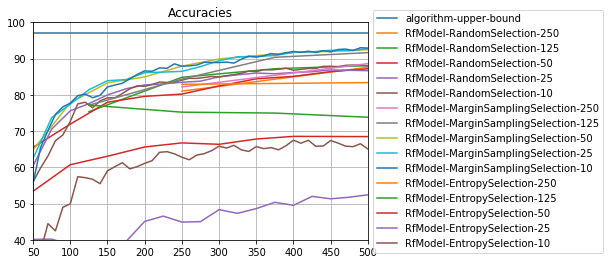

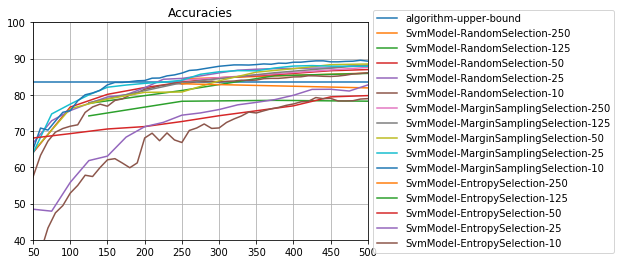

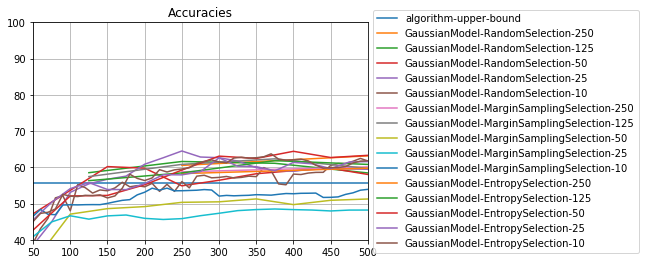

In [0]:
models_str = ['SvmModel', 'RfModel', 'GaussianModel']
selection_functions_str = ['RandomSelection', 'MarginSamplingSelection', 'EntropySelection']
Ks_str = ['250','125','50','25','10'] 
repeats = 1
total_experiments = len(models_str) * len(selection_functions_str) * len(Ks_str) * repeats

print('So which is the better model?')
performance_plot(random_forest_upper_bound, mnist_exp, ['RfModel'] , selection_functions_str    , Ks_str, 1)
performance_plot(svm_upper_bound, mnist_exp, ['SvmModel'] , selection_functions_str    , Ks_str, 1)
performance_plot(gaussian_upper_bound, mnist_exp, ['GaussianModel'] , selection_functions_str    , Ks_str, 1)

Random Forest is the best classifier

So which is the best sample selection function?


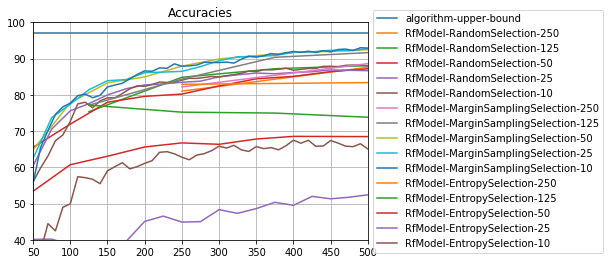

In [0]:
print('So which is the best sample selection function?')
performance_plot(random_forest_upper_bound, mnist_exp, ['RfModel'], selection_functions_str    , Ks_str, 1)

margin sampling is the best selection function

So which is the best k?


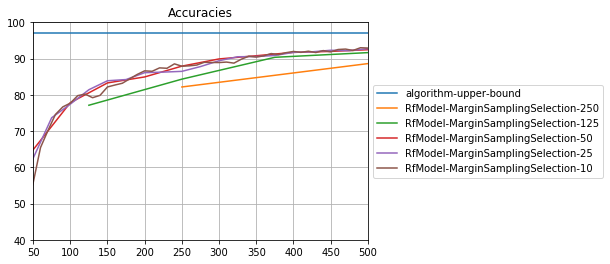

In [0]:
print('So which is the best k?')
performance_plot(random_forest_upper_bound, mnist_exp, ['RfModel'] , ['MarginSamplingSelection'], Ks_str, 1)

25 is the best value for k

### Plot the F1 scores

So which is the better model?


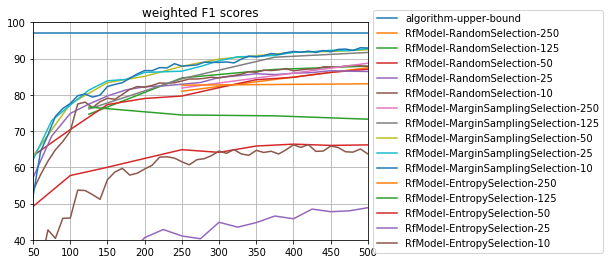

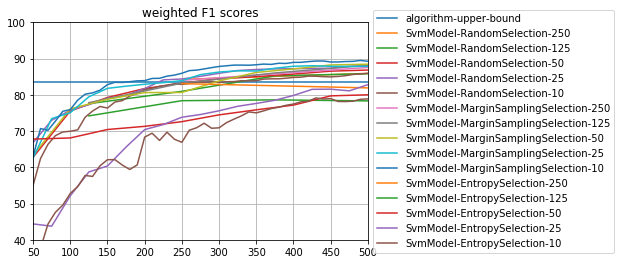

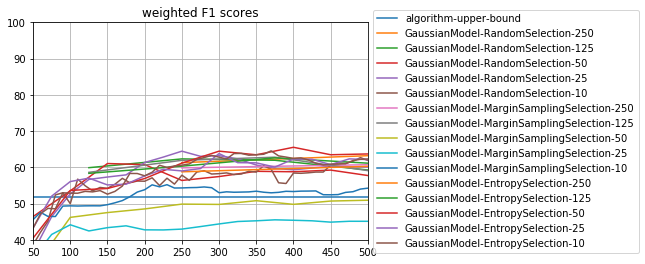

In [0]:
models_str = ['SvmModel', 'RfModel', 'GaussianModel']
selection_functions_str = ['RandomSelection', 'MarginSamplingSelection', 'EntropySelection']
Ks_str = ['250','125','50','25','10'] 
repeats = 1
total_experiments = len(models_str) * len(selection_functions_str) * len(Ks_str) * repeats

print('So which is the better model?')
performance_plot_f1(random_forest_upper_bound_f1, mnist_exp, ['RfModel'] , selection_functions_str    , Ks_str, 1)
performance_plot_f1(svm_upper_bound_f1, mnist_exp, ['SvmModel'] , selection_functions_str    , Ks_str, 1)
performance_plot_f1(gaussian_upper_bound_f1, mnist_exp, ['GaussianModel'] , selection_functions_str    , Ks_str, 1)

Random Forest was chosen as the best classifier

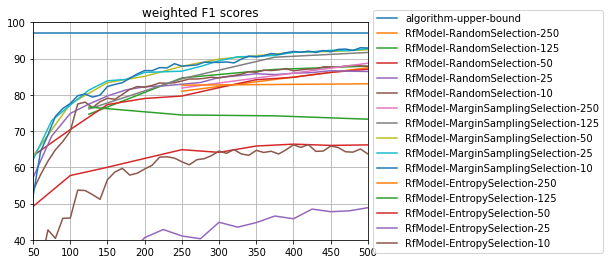

In [0]:
performance_plot_f1(random_forest_upper_bound_f1, mnist_exp, ['RfModel'] , selection_functions_str    , Ks_str, 1)

Margin sampling was chosen as the best selection tecnique

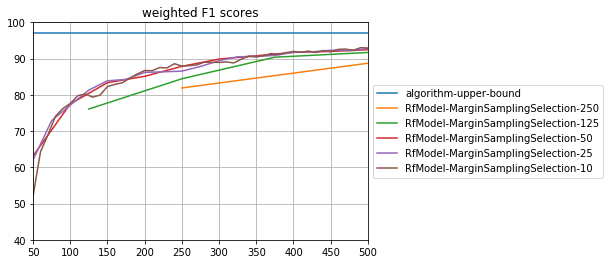

In [0]:
performance_plot_f1(random_forest_upper_bound_f1, mnist_exp, ['RfModel'] , ['MarginSamplingSelection']    , Ks_str, 1)

25 was chosen as the best value for k

## Breast Cancer data set

In [0]:
#(X_bc, y_bc) = download_bc()
(X_train_full_bc, y_train_full_bc, X_test_bc, y_test_bc) = split(trainset_size_bc, X_bc, y_bc)
print ('train:', X_train_full_bc.shape, y_train_full_bc.shape)
print ('test :', X_test_bc.shape, y_test_bc.shape)
classes_bc = len(np.unique(y_bc))
print ('unique classes', classes_bc)

max_queried_bc = 160 # chosen as roughly 33% of the trainset

repeats = 1

models = [SvmModel, RfModel, GaussianModel] 

selection_functions = [RandomSelection, MarginSamplingSelection, EntropySelection] 

Ks = [250,125,50,25,10] 

bc_exp = {}
stopped_at = -1 

# print('directory dump including pickle files:', os.getcwd(), np.sort(os.listdir()))  
# d = pickle_load('Active-learning-experiment-' + str(stopped_at) + '.pkl')  
# print(json.dumps(d, indent=2, sort_keys=True))

bc_exp = experiment(bc_exp, models, selection_functions, Ks, repeats, stopped_at+1, X_train_full_bc, y_train_full_bc, X_test_bc, y_test_bc, max_queried_bc, trainset_size_bc)
print (bc_exp)
results_bc = json.loads(json.dumps(bc_exp, indent=2, sort_keys=True))
print(results_bc)

train: (483, 30) (483,)
test : (86, 30) (86,)
unique classes 2
stopping at: 160
Count = 1, using model = SvmModel, selection_function = RandomSelection, k = 250, iteration = 0.

initial random chosen samples (250,)
initial train set: (250, 30) (250,) unique(labels): [ 97 153] [0 1]
val set: (233, 30) (233,) (250,)

Train set: (250, 30) y: (250,)
Val   set: (233, 30)
Test  set: (86, 30)
training svm...
--------------------------------
Iteration: 1
--------------------------------
y-test set: (86,)
Example run in 0.014 s 

Accuracy rate for 96.511628 
weighted F1 score for 96.581098 
Classification report for classifier SVC(C=1, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False):
              precision    recall  f1-score   support

           0       0.88      1.00      0.94        22
        

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in multiply


--------------------------------
Iteration: 2
--------------------------------
y-test set: (86,)
Example run in 0.934 s 

Accuracy rate for 98.837209 
weighted F1 score for 98.845551 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False):
              precision    recall  f1-score   support

           0       0.96      1.00      0.98        22
           1       1.00      0.98      0.99        64

    accuracy                           0.99        86
   macr

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in multiply


--------------------------------
Iteration: 2
--------------------------------
y-test set: (86,)
Example run in 0.843 s 

Accuracy rate for 96.511628 
weighted F1 score for 96.581098 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False):
              precision    recall  f1-score   support

           0       0.88      1.00      0.94        22
           1       1.00      0.95      0.98        64

    accuracy                           0.97        86
   macr

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in multiply


--------------------------------
Iteration: 3
--------------------------------
y-test set: (86,)
Example run in 0.889 s 

Accuracy rate for 98.837209 
weighted F1 score for 98.845551 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False):
              precision    recall  f1-score   support

           0       0.96      1.00      0.98        22
           1       1.00      0.98      0.99        64

    accuracy                           0.99        86
   macr

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in multiply


--------------------------------
Iteration: 4
--------------------------------
y-test set: (86,)
Example run in 0.911 s 

Accuracy rate for 97.674419 
weighted F1 score for 97.706518 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False):
              precision    recall  f1-score   support

           0       0.92      1.00      0.96        22
           1       1.00      0.97      0.98        64

    accuracy                           0.98        86
   macr

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in multiply


--------------------------------
Iteration: 2
--------------------------------
y-test set: (86,)
Example run in 0.785 s 

Accuracy rate for 95.348837 
weighted F1 score for 95.348837 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False):
              precision    recall  f1-score   support

           0       0.91      0.91      0.91        22
           1       0.97      0.97      0.97        64

    accuracy                           0.95        86
   macr

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in multiply


--------------------------------
Iteration: 3
--------------------------------
y-test set: (86,)
Example run in 0.774 s 

Accuracy rate for 95.348837 
weighted F1 score for 95.273873 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False):
              precision    recall  f1-score   support

           0       0.95      0.86      0.90        22
           1       0.95      0.98      0.97        64

    accuracy                           0.95        86
   macr

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in multiply


--------------------------------
Iteration: 4
--------------------------------
y-test set: (86,)
Example run in 0.784 s 

Accuracy rate for 95.348837 
weighted F1 score for 95.348837 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False):
              precision    recall  f1-score   support

           0       0.91      0.91      0.91        22
           1       0.97      0.97      0.97        64

    accuracy                           0.95        86
   macr

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in multiply


--------------------------------
Iteration: 5
--------------------------------
y-test set: (86,)
Example run in 0.765 s 

Accuracy rate for 97.674419 
weighted F1 score for 97.674419 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False):
              precision    recall  f1-score   support

           0       0.95      0.95      0.95        22
           1       0.98      0.98      0.98        64

    accuracy                           0.98        86
   macr

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in multiply


--------------------------------
Iteration: 6
--------------------------------
y-test set: (86,)
Example run in 0.838 s 

Accuracy rate for 97.674419 
weighted F1 score for 97.674419 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False):
              precision    recall  f1-score   support

           0       0.95      0.95      0.95        22
           1       0.98      0.98      0.98        64

    accuracy                           0.98        86
   macr

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in multiply


--------------------------------
Iteration: 7
--------------------------------
y-test set: (86,)
Example run in 0.856 s 

Accuracy rate for 96.511628 
weighted F1 score for 96.536654 
Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False):
              precision    recall  f1-score   support

           0       0.91      0.95      0.93        22
           1       0.98      0.97      0.98        64

    accuracy                           0.97        86
   macr

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in multiply
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in multiply
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in multiply


--------------------------------
Iteration: 2
--------------------------------
y-test set: (86,)
Example run in 0.001 s 

Accuracy rate for 96.511628 
weighted F1 score for 96.484586 
Classification report for classifier GaussianNB(priors=None, var_smoothing=1e-09):
              precision    recall  f1-score   support

           0       0.95      0.91      0.93        22
           1       0.97      0.98      0.98        64

    accuracy                           0.97        86
   macro avg       0.96      0.95      0.95        86
weighted avg       0.96      0.97      0.96        86


Confusion matrix:
[[20  2]
 [ 1 63]]
--------------------------------
val predicted: (383,) [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 1
 1 1 1 1 0 1 0 1 1 1 0 1 1 1 1 1 0 0 1 0 1 0 0 1 1 0 0 1 0 0 1 1 1 0 0 1 1
 1 1 1 1 1 0 1 1 0 1 0 1 1 1 0 0 1 0 0 1 1 0 1 0 1 0 0 0 1 1 1 0 1 0 1 1 1
 1 0 1 1 1 1 1 1 0 1 1 0 0 1 0 1 1 0 0 1 0 1 1 1 1 0 1 1 0 0 1 0 1 1 1 0 1
 1 0 0 1 0 0 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in multiply
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in multiply
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in multiply


[0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 1 1
 0 1 1 1 1 1 1 1 1 0 1 1 0 0 1 1 1 1 0 1 0 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1 0
 1 0 1 0 1 0 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 0 0 1 0 1
 1 1 1 0 0 0 1 0 0 1 0 1 1 1 0 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 0 0 1 1 1 0
 0 1 0 1 1 0 0 1 1 1 0 1 1 1 0 0 1 1 0 0 1 1 1 0 1 1 1 0 0 1 0 0 1 0 0 0 0
 1 0 0 1 1 0 1 1 0 1 0 1 1 1 0 0 1 1 1 0 1 0 1 1 1 0 0 1 1 0 1 1 0 1 0 1 1
 1 0 1 1 1 1 1 1 0 0 1 0 0 0 0 0 1 1 1 1 1 1 0 0 1 0 1 1 0 1 0 1 1 1 1 0 1
 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1 1 0 1 0 1 1 1 1
 0 0 0 1 1 1 1 0 1 0 1 1 1 1 0 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 1
 0 1 0 0 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1 1 1 1 1 1 0 1 1 1 1 1 1
 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 0 1 0 0 1 1 1 1 1 1 1 0 1 1 0
 1 0 1 1 0 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1]
trainset before (40, 30) (40,)
trainset after (50, 30) (50,)
updated train set: (50, 30) (50,) unique

### Plot the Accuracies

In [0]:
def performance_plot_bc(fully_supervised_accuracy, dic, models, selection_functions, Ks, repeats, min_xlim):  
    fig, ax = plt.subplots()
    ax.plot([0,160],[fully_supervised_accuracy, fully_supervised_accuracy],label = 'algorithm-upper-bound')
    for model_object in models:
      for selection_function in selection_functions:
        for idx, k in enumerate(Ks):
            x = np.arange(float(Ks[idx]), 160 + float(Ks[idx]), float(Ks[idx]))            
            Sum = np.array(dic[model_object][selection_function][k][0][0])
            for i in range(1, repeats):
                Sum = Sum + np.array(dic[model_object][selection_function][k][i][0])
            mean = Sum / repeats
            ax.plot(x, mean ,label = model_object + '-' + selection_function + '-' + str(k))
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_xlim([50,160])
    ax.set_ylim([min_xlim,100])
    ax.grid(True)
    plt.title("Accuracies")
    plt.show()
    return None

So which is the better model? under the stopping condition and hyper parameters


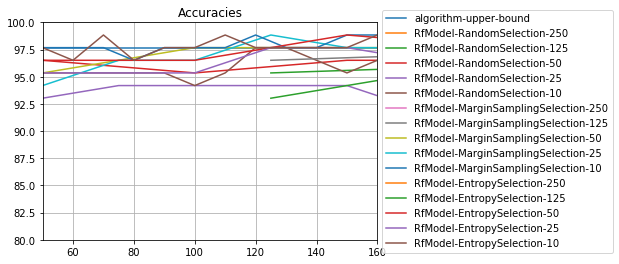

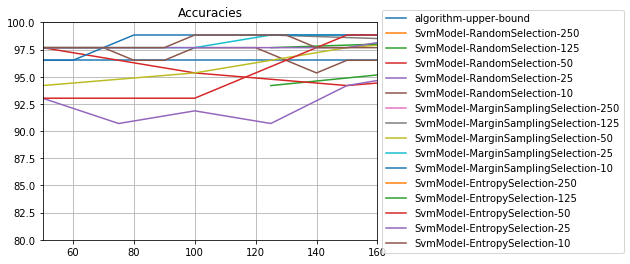

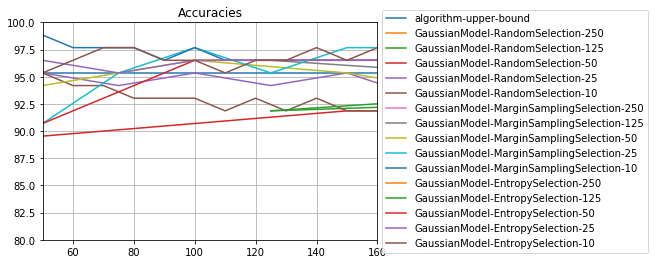

In [0]:
models_str = ['SvmModel', 'RfModel', 'GaussianModel']
selection_functions_str = ['RandomSelection', 'MarginSamplingSelection', 'EntropySelection']
Ks_str = ['250','125','50','25','10'] 
repeats = 1
total_experiments = len(models_str) * len(selection_functions_str) * len(Ks_str) * repeats

print('So which is the better model? under the stopping condition and hyper parameters')
performance_plot_bc(random_forest_upper_bound_bc, bc_exp, ['RfModel'] , selection_functions_str    , Ks_str, 1, 80)
performance_plot_bc(svm_upper_bound_bc, bc_exp, ['SvmModel'] , selection_functions_str    , Ks_str, 1, 80)
performance_plot_bc(gaussian_upper_bound_bc, bc_exp, ['GaussianModel'] , selection_functions_str    , Ks_str, 1, 80)

Random Forest was chosen as the best classification with low selection sizes

So which is the best sample selection function?


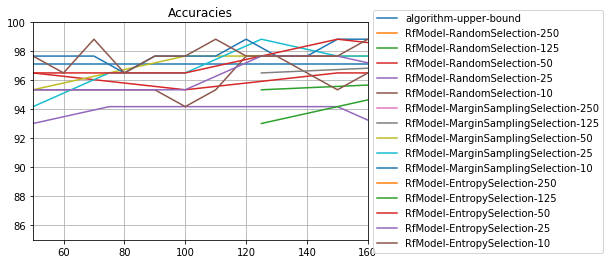

In [0]:
print('So which is the best sample selection function?')
performance_plot_bc(random_forest_upper_bound_bc, bc_exp, ['RfModel'], selection_functions_str    , Ks_str, 1, 85)

Entropy selection was chosen as the best for low selection sizes

So which is the best k?


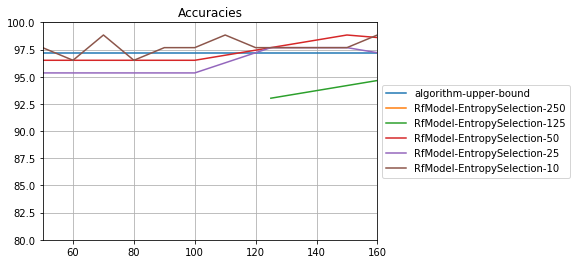

In [0]:
print('So which is the best k?')
performance_plot_bc(random_forest_upper_bound_bc, bc_exp, ['RfModel'] , ['EntropySelection'], Ks_str, 1, 80)

10 was chosen as the best k

### Plot the F1 scores

In [0]:
def performance_plot_bc_f1(fully_supervised_accuracy, dic, models, selection_functions, Ks, repeats, min_xlim):  
    fig, ax = plt.subplots()
    ax.plot([0,160],[fully_supervised_accuracy, fully_supervised_accuracy],label = 'algorithm-upper-bound')
    for model_object in models:
      for selection_function in selection_functions:
        for idx, k in enumerate(Ks):
            x = np.arange(float(Ks[idx]), 160 + float(Ks[idx]), float(Ks[idx]))            
            Sum = np.array(dic[model_object][selection_function][k][0][1])
            for i in range(1, repeats):
                Sum = Sum + np.array(dic[model_object][selection_function][k][i][1])
            mean = Sum / repeats
            ax.plot(x, mean ,label = model_object + '-' + selection_function + '-' + str(k))
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_xlim([50,160])
    ax.set_ylim([min_xlim,100])
    ax.grid(True)
    plt.title("weighted F1 scores")
    plt.show()
    return None

So which is the better model? under the stopping condition and hyper parameters


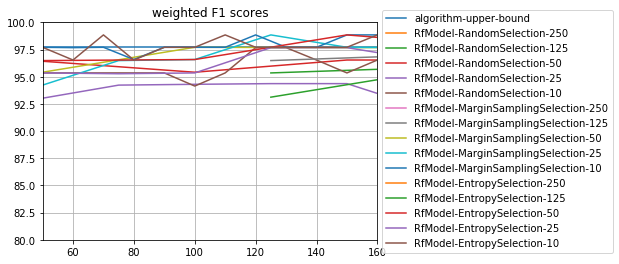

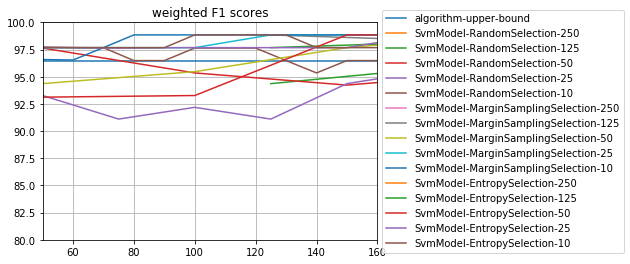

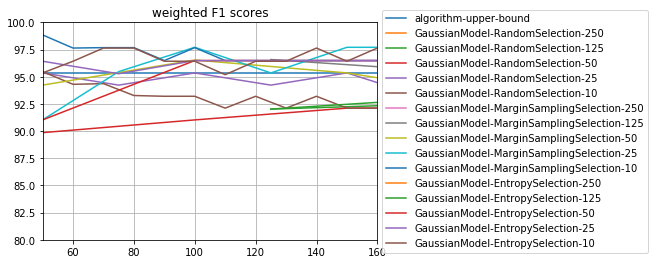

In [0]:
models_str = ['SvmModel', 'RfModel', 'GaussianModel']
selection_functions_str = ['RandomSelection', 'MarginSamplingSelection', 'EntropySelection']
Ks_str = ['250','125','50','25','10'] 
repeats = 1
total_experiments = len(models_str) * len(selection_functions_str) * len(Ks_str) * repeats

print('So which is the better model? under the stopping condition and hyper parameters')
performance_plot_bc_f1(random_forest_upper_bound_bc_f1, bc_exp, ['RfModel'] , selection_functions_str    , Ks_str, 1, 80)
performance_plot_bc_f1(svm_upper_bound_bc_f1, bc_exp, ['SvmModel'] , selection_functions_str    , Ks_str, 1, 80)
performance_plot_bc_f1(gaussian_upper_bound_bc_f1, bc_exp, ['GaussianModel'] , selection_functions_str    , Ks_str, 1, 80)

Random Forest was chosen as the best classification with low selection sizes

In [0]:
print('So which is the best sample selection function?')
performance_plot_bc_f1(random_forest_upper_bound_bc_f1, bc_exp, ['RfModel'], selection_functions_str    , Ks_str, 1, 80)

So which is the best sample selection function?


Entropy selection was chosen as the best for low selection sizes

In [0]:
print('So which is the best k?')
performance_plot_bc_f1(random_forest_upper_bound_bc_f1, bc_exp, ['RfModel'] , ['EntropySelection'], Ks_str, 1, 80)

So which is the best k?


10 was chosen as the best k